<a href="https://colab.research.google.com/github/KoviSingh/Time_Series_Analysis/blob/main/Finall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

df=pd.read_excel('MM25.xlsx')

df.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'MM25.xlsx'

In [ ]:
df.isnull().sum()

Quarter               0
Revenue (US $M)       0
Net Income (US $M)    0
dtype: int64

In [ ]:
df.drop(['Net Income (US $M)'],axis=1,inplace=True)
df.rename(columns = {'Revenue (US $M)':'Value'}, inplace = True)

In [ ]:
def convert_to_int(value):
    return int(value.replace('$', '').replace(',', ''))

# Apply the function to the 'profit' column
df['Value'] = df['Value'].apply(convert_to_int)

df.set_index('Quarter',inplace=True)
df

Value
Quarter          
2020-03-31  75452
2019-12-31  87437
2019-09-30  69981
2019-06-30  63404
2019-03-31  59700
...           ...
2006-03-31   2279
2005-12-31   2977
2005-09-30   1858
2005-06-30   1753
2005-03-31   1902

[61 rows x 1 columns]

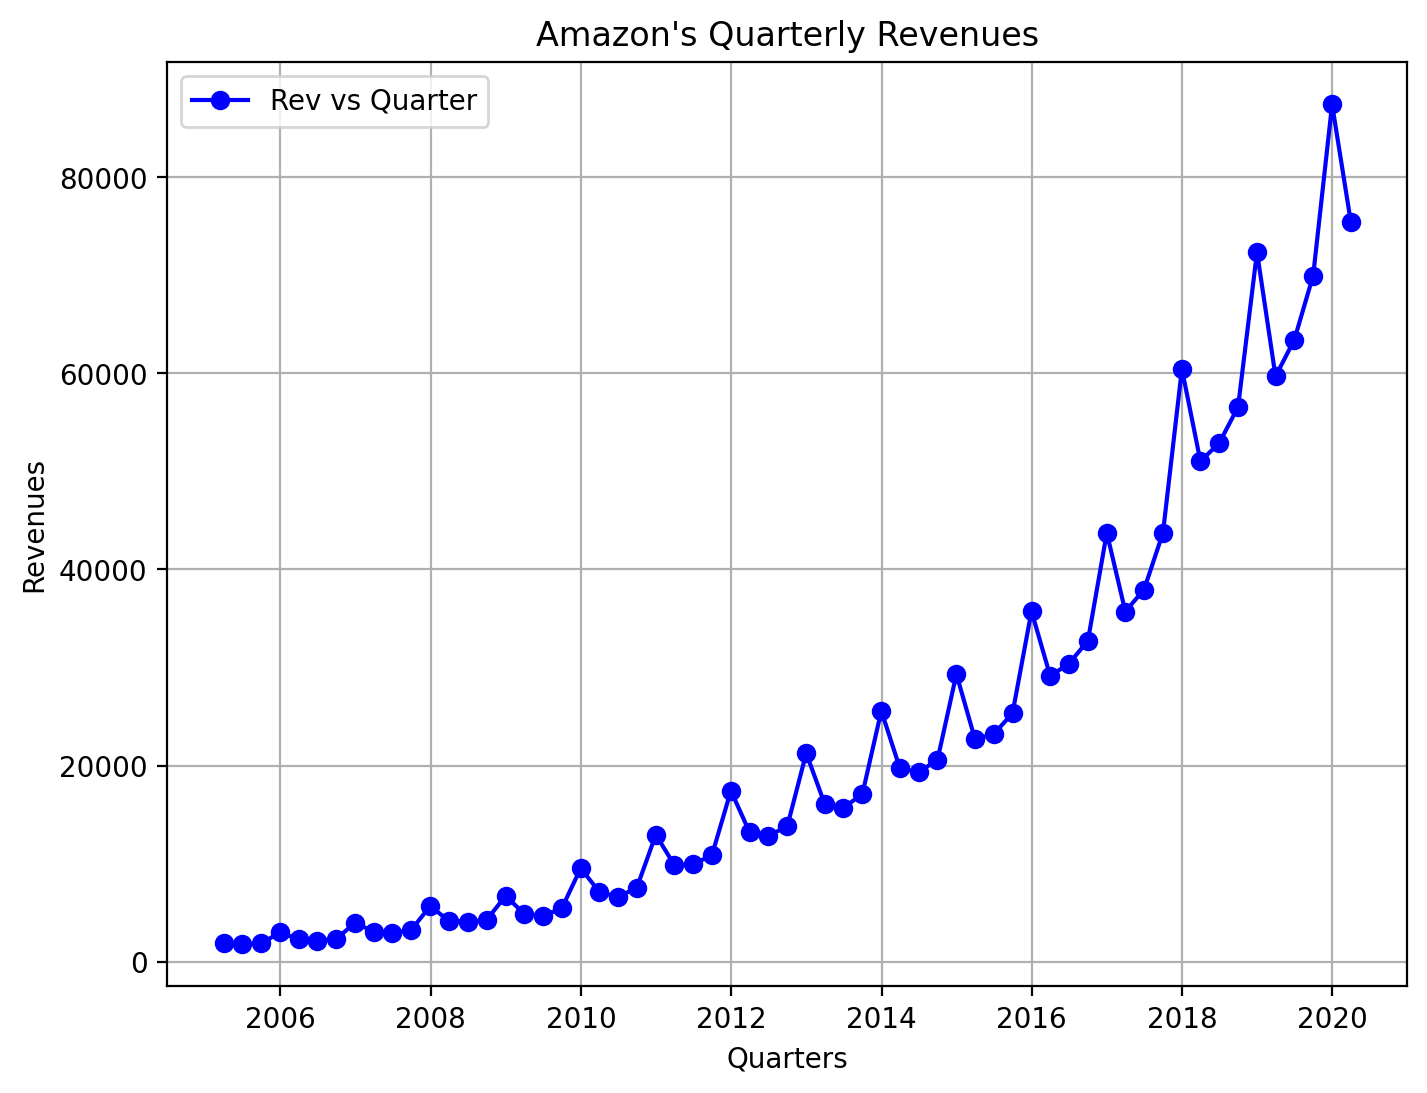

In [ ]:

plt.figure(dpi=200,figsize=(8,6))
plt.plot(df.index,df['Value'],marker='o', linestyle='-', color='b', label='Rev vs Quarter')
plt.xlabel('Quarters')
plt.ylabel('Revenues')
plt.title("Amazon's Quarterly Revenues")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = [8, 6]

In [ ]:
df_copy=df[::-1]

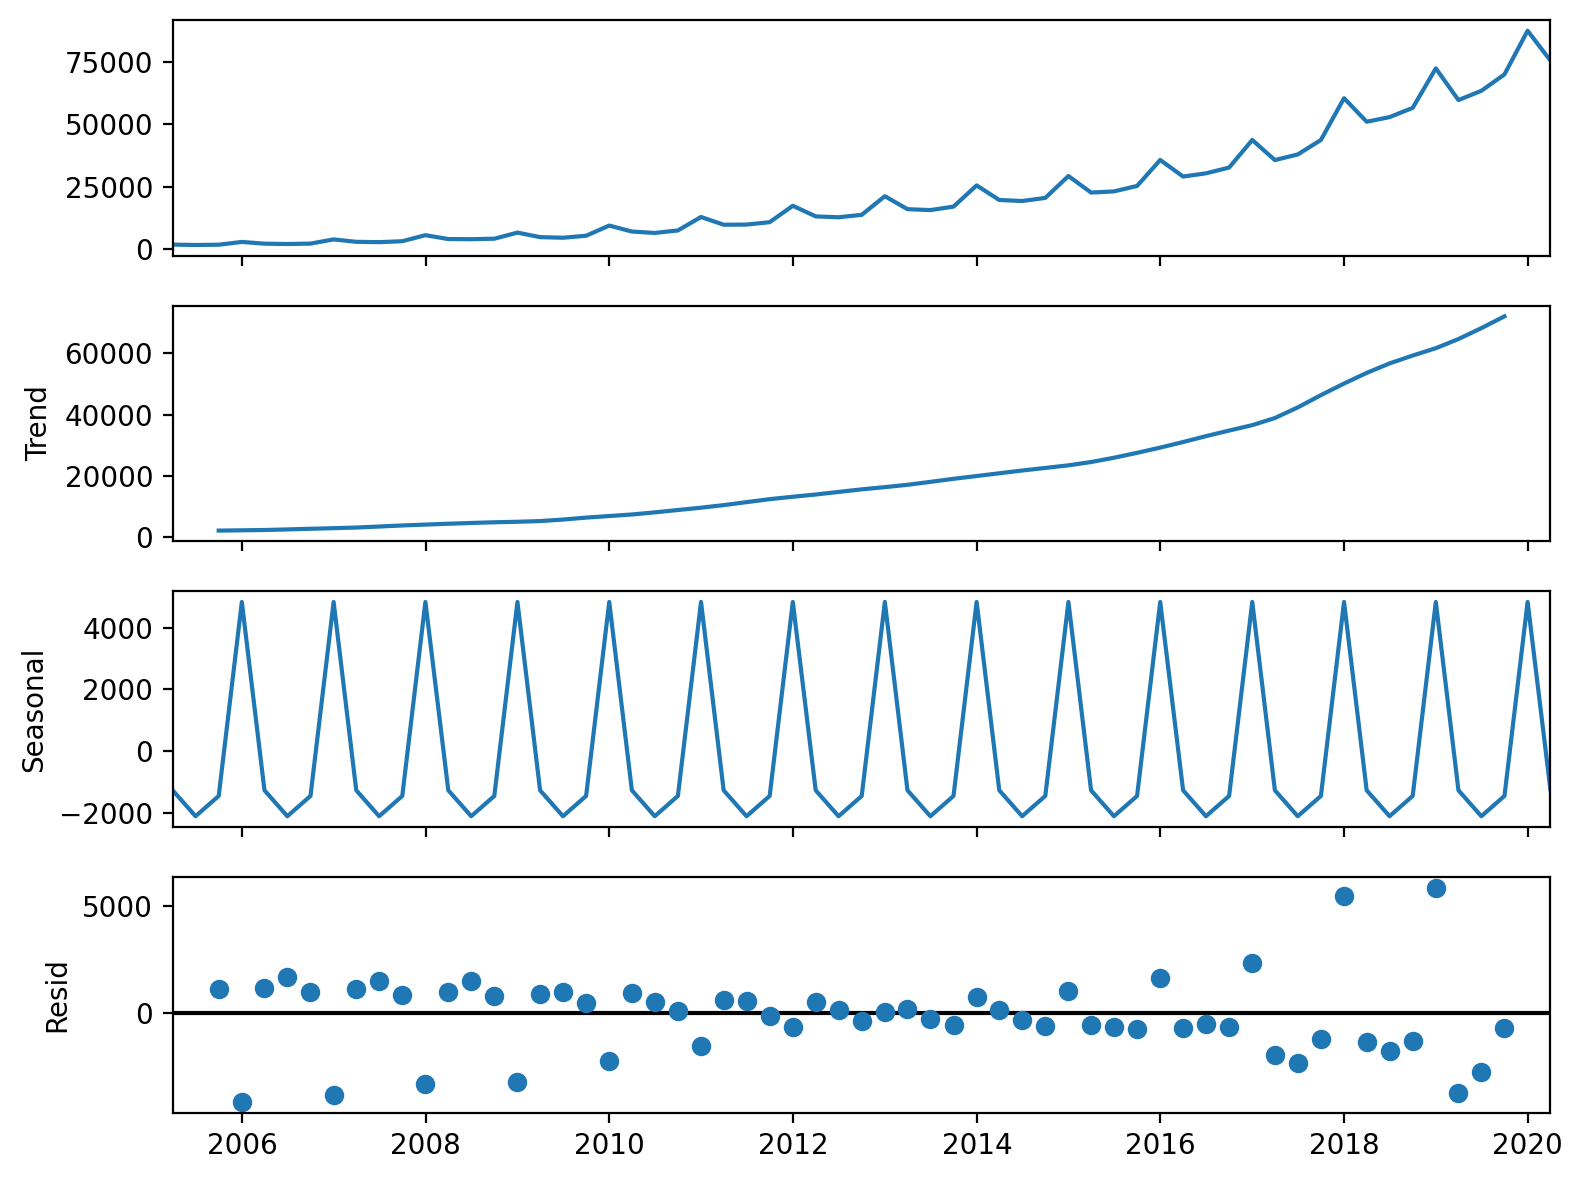

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df_copy, model="additive")
decompose_data.plot()

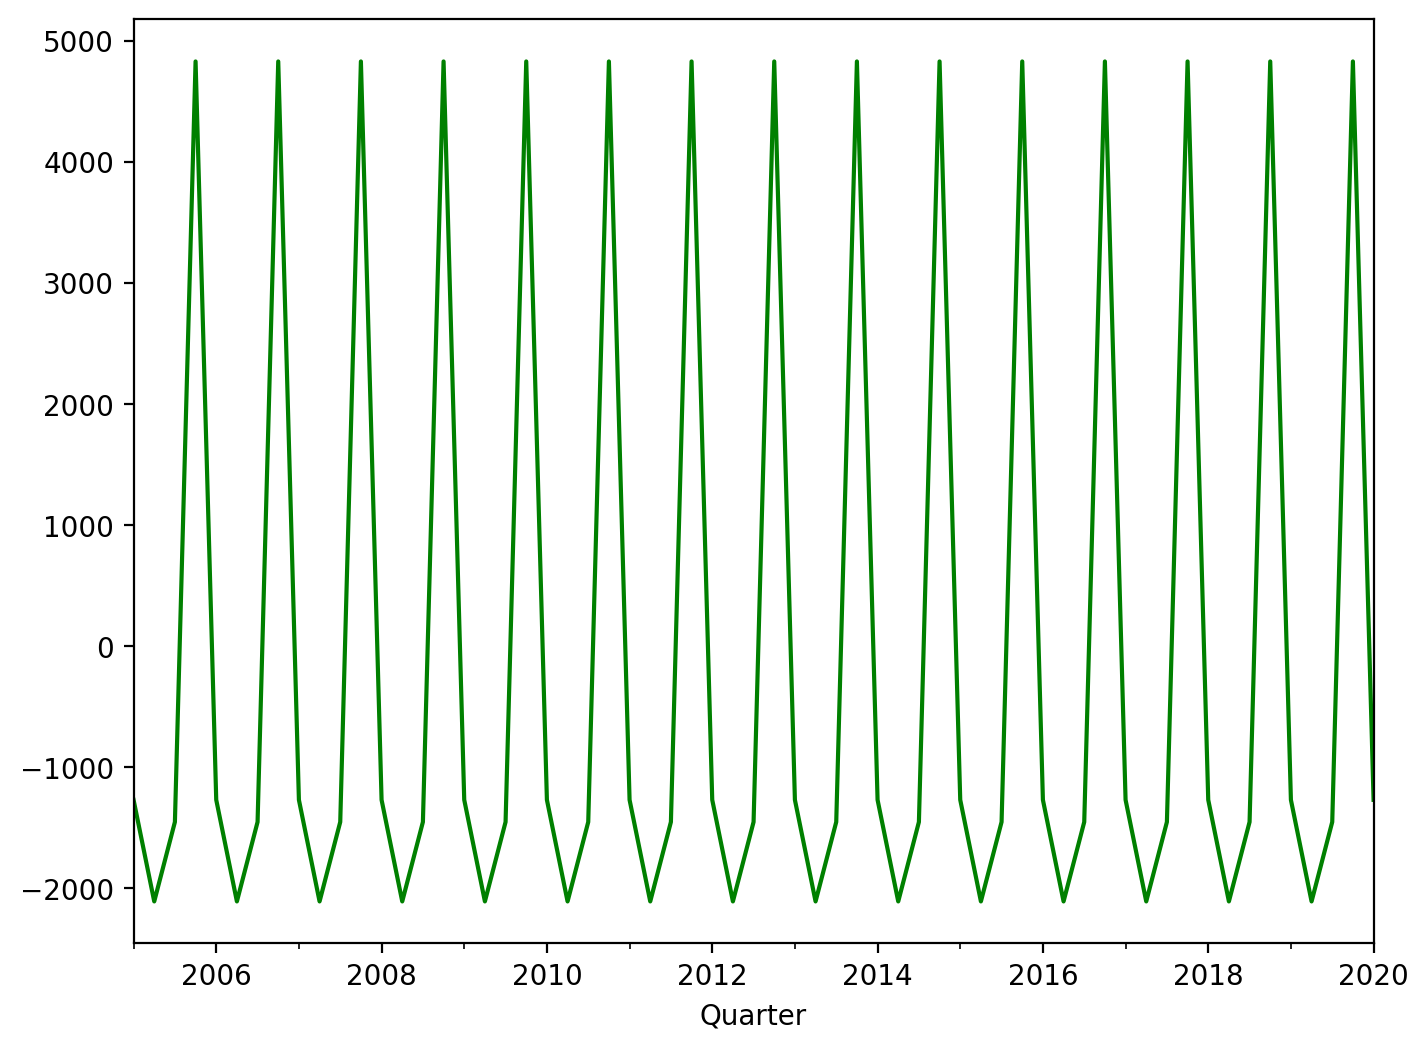

In [ ]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df.Value, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)


if dftest[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

1. ADF :  -2.444836038197226
2. P-Value :  0.12947943121838967
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 50
5. Critical Values :
	 1% :  -3.568485864
	 5% :  -2.92135992
	 10% :  -2.5986616
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



**ARIMA TESTING**

In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()
  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

Moving Average

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

Making dataset stationary for the implementation of ARIMA

In [ ]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(2))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.168334290748684
p-value : 1.0199685036516651e-05
Number of Lags Used : 5
Number of Observations Used : 52
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


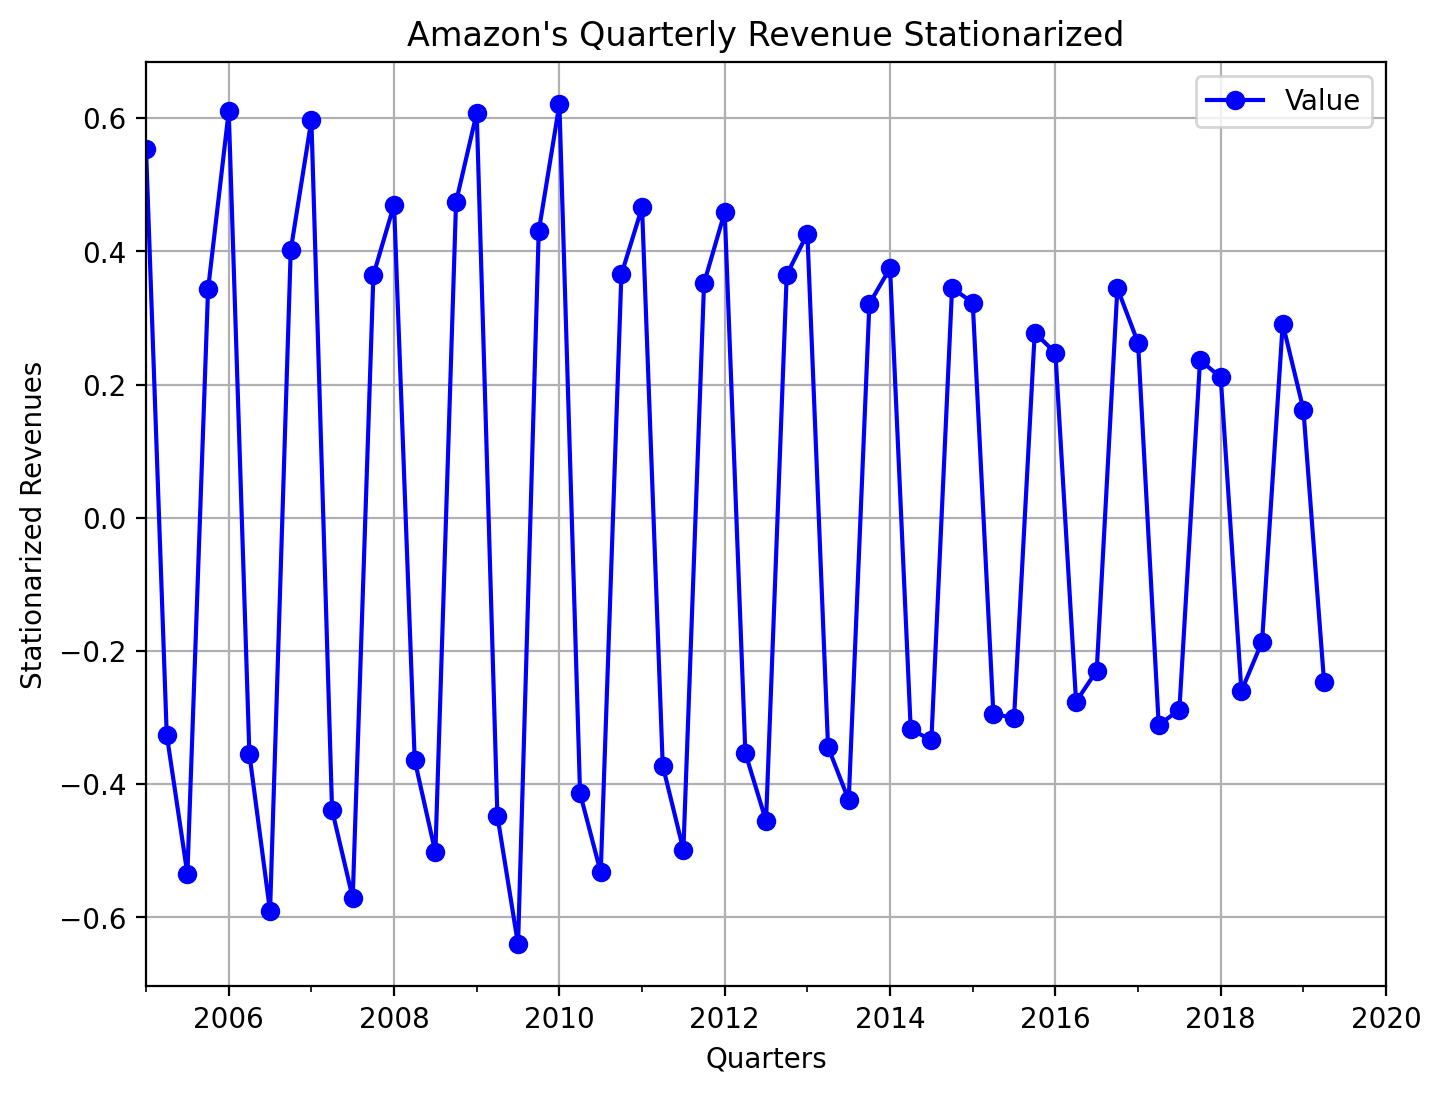

In [ ]:
# print(df_testing.to_string())
df_testing.plot(marker='o', linestyle='-', color='b', label='Stationarized Rev vs Quarter')
plt.xlabel('Quarters')
plt.ylabel('Stationarized Revenues')
plt.title("Amazon's Quarterly Revenue Stationarized")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
CF = plot_acf(df_testing.dropna(),lags=12)

In [ ]:
PACF = plot_pacf(df_testing.dropna(),lags=12)

The RMSE is : 0.4851412530728342 , Value of p :  1
The RMSE is : 0.04705992918030658 , Value of p :  2
The RMSE is : 0.05569059372963045 , Value of p :  3
The RMSE is : 0.05727853516659203 , Value of p :  4
The RMSE is : 0.062106232090639465 , Value of p :  5
The RMSE is : 0.059123771718965386 , Value of p :  6
The RMSE is : 0.06395319387521066 , Value of p :  7
The RMSE is : 0.0691390912845454 , Value of p :  8
The RMSE is : 0.08331994168081154 , Value of p :  9
The RMSE is : 0.08614810756075778 , Value of p :  10
The RMSE is : 0.09058882591470888 , Value of p :  11
The RMSE is : 0.09025922237705175 , Value of p :  12


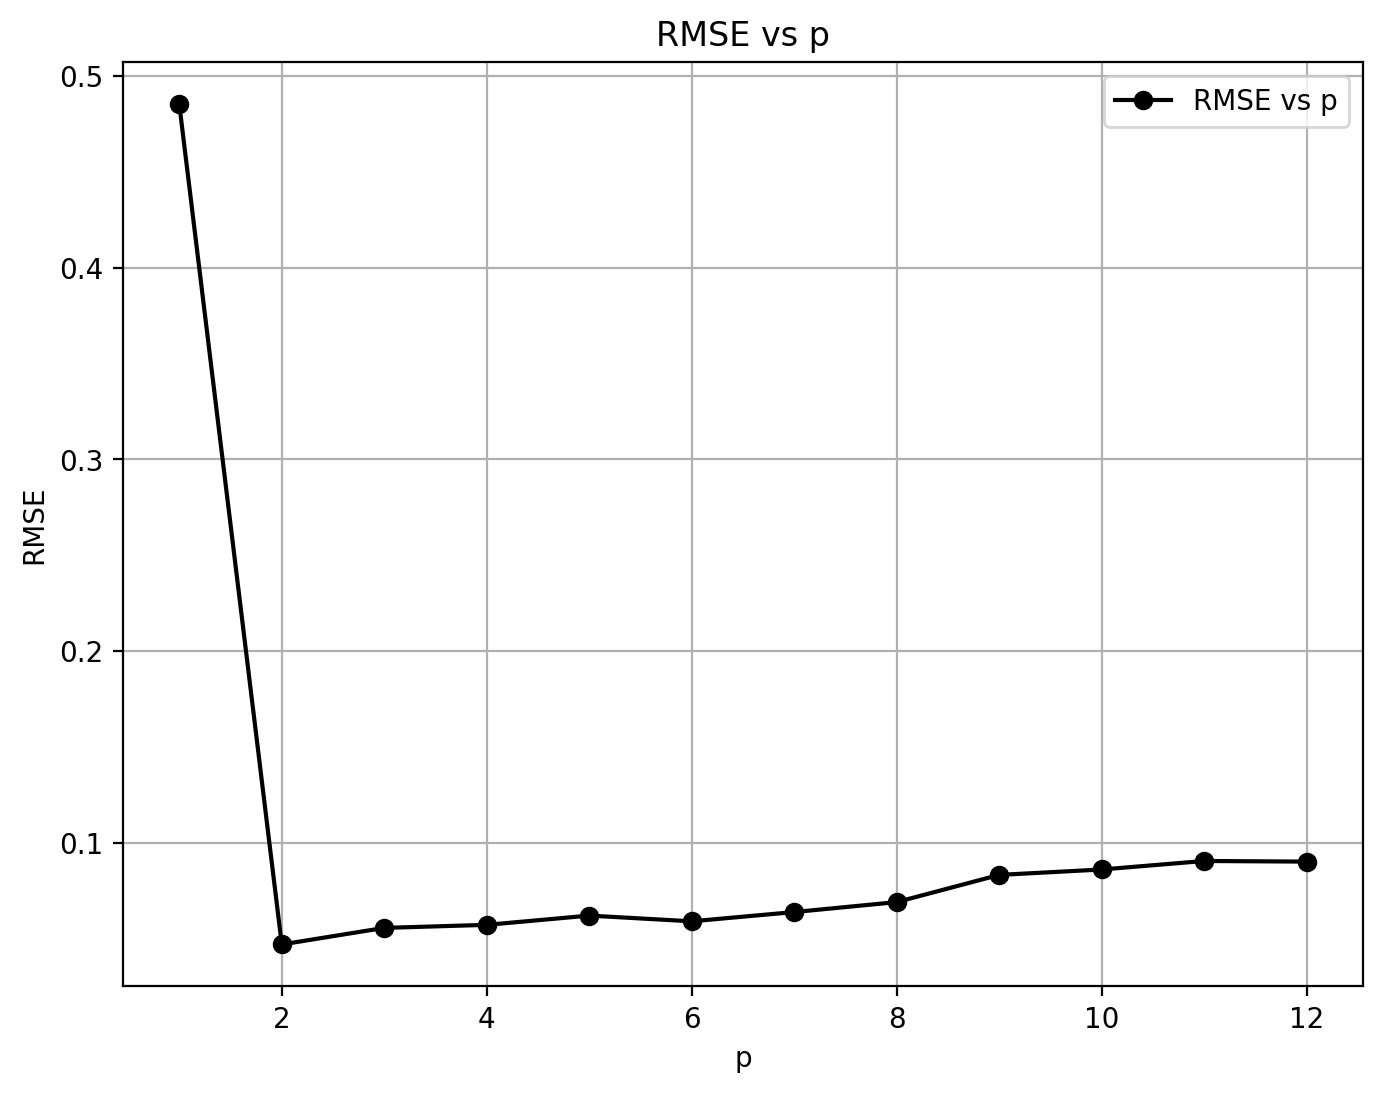

In [ ]:
r=[]
p=[]
for i in range(1,13):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  r.append(RMSE)
  p.append(i)
plt.figure(dpi=200)
plt.plot(p, r, marker='o', linestyle='-', color='black', label='RMSE vs p')
plt.xlabel('p')
plt.ylabel('RMSE')
plt.title('RMSE vs p')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_p_value = p[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding p-value:", optimal_p_value)

Minimum RMSE: 0.04705992918030658
Corresponding p-value: 2


In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(optimal_p_value,pd.DataFrame(df_testing.Value))

The RMSE is : 0.04705992918030658 , Value of p :  2


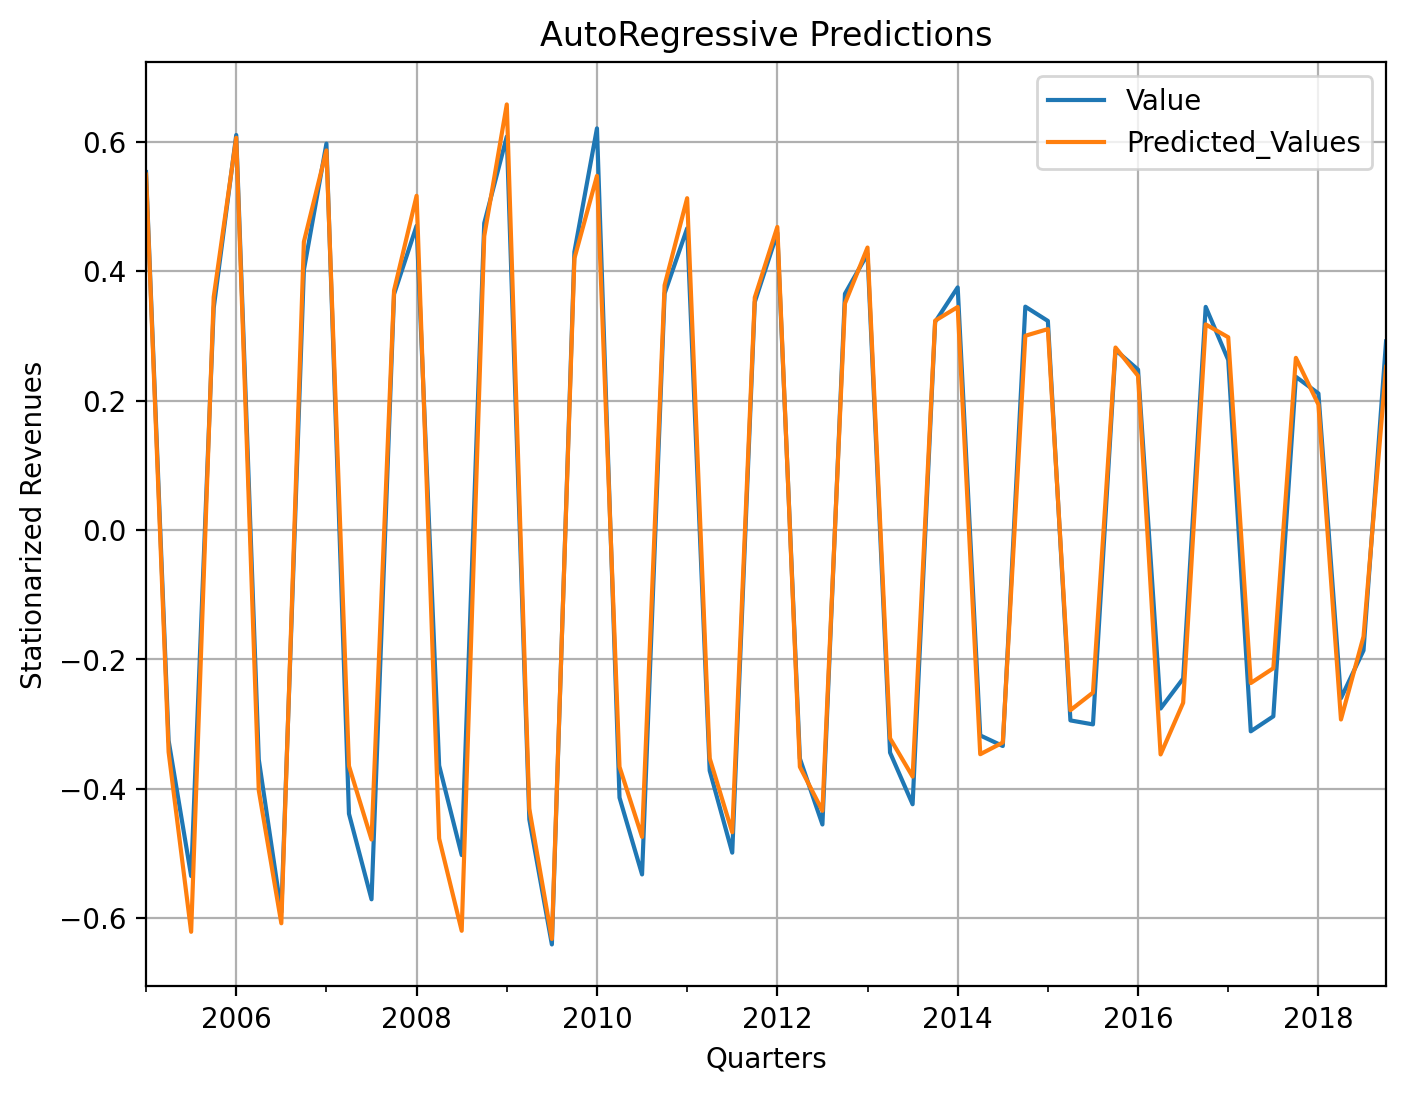

In [ ]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot(linestyle='-')
plt.xlabel('Quarters')
plt.ylabel('Stationarized Revenues')
plt.title("AutoRegressive Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_c['Residuals'] = df_c.Value - df_c.Predicted_Values

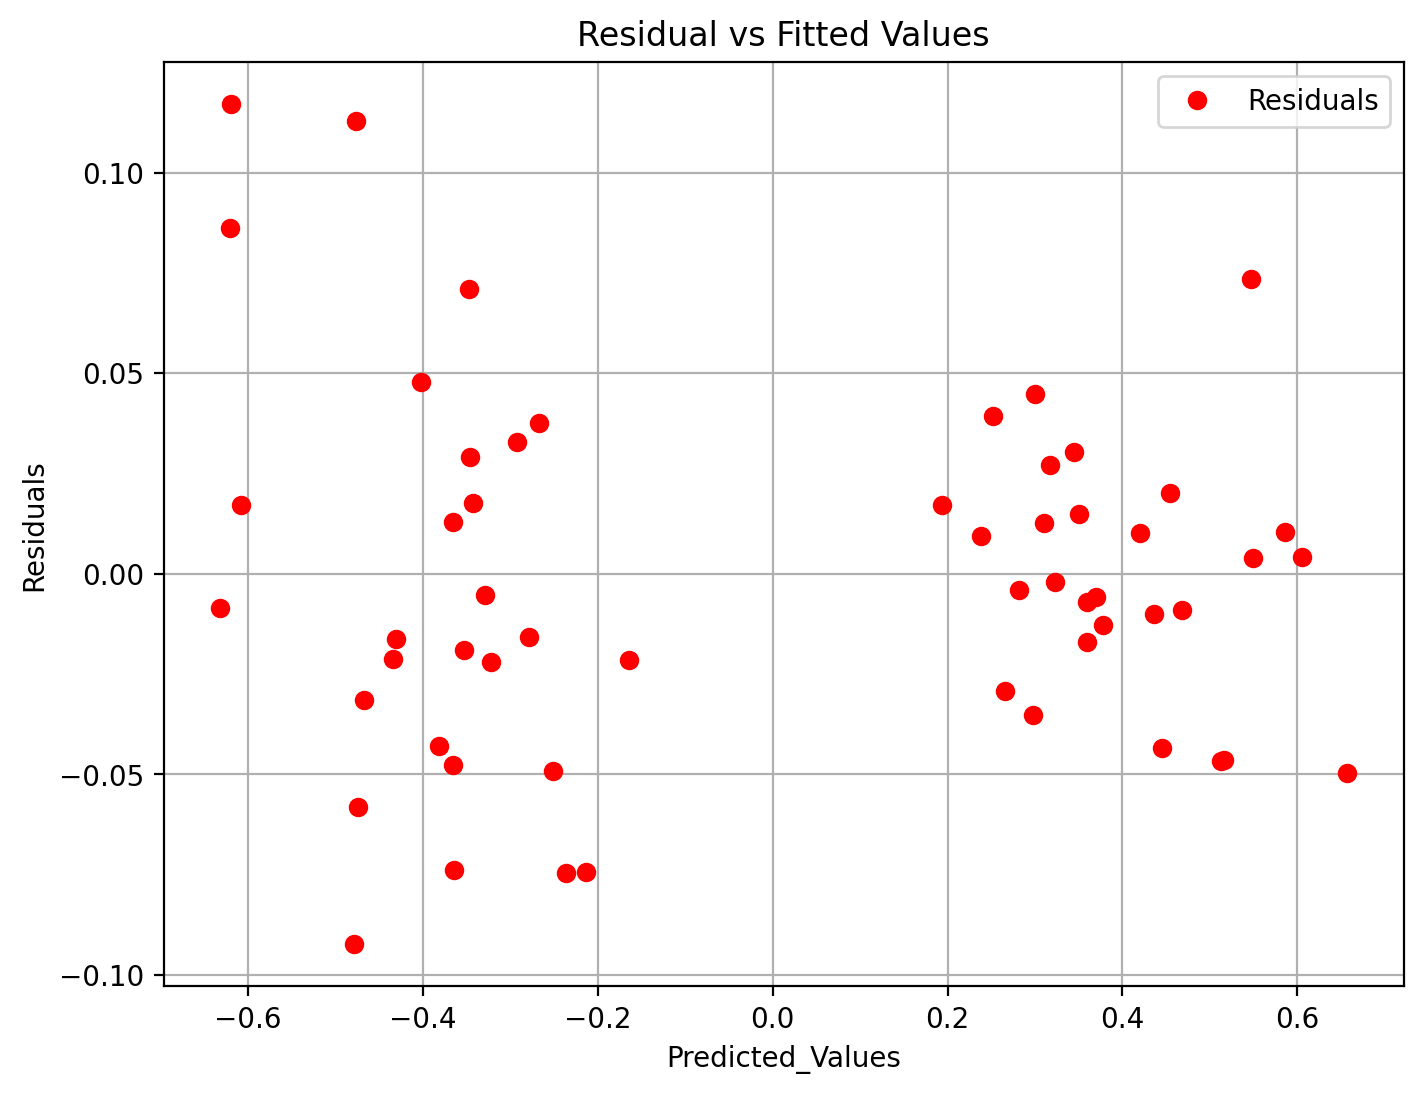

In [ ]:
df_c.plot(x='Predicted_Values', y='Residuals', style='o',color='red')
plt.xlabel('Predicted_Values')
plt.ylabel('Residuals')
plt.title("Residual vs Fitted Values")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values
res

Residuals
Quarter              
2018-12-31   0.039300
2018-09-30  -0.021389
2018-06-30   0.032802
2018-03-31   0.017145
2017-12-31  -0.029280
2017-09-30  -0.074300
2017-06-30  -0.074601
2017-03-31  -0.035100
2016-12-31   0.027077
2016-09-30   0.037487
2016-06-30   0.070961
2016-03-31   0.009536
2015-12-31  -0.003913
2015-09-30  -0.049106
2015-06-30  -0.015787
2015-03-31   0.012635
2014-12-31   0.044936
2014-09-30  -0.005377
2014-06-30   0.029063
2014-03-31   0.030313
2013-12-31  -0.001921
2013-09-30  -0.042828
2013-06-30  -0.022037
2013-03-31  -0.009885
2012-12-31   0.014916
2012-09-30  -0.021115
2012-06-30   0.012838
2012-03-31  -0.009082
2011-12-31  -0.007021
2011-09-30  -0.031533
2011-06-30  -0.019070
2011-03-31  -0.046579
2010-12-31  -0.012722
2010-09-30  -0.058032
2010-06-30  -0.047597
2010-03-31   0.073401
2009-12-31   0.010268
2009-09-30  -0.008490
2009-06-30  -0.016257
2009-03-31  -0.049625
2008-12-31   0.020090
2008-09-30   0.117001
2008-06-30   0.112880
2008-03-31  -0.046289
2007-12-31  -0.005728
2007-09-30  -0.092369
2007-06-30  -0.073792
2007-03-31   0.010497
2006-12-31  -0.043461
2006-09-30   0.017231
2006-06-30   0.047798
2006-03-31   0.004186
2005-12-31  -0.017004
2005-09-30   0.086156
2005-06-30   0.017671
2005-03-31   0.003893

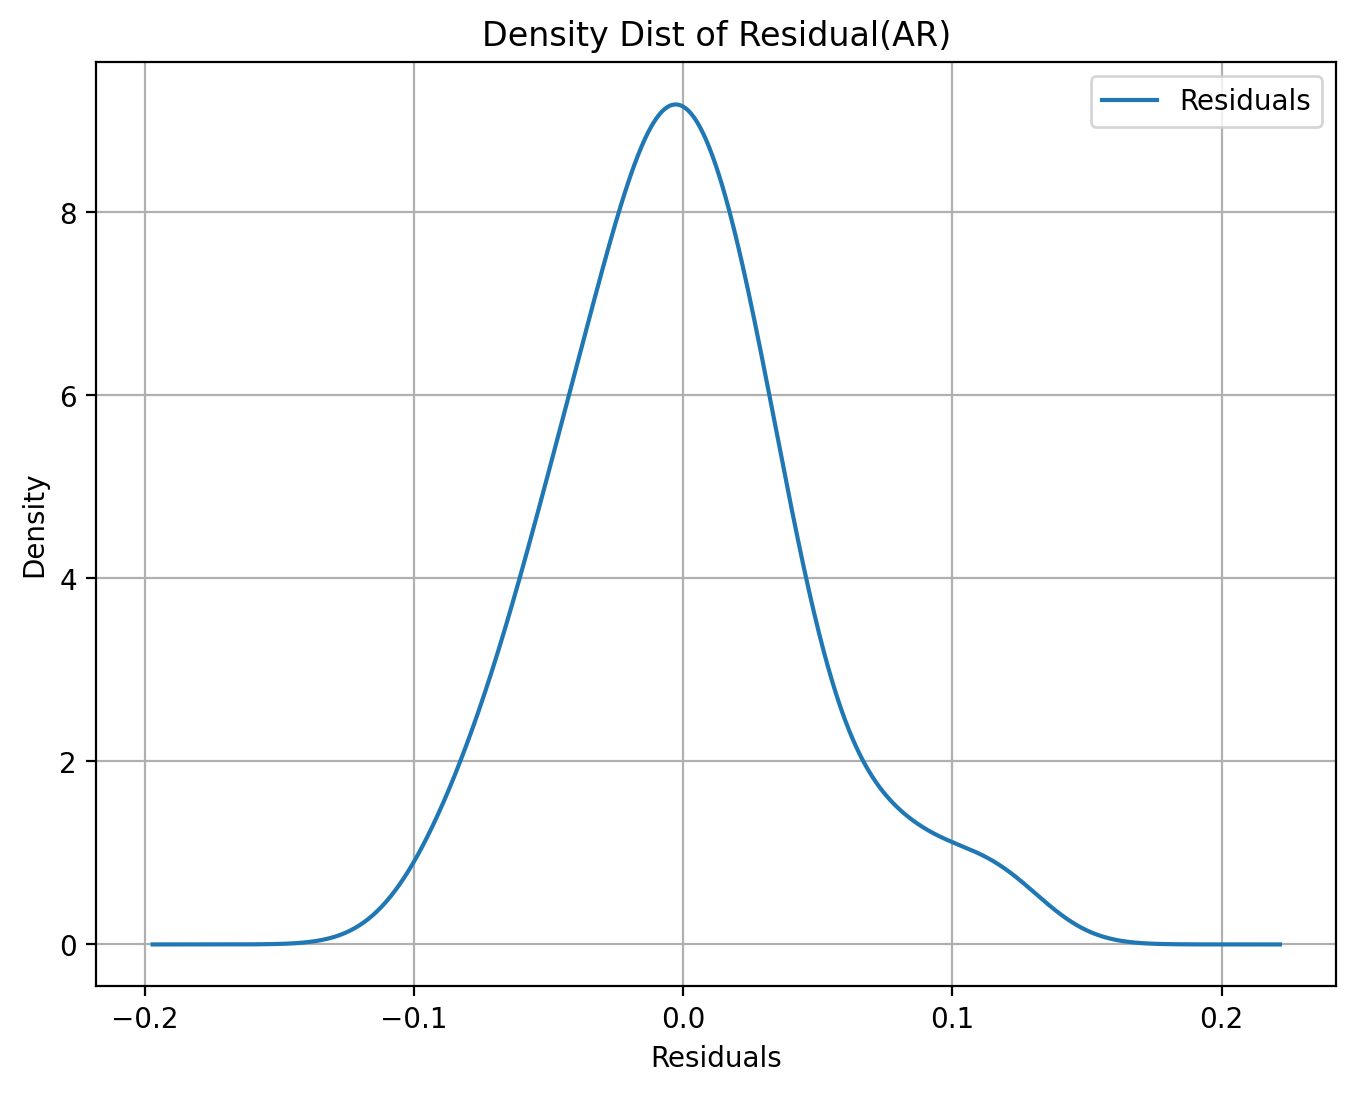

In [ ]:
res.plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(AR)")
plt.legend()
plt.grid(True)
plt.show()

The RMSE is : 0.046101372224288964 , Value of q :  1
The RMSE is : 0.05566386349917427 , Value of q :  2
The RMSE is : 0.05918499208373238 , Value of q :  3
The RMSE is : 0.05615778751993473 , Value of q :  4
The RMSE is : 0.05680690350182368 , Value of q :  5
The RMSE is : 0.05345517733146444 , Value of q :  6
The RMSE is : 0.05056573795534359 , Value of q :  7
The RMSE is : 0.05076349830695955 , Value of q :  8
The RMSE is : 0.05140194606970386 , Value of q :  9
The RMSE is : 0.05592249396262457 , Value of q :  10
The RMSE is : 0.05467510874448466 , Value of q :  11
The RMSE is : 0.06075223820544179 , Value of q :  12
The RMSE is : 0.06662154041405573 , Value of q :  13


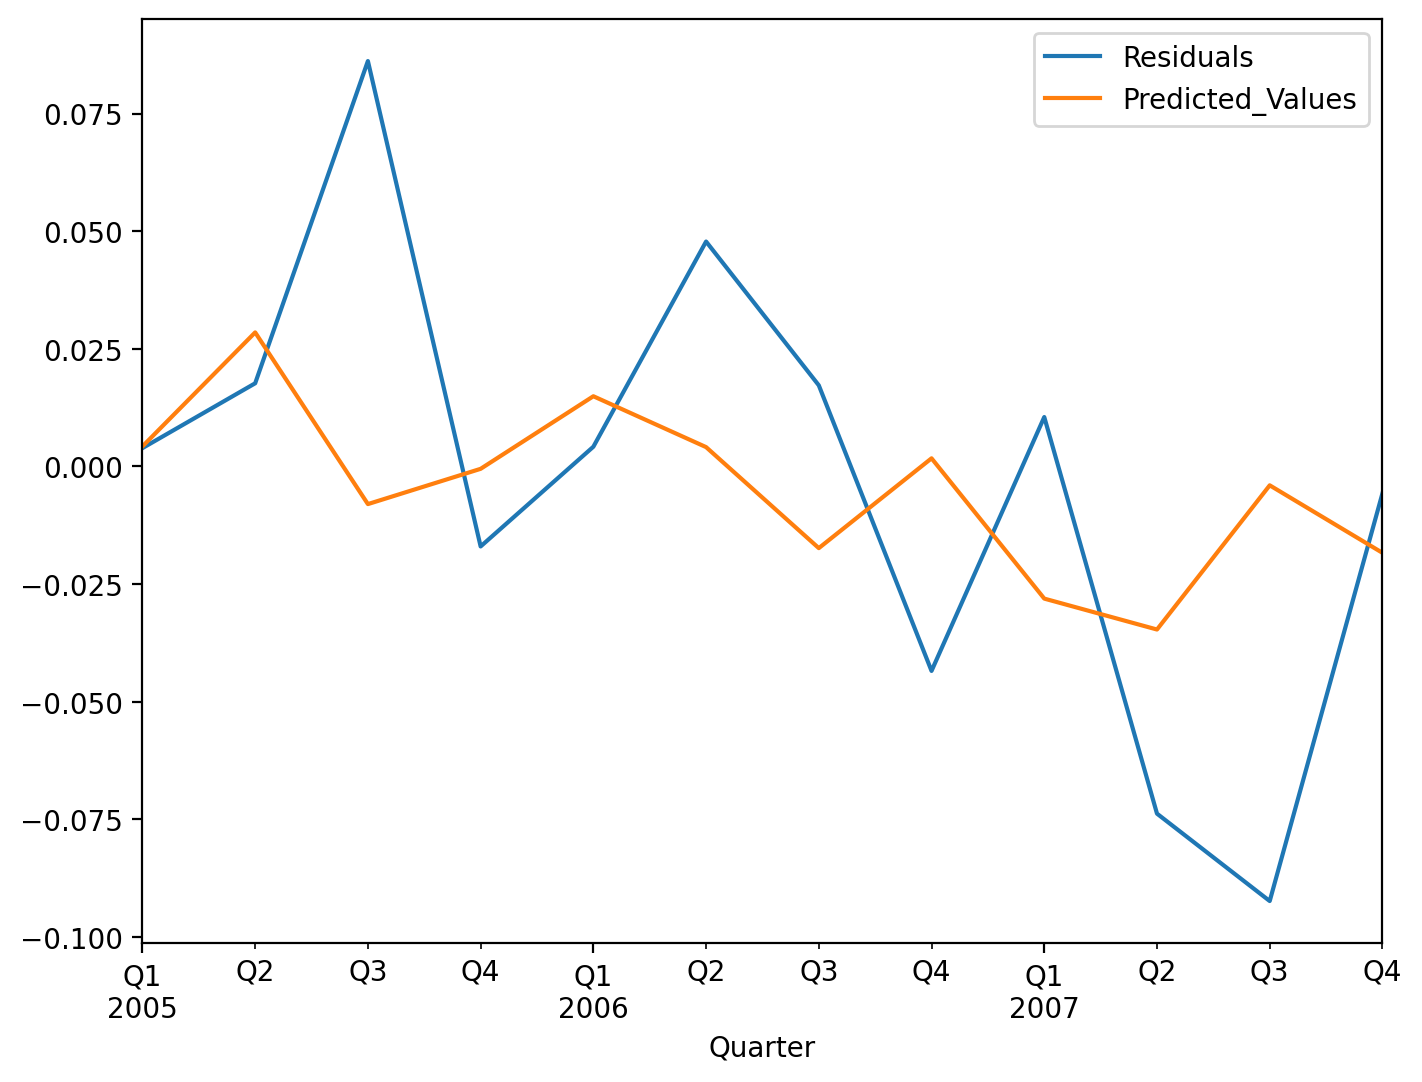

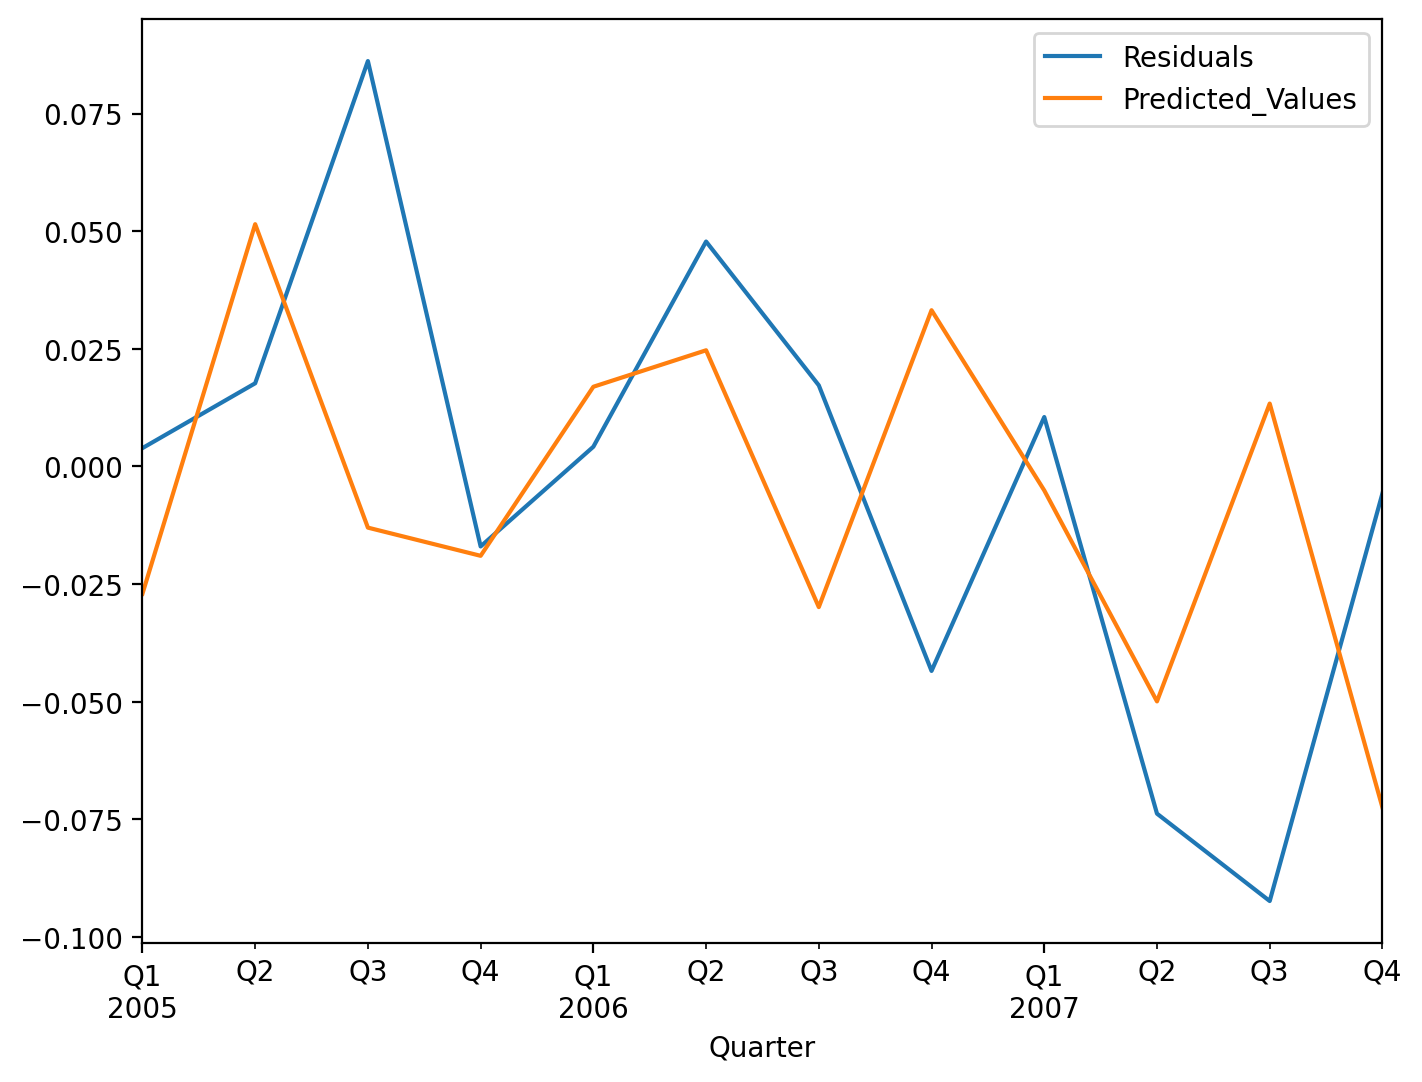

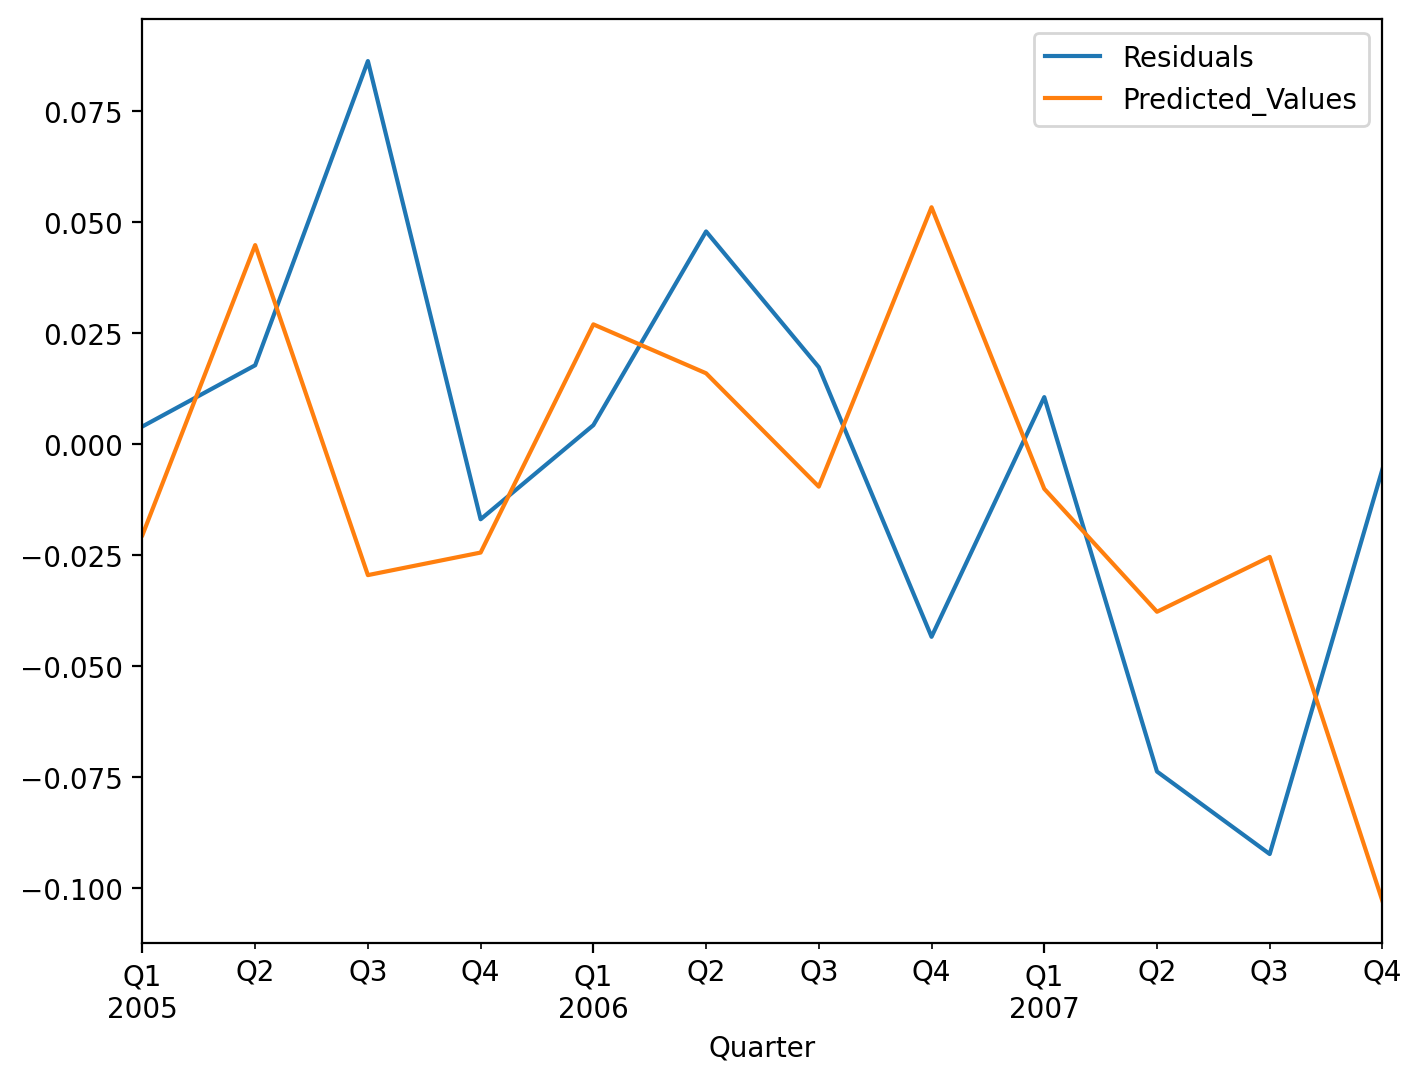

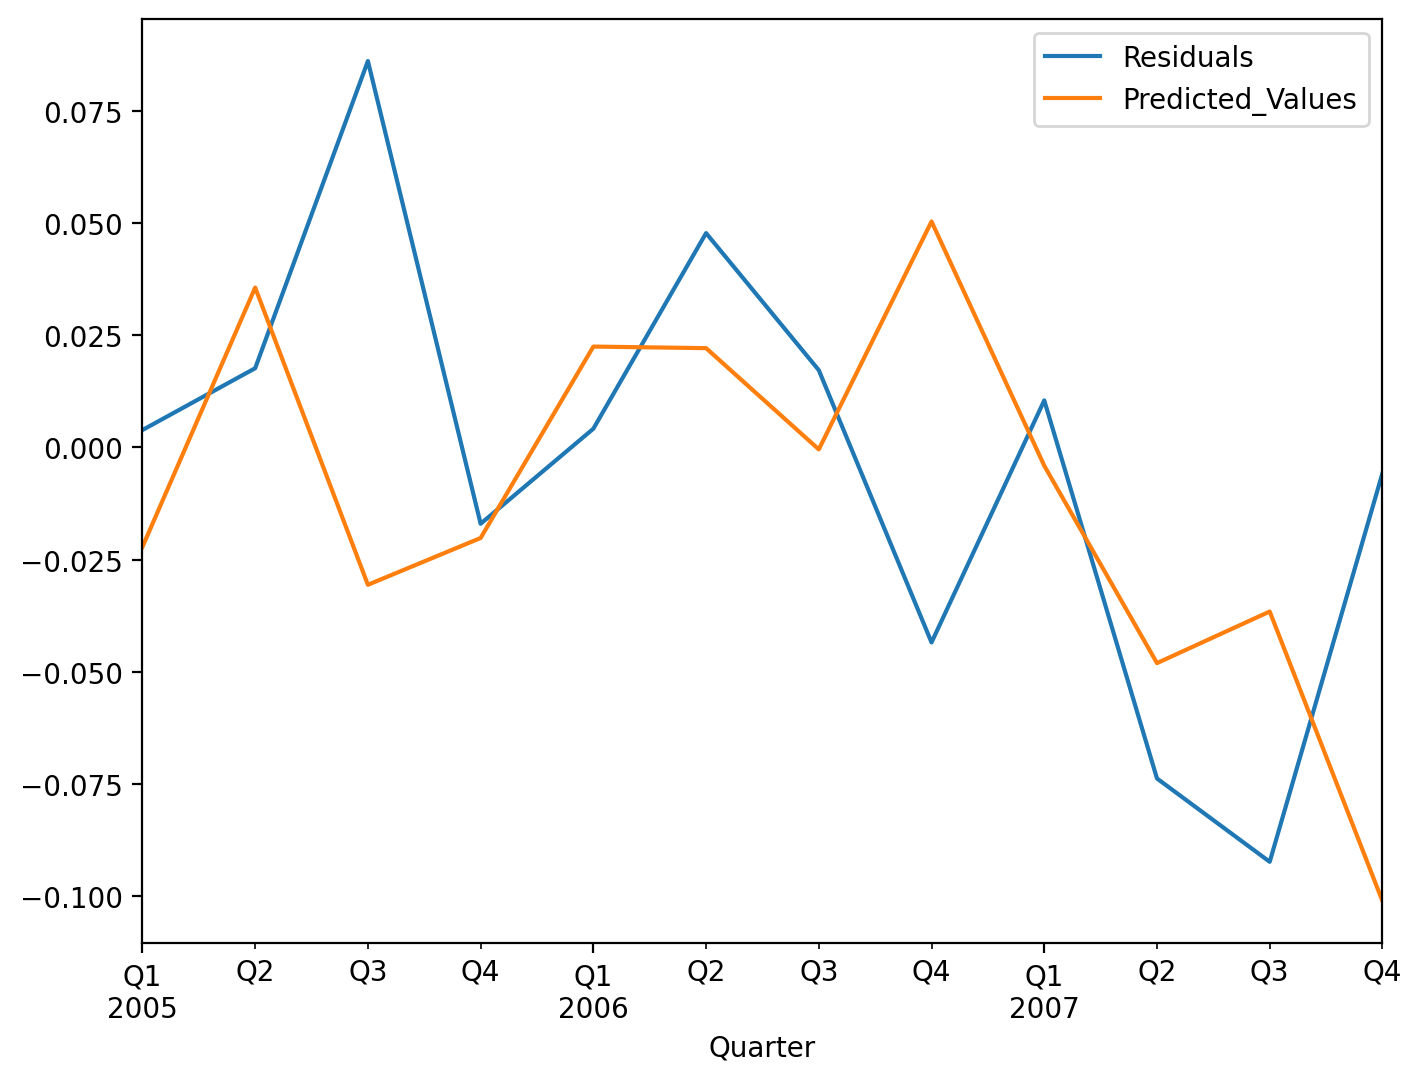

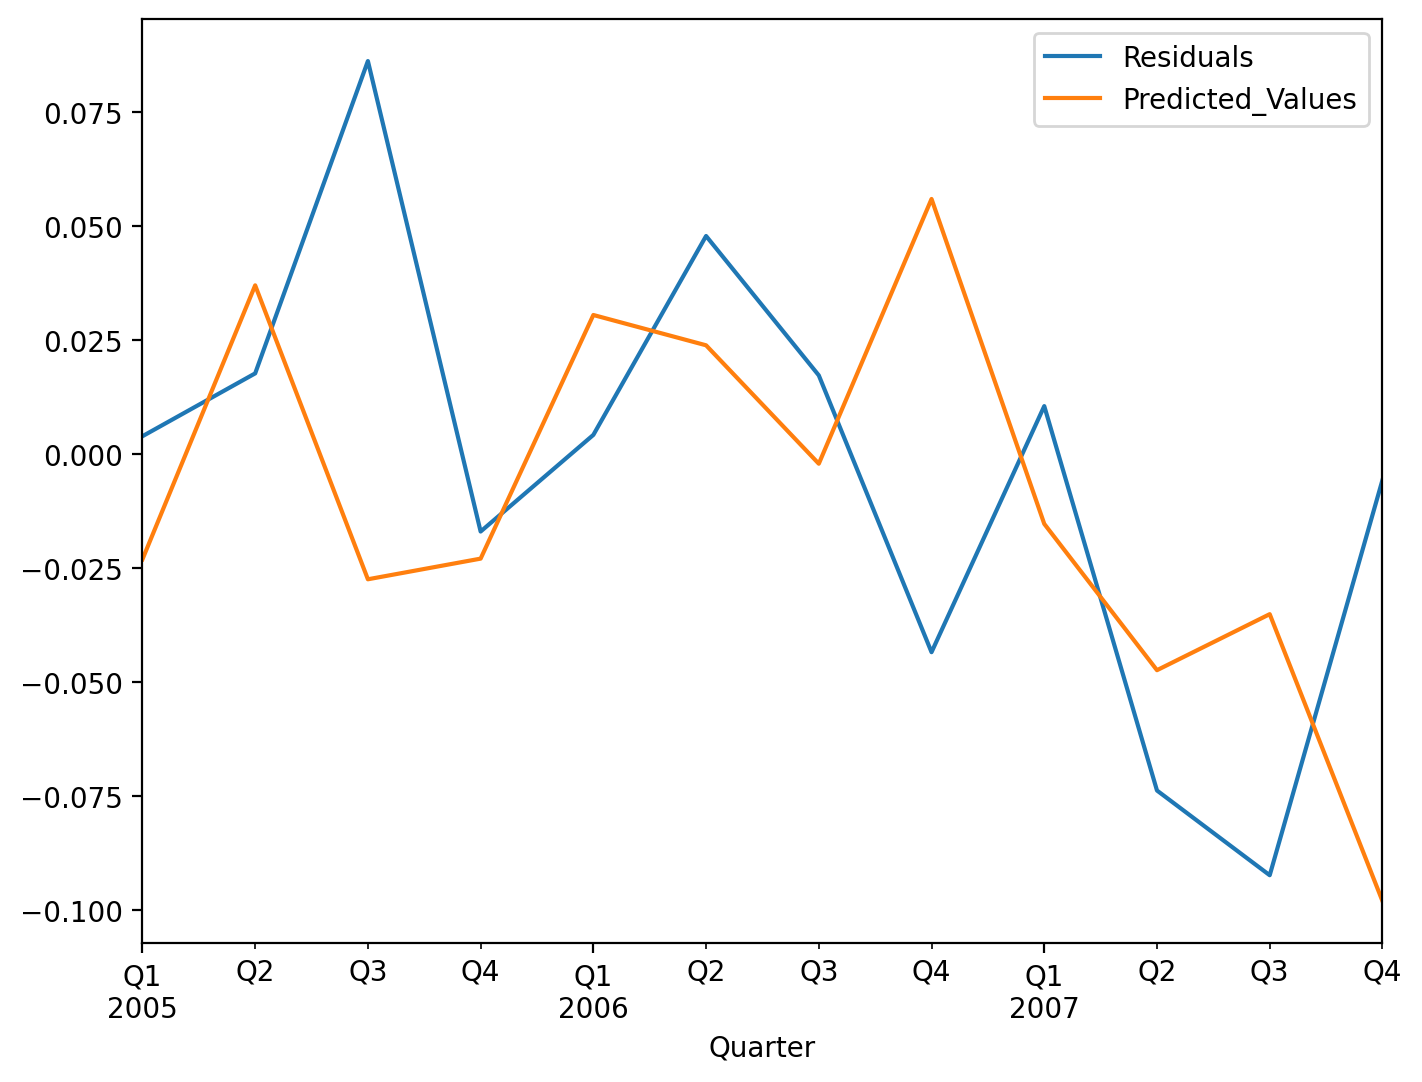

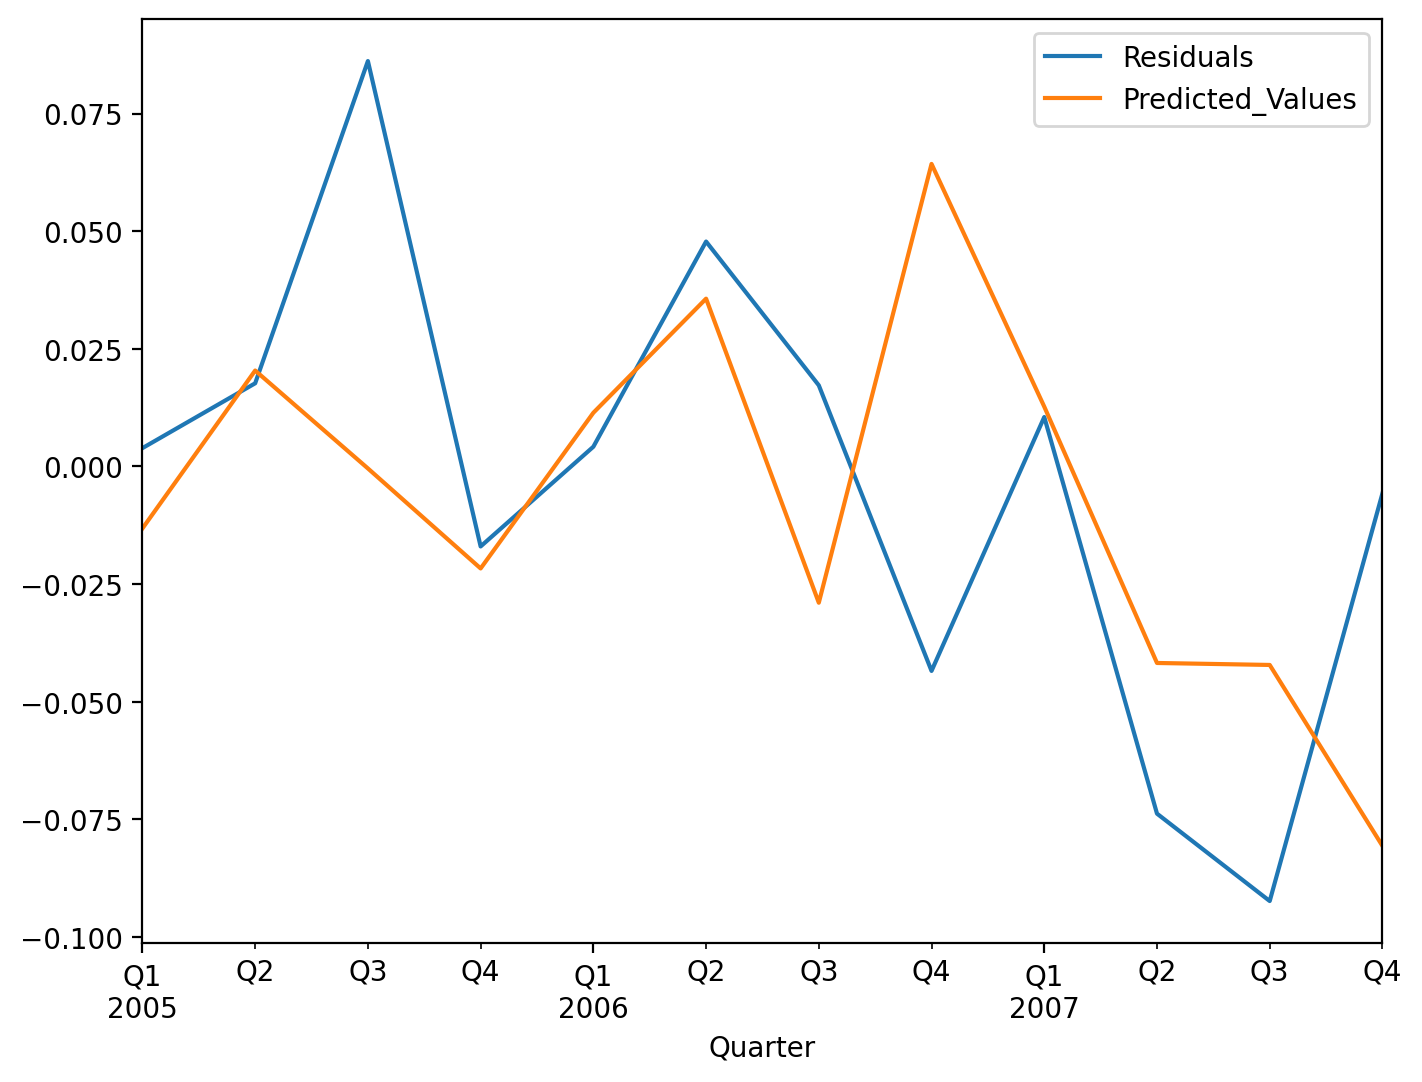

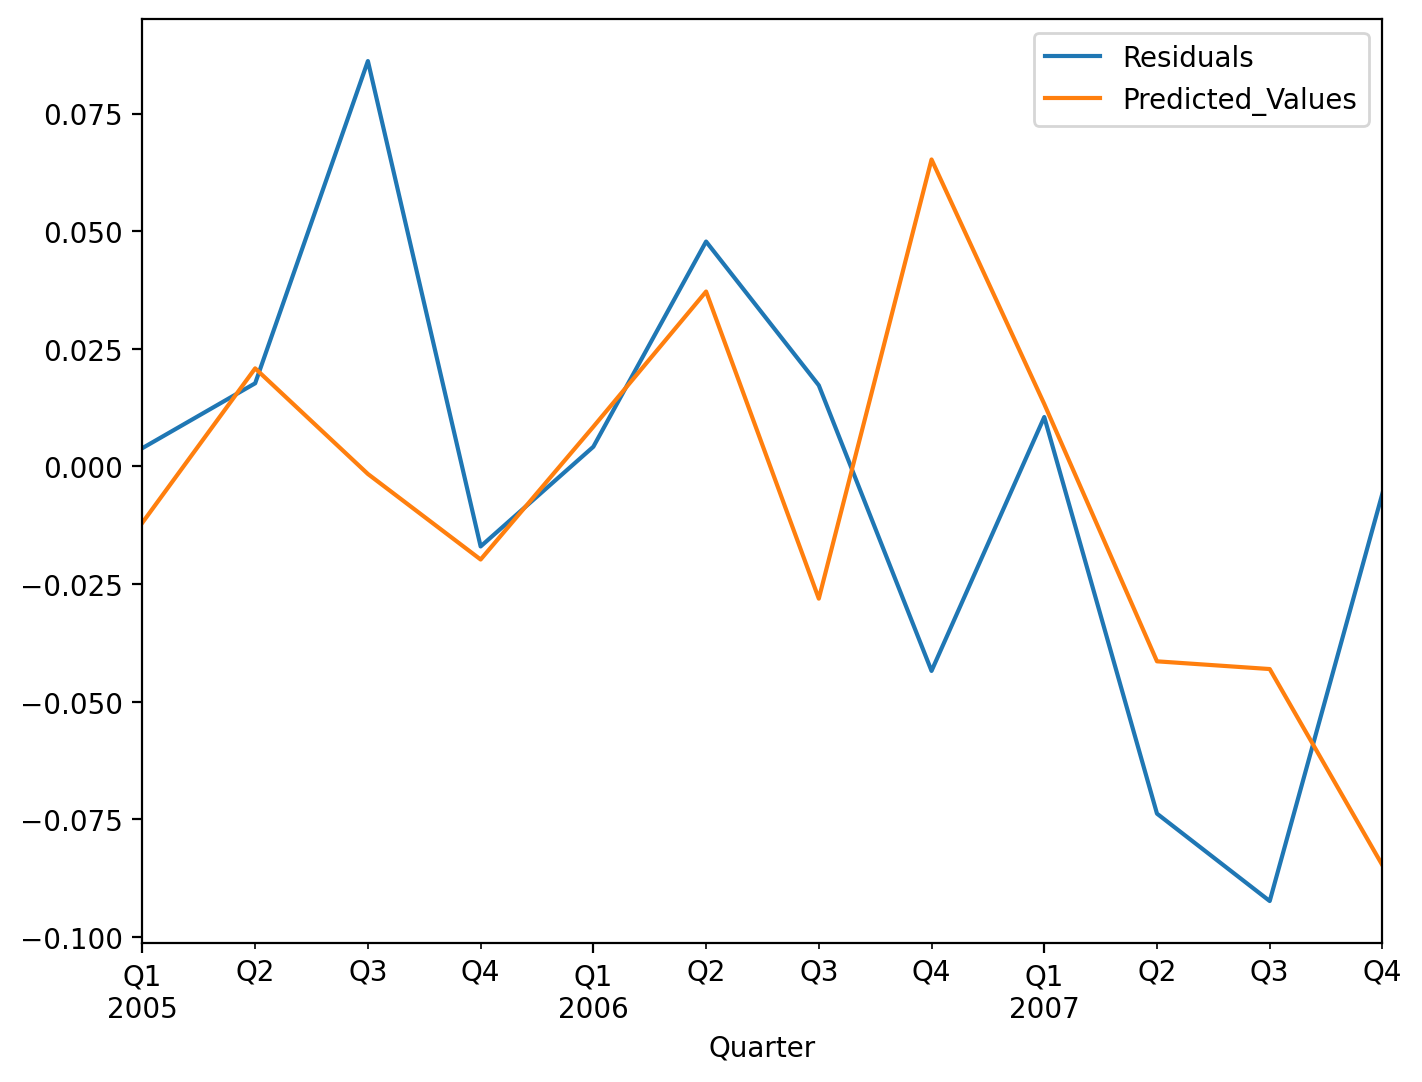

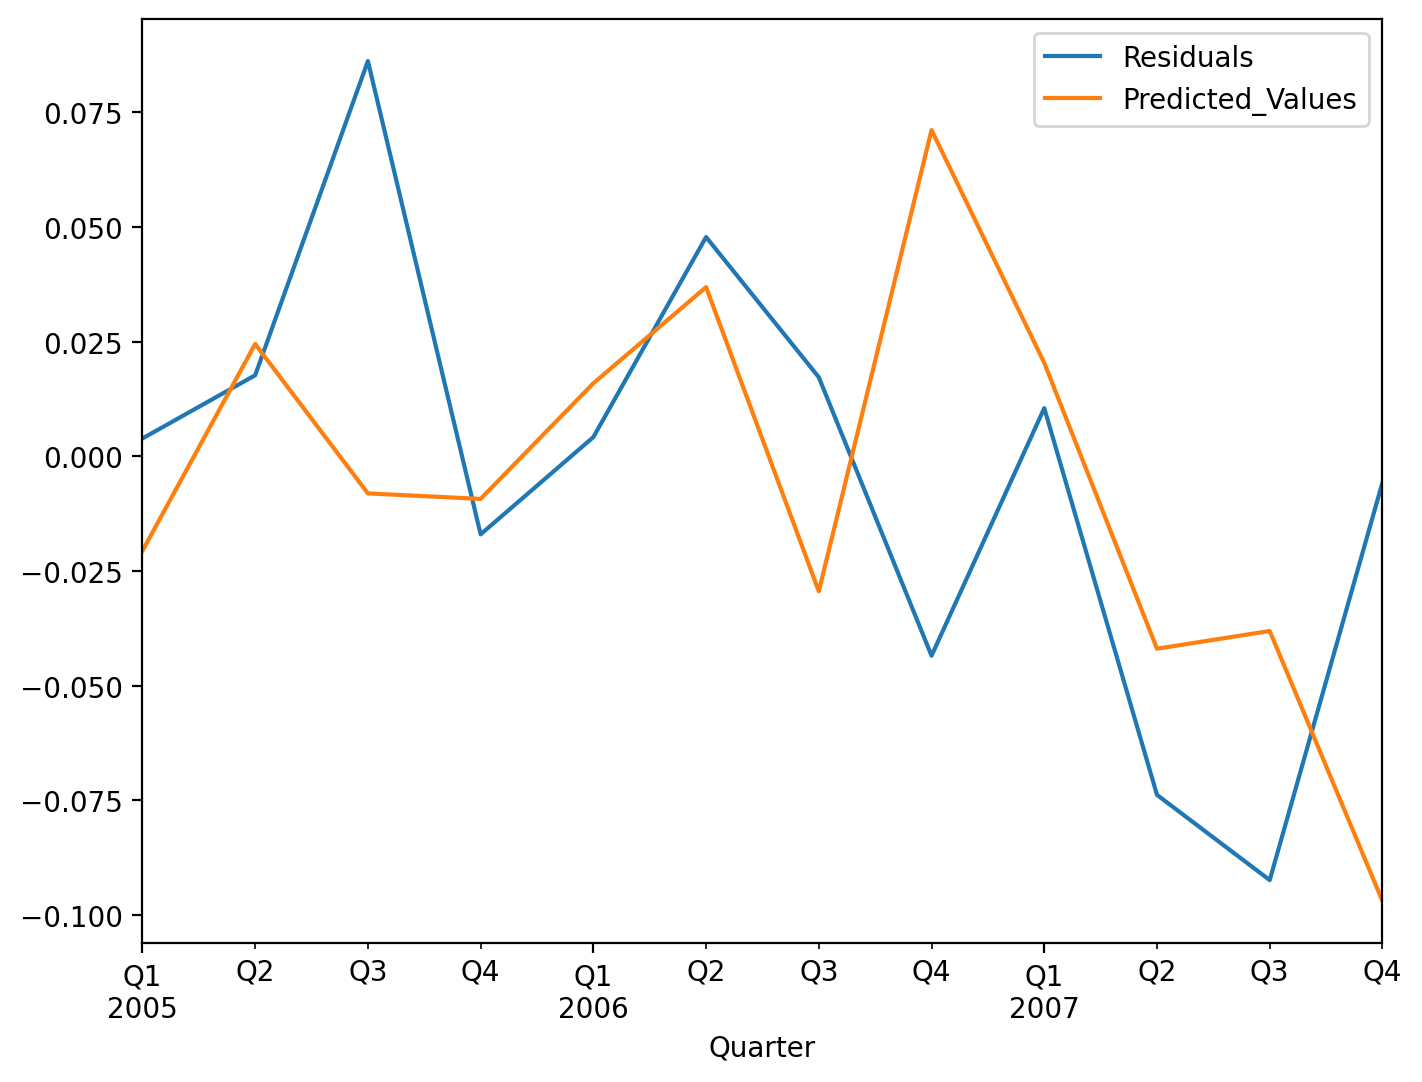

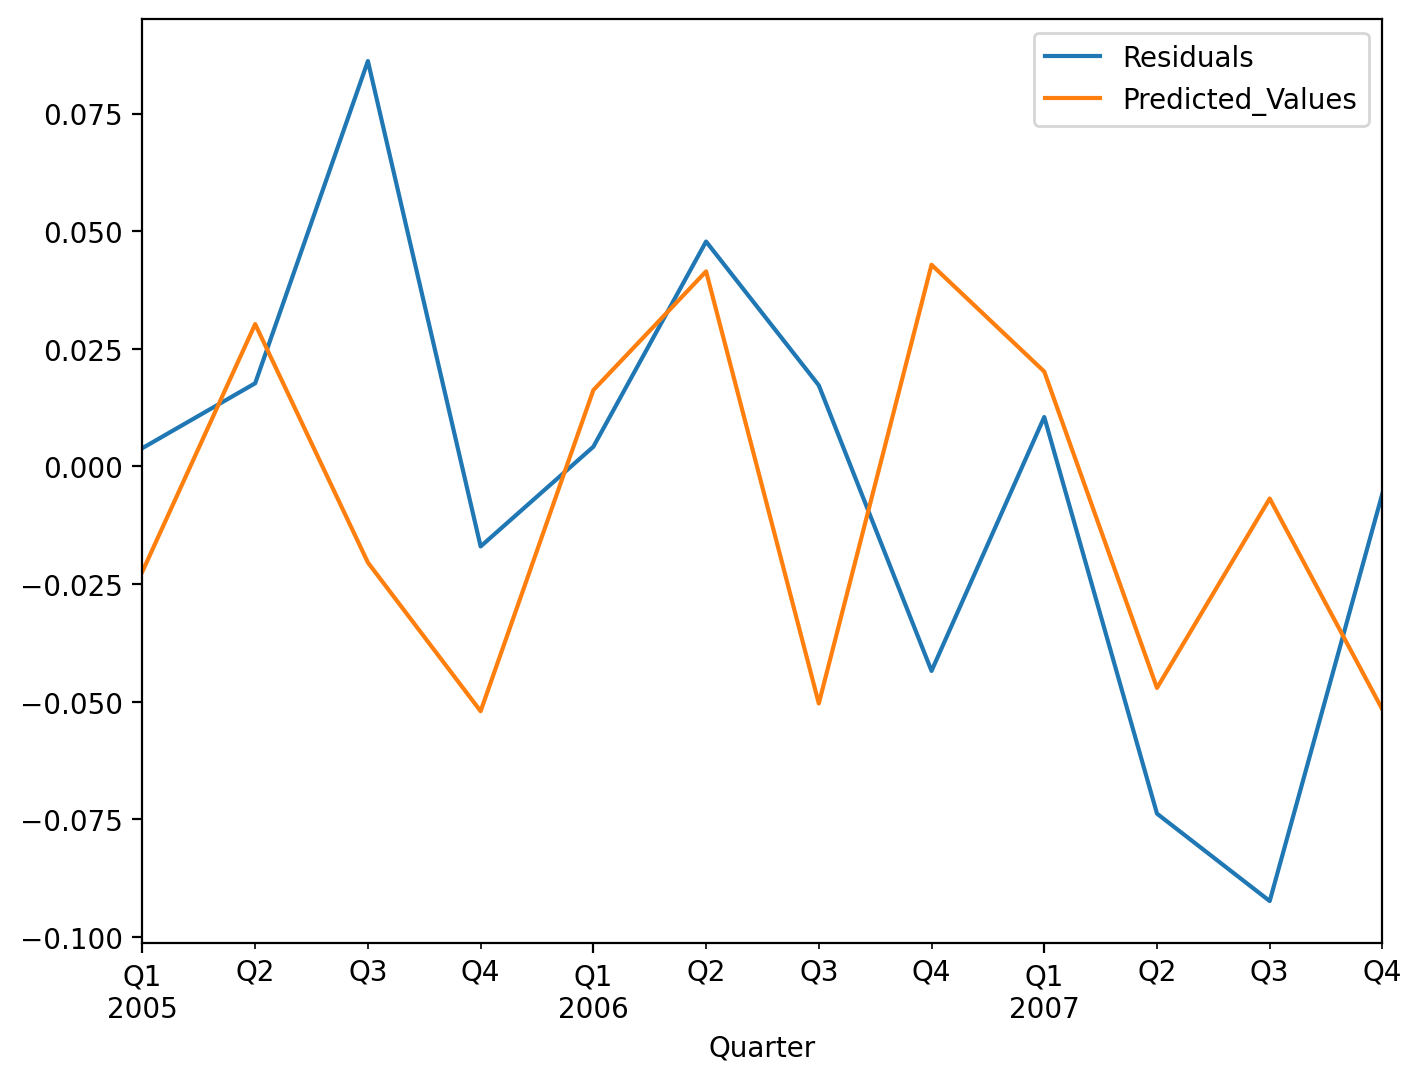

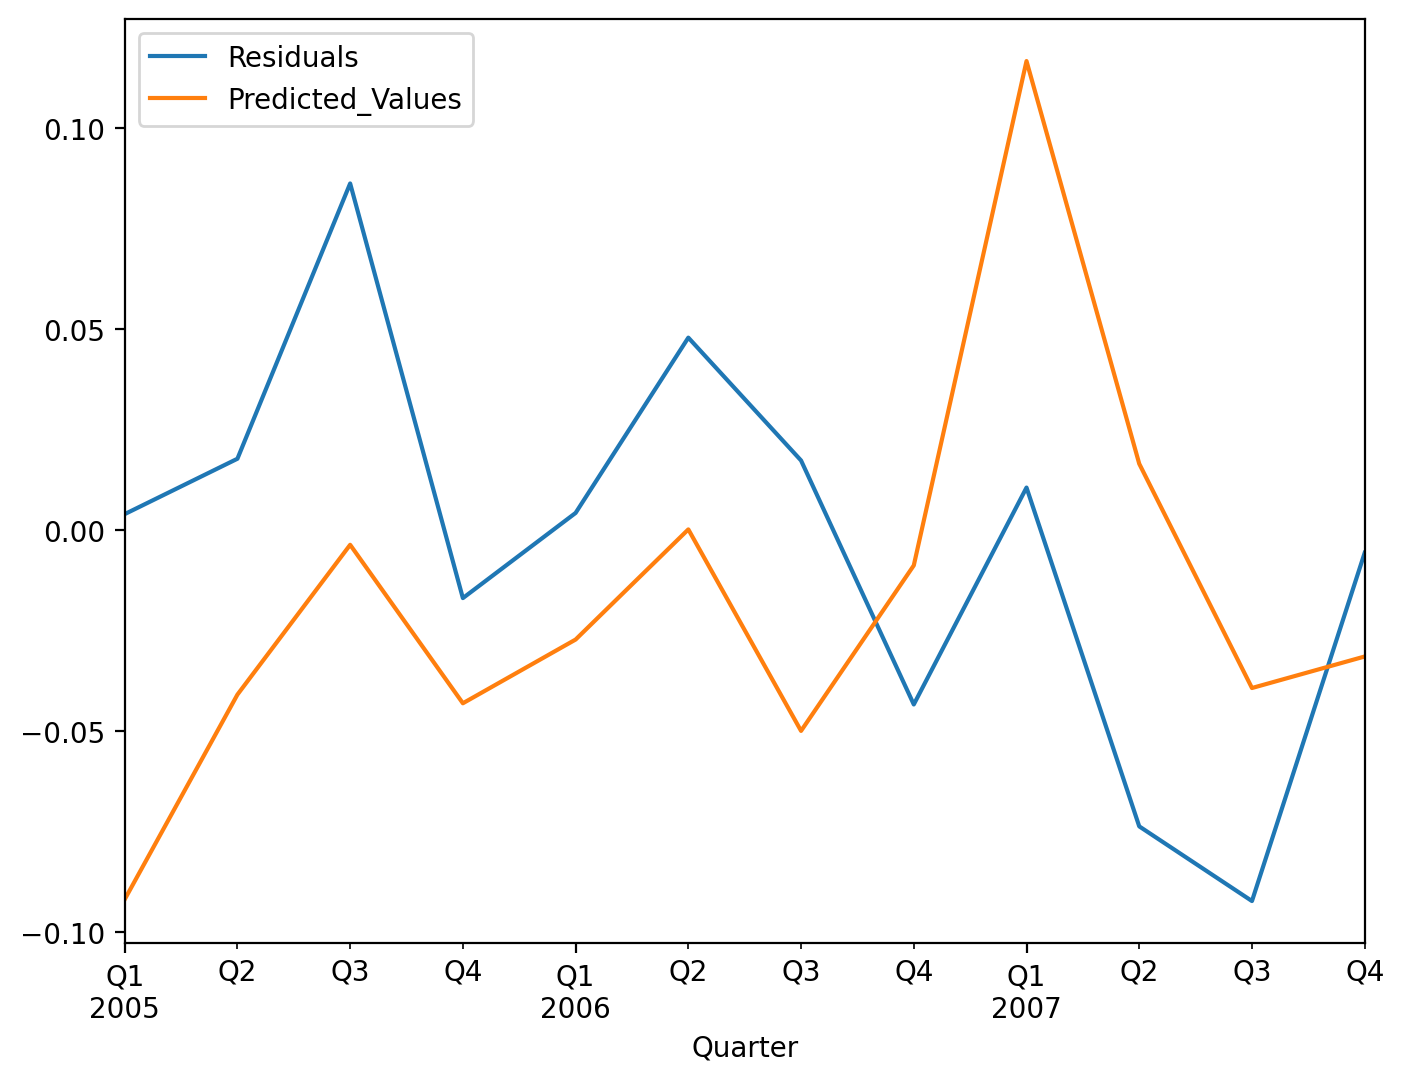

In [ ]:
r=[]
q=[]
for i in range(1,14):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  r.append(RMSE)
  q.append(i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='black', label='RMSE vs q')
plt.xlabel('q')
plt.ylabel('RMSE')
plt.title('RMSE vs q')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_q_value = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding q-value:", optimal_q_value)

Minimum RMSE: 0.046101372224288964
Corresponding q-value: 1


The RMSE is : 0.046101372224288964 , Value of q :  1


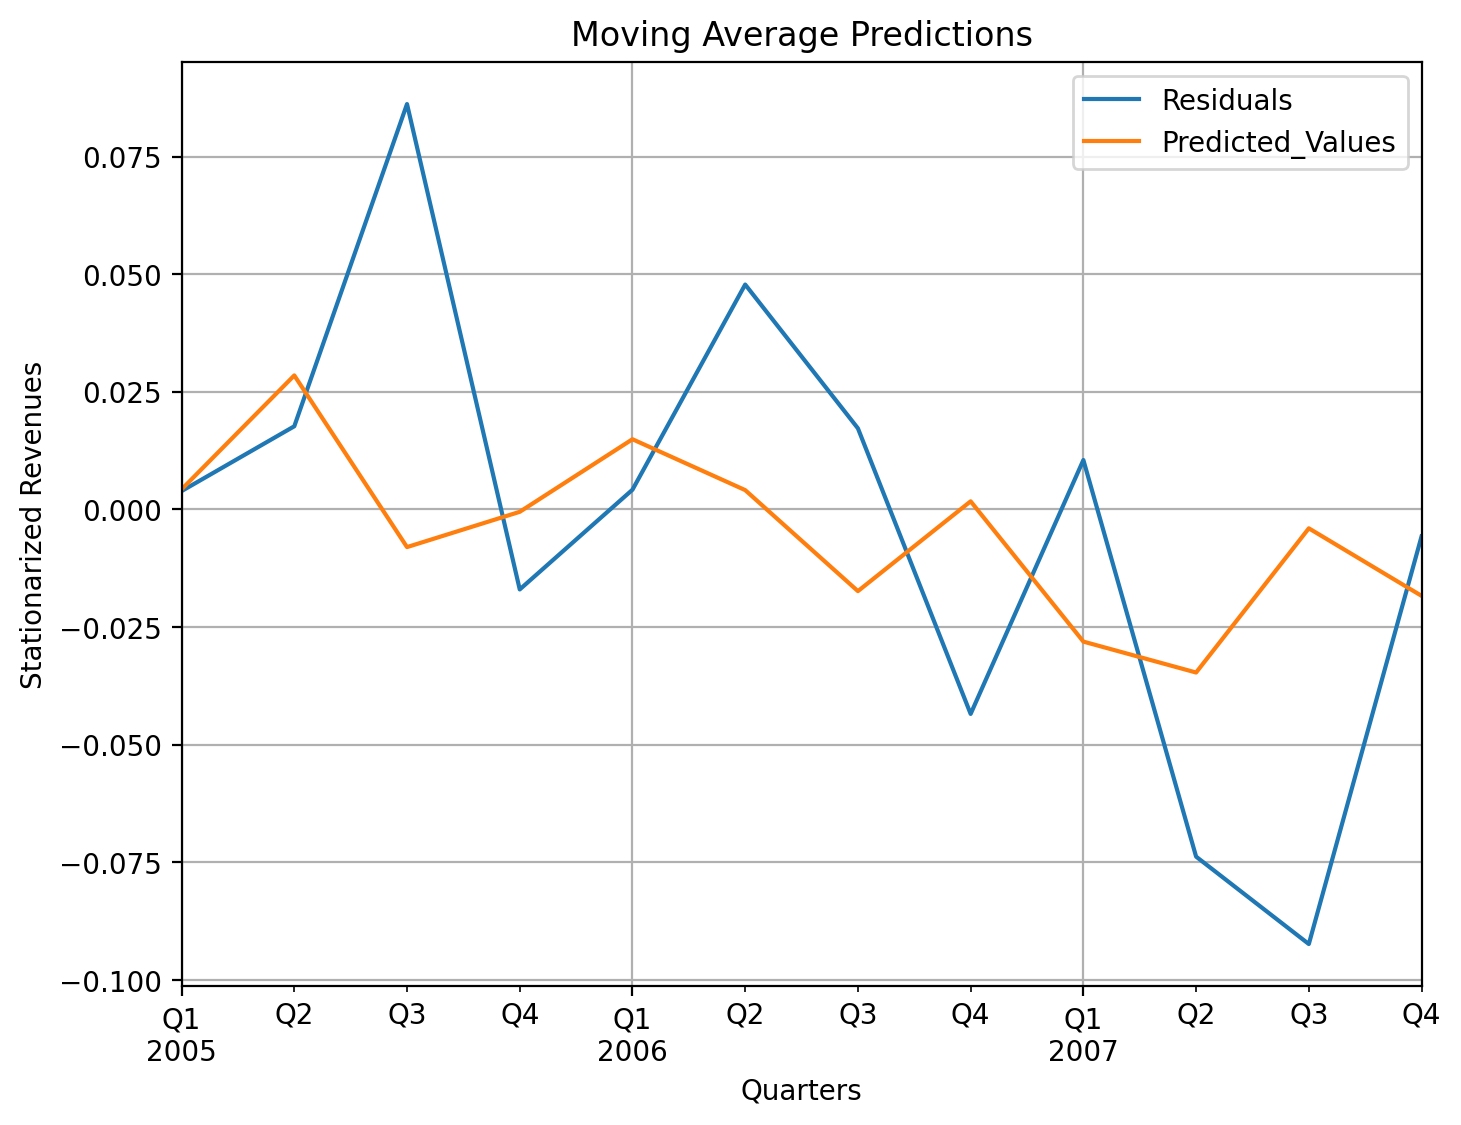

[[0.35372137]]
[-0.00199043]


In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(optimal_q_value,pd.DataFrame(res.Residuals))
plt.xlabel('Quarters')
plt.ylabel('Stationarized Revenues')
plt.title("Moving Average Predictions")
plt.legend()
plt.grid(True)
plt.show()
print(theta)
print(intercept)

In [ ]:
res_c = pd.concat([res_train,res_test])
res_c

Residuals  Shifted_values_1  Predicted_Values
Quarter                                                  
2018-09-30  -0.021389          0.039300          0.011911
2018-06-30   0.032802         -0.021389         -0.009556
2018-03-31   0.017145          0.032802          0.009612
2017-12-31  -0.029280          0.017145          0.004074
2017-09-30  -0.074300         -0.029280         -0.012348
2017-06-30  -0.074601         -0.074300         -0.028272
2017-03-31  -0.035100         -0.074601         -0.028378
2016-12-31   0.027077         -0.035100         -0.014406
2016-09-30   0.037487          0.027077          0.007587
2016-06-30   0.070961          0.037487          0.011269
2016-03-31   0.009536          0.070961          0.023110
2015-12-31  -0.003913          0.009536          0.001383
2015-09-30  -0.049106         -0.003913         -0.003375
2015-06-30  -0.015787         -0.049106         -0.019360
2015-03-31   0.012635         -0.015787         -0.007575
2014-12-31   0.044936          0.012635          0.002479
2014-09-30  -0.005377          0.044936          0.013904
2014-06-30   0.029063         -0.005377         -0.003892
2014-03-31   0.030313          0.029063          0.008290
2013-12-31  -0.001921          0.030313          0.008732
2013-09-30  -0.042828         -0.001921         -0.002670
2013-06-30  -0.022037         -0.042828         -0.017139
2013-03-31  -0.009885         -0.022037         -0.009785
2012-12-31   0.014916         -0.009885         -0.005487
2012-09-30  -0.021115          0.014916          0.003286
2012-06-30   0.012838         -0.021115         -0.009459
2012-03-31  -0.009082          0.012838          0.002551
2011-12-31  -0.007021         -0.009082         -0.005203
2011-09-30  -0.031533         -0.007021         -0.004474
2011-06-30  -0.019070         -0.031533         -0.013144
2011-03-31  -0.046579         -0.019070         -0.008736
2010-12-31  -0.012722         -0.046579         -0.018467
2010-09-30  -0.058032         -0.012722         -0.006491
2010-06-30  -0.047597         -0.058032         -0.022518
2010-03-31   0.073401         -0.047597         -0.018826
2009-12-31   0.010268          0.073401          0.023973
2009-09-30  -0.008490          0.010268          0.001642
2009-06-30  -0.016257         -0.008490         -0.004994
2009-03-31  -0.049625         -0.016257         -0.007741
2008-12-31   0.020090         -0.049625         -0.019544
2008-09-30   0.117001          0.020090          0.005116
2008-06-30   0.112880          0.117001          0.039395
2008-03-31  -0.046289          0.112880          0.037938
2007-12-31  -0.005728         -0.046289         -0.018364
2007-09-30  -0.092369         -0.005728         -0.004016
2007-06-30  -0.073792         -0.092369         -0.034663
2007-03-31   0.010497         -0.073792         -0.028092
2006-12-31  -0.043461          0.010497          0.001722
2006-09-30   0.017231         -0.043461         -0.017363
2006-06-30   0.047798          0.017231          0.004105
2006-03-31   0.004186          0.047798          0.014917
2005-12-31  -0.017004          0.004186         -0.000510
2005-09-30   0.086156         -0.017004         -0.008005
2005-06-30   0.017671          0.086156          0.028485
2005-03-31   0.003893          0.017671          0.004260

In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values

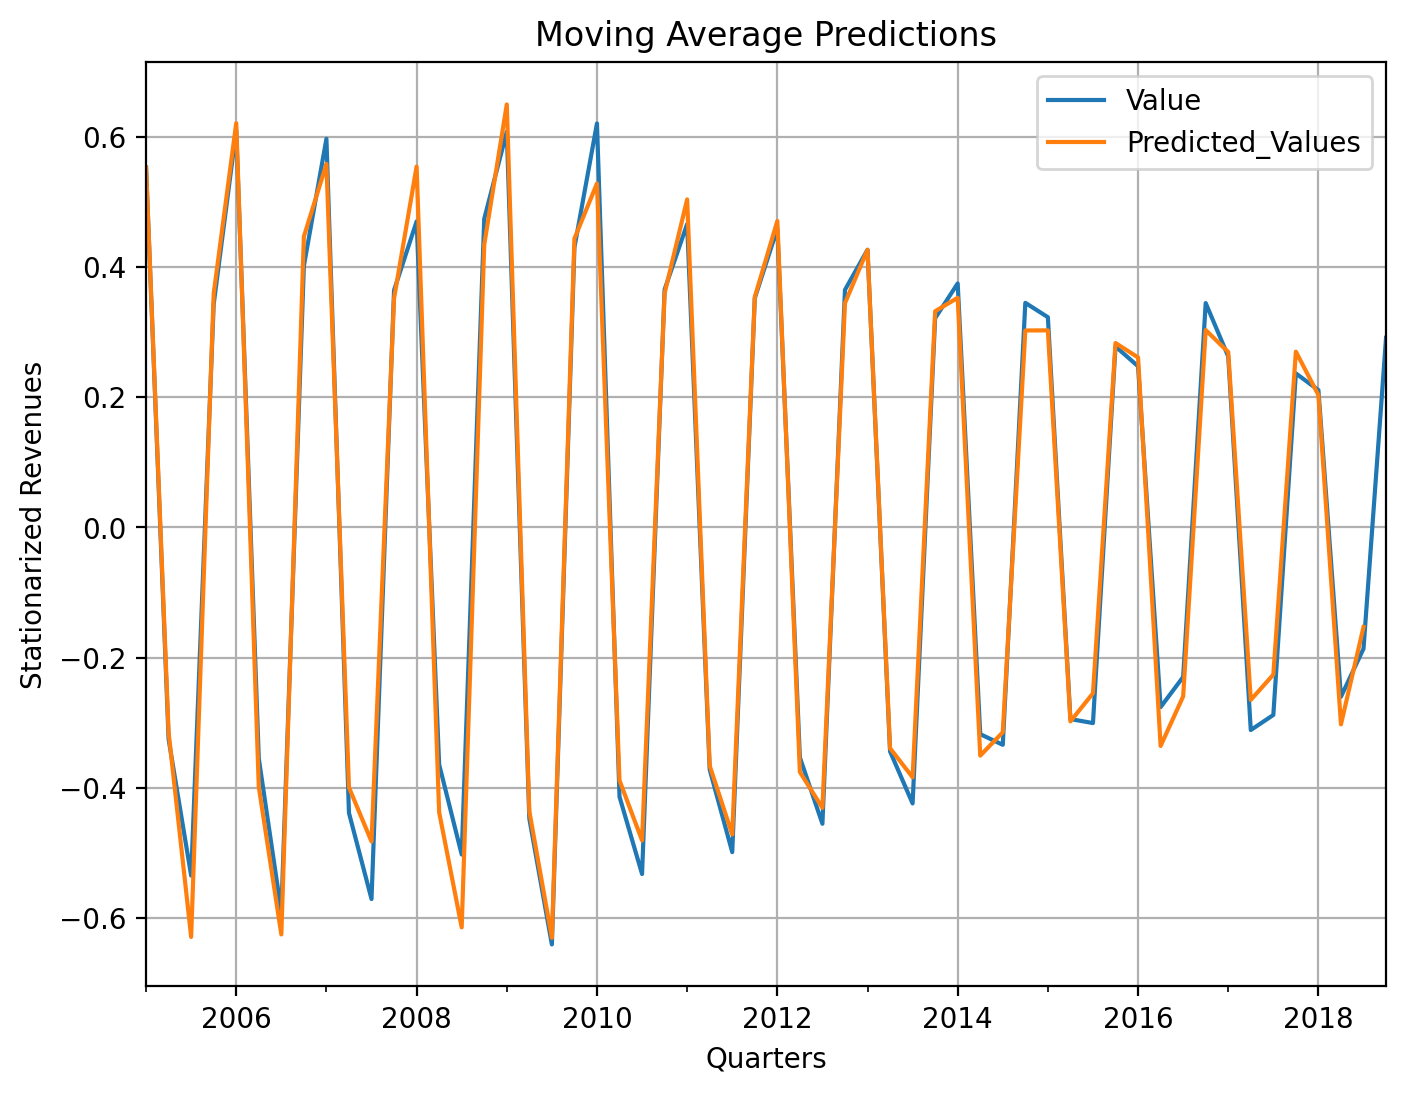

In [ ]:
df_c[['Value','Predicted_Values']].plot()
plt.xlabel('Quarters')
plt.ylabel('Stationarized Revenues')
plt.title("Moving Average Predictions")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(2).Value
df_c.Predicted_Values += np.log(df).shift(1).Value
df_c.Predicted_Values += np.log(df).diff().shift(2).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [ ]:
df_c

Value  Shifted_values_1  Shifted_values_2  Predicted_Values  \
Quarter                                                                     
2018-12-31  72383.0          0.162500         -0.246119               NaN   
2018-09-30  56576.0          0.291336          0.162500      58491.705788   
2018-06-30  52886.0         -0.186192          0.291336      50692.600566   
2018-03-31  51042.0         -0.260086         -0.186192      50658.981534   
2017-12-31  60453.0          0.210897         -0.260086      62503.380919   
2017-09-30  43744.0          0.236664          0.210897      46539.766193   
2017-06-30  37955.0         -0.288022          0.236664      39754.778868   
2017-03-31  35714.0         -0.311171         -0.288022      35954.866173   
2016-12-31  43741.0          0.262653         -0.311171      41963.591331   
2016-09-30  32714.0          0.344696          0.262653      31750.351338   
2016-06-30  30404.0         -0.229624          0.344696      28642.247788   
2016-03-31  29128.0         -0.275972         -0.229624      29526.077801   
2015-12-31  35746.0          0.247608         -0.275972      35935.816383   
2015-09-30  25358.0          0.277967          0.247608      26544.581893   
2015-06-30  23185.0         -0.300470          0.277967      23102.300606   
2015-03-31  22717.0         -0.294327         -0.300470      22262.517169   
2014-12-31  29328.0          0.322952         -0.294327      28108.875052   
2014-09-30  20579.0          0.345018          0.322952      20979.645017   
2014-06-30  19340.0         -0.333880          0.345018      18713.031421   
2014-03-31  19741.0         -0.317525         -0.333880      19310.999641   
2013-12-31  25586.0          0.374794         -0.317525      25860.025983   
2013-09-30  17092.0          0.321443          0.374794      17792.340514   
2013-06-30  15704.0         -0.423957          0.321443      15781.099814   
2013-03-31  16070.0         -0.344043         -0.423957      16071.602070   
2012-12-31  21268.0          0.426474         -0.344043      20838.468914   
2012-09-30  13806.0          0.364944          0.426474      14147.013533   
2012-06-30  12834.0         -0.455139          0.364944      12551.010510   
2012-03-31  13185.0         -0.353255         -0.455139      13339.266211   
2011-12-31  17431.0          0.459082         -0.353255      17462.724237   
2011-09-30  10876.0          0.352176          0.459082      11174.314176   
2011-06-30   9913.0         -0.498674          0.352176       9971.914374   
2011-03-31   9857.0         -0.371882         -0.498674      10237.171935   
2010-12-31  12947.0          0.466027         -0.371882      12872.843162   
2010-09-30   7560.0          0.365394          0.466027       7959.870753   
2010-06-30   6566.0         -0.532328          0.365394       6732.751779   
2010-03-31   7131.0         -0.413649         -0.532328       6502.739727   
2009-12-31   9520.0          0.620540         -0.413649       9651.368297   
2009-09-30   5449.0          0.429910          0.620540       5504.490904   
2009-06-30   4651.0         -0.640509          0.429910       4703.679801   
2009-03-31   4889.0         -0.447293         -0.640509       5098.120228   
2008-12-31   6704.0          0.607868         -0.447293       6443.489649   
2008-09-30   4264.0          0.474066          0.607868       3812.642363   
2008-06-30   4063.0         -0.502402          0.474066       3775.137735   
2008-03-31   4135.0         -0.364003         -0.502402       4498.363951   
2007-12-31   5672.0          0.470062         -0.364003       5600.779812   
2007-09-30   3262.0          0.364341          0.470062       3563.322583   
2007-06-30   2886.0         -0.570767          0.364341       3001.163044   
2007-03-31   3015.0         -0.438524         -0.570767       2900.870648   
2006-12-31   3986.0          0.596930         -0.438524       4170.231928   
2006-09-30   2307.0          0.401657          0.596930       2228.554742   
2006-06-30

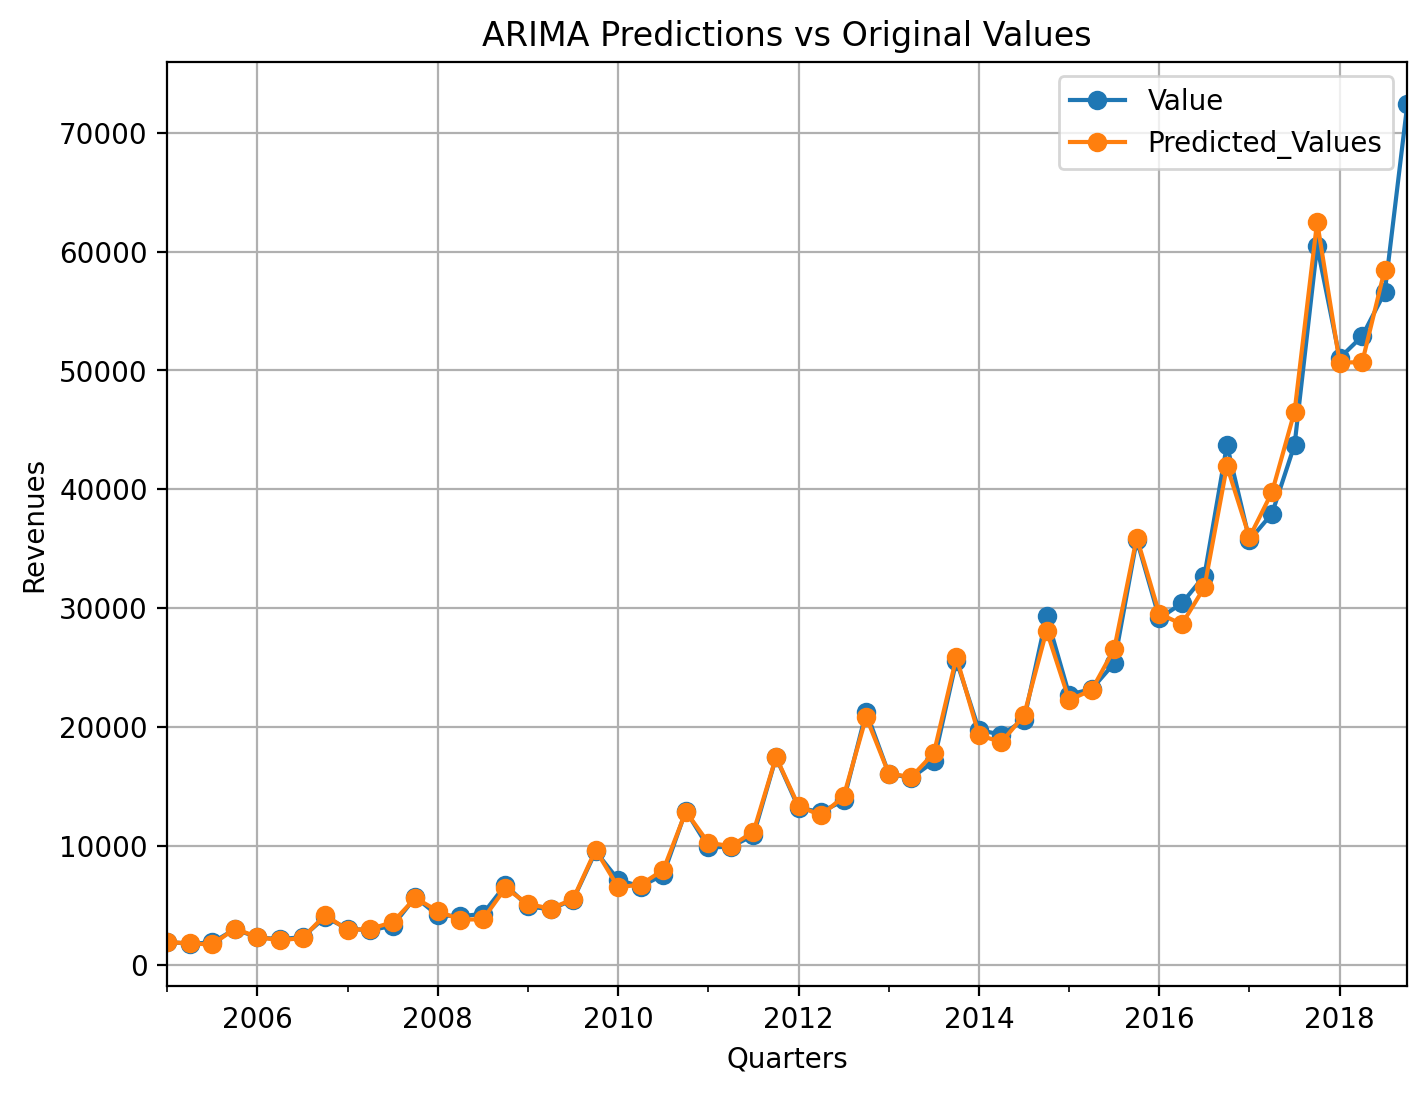

In [ ]:
df_c.iloc[:,:][['Value','Predicted_Values']].plot(marker='o', linestyle='-',label='Rev vs Quarter')
plt.xlabel('Quarters')
plt.ylabel('Revenues')
plt.title("ARIMA Predictions vs Original Values")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Mean_RMSE_ARIMA=((df_c.Value - df_c.Predicted_Values) ** 2).mean() ** .5

In [ ]:
print("The Mean Root-Mean-Square Error in ARIMA:",Mean_RMSE_ARIMA)

The Mean Root-Mean-Square Error in ARIMA: 828.3035220025573


MOVING AVERAGE TESTING

In [ ]:
df_new_1 = pd.read_excel("MM25.xlsx")

df_new_1.drop(['Net Income (US $M)'],axis=1,inplace=True)
df_new_1.rename(columns = {'Revenue (US $M)':'Value'}, inplace = True)

def convert_to_int(value):
    return int(value.replace('$', '').replace(',', ''))

# Apply the function to the 'profit' column
df_new_1['Value'] = df_new_1['Value'].apply(convert_to_int)

df_new_1.set_index('Quarter',inplace=True)

df_new_1

Value
Quarter          
2020-03-31  75452
2019-12-31  87437
2019-09-30  69981
2019-06-30  63404
2019-03-31  59700
...           ...
2006-03-31   2279
2005-12-31   2977
2005-09-30   1858
2005-06-30   1753
2005-03-31   1902

[61 rows x 1 columns]

In [ ]:
import pandas as pd


data = df_new_1


df = pd.DataFrame(data)


df = df.rename(columns={"Value": "Revenue"})
df

Revenue
Quarter            
2020-03-31    75452
2019-12-31    87437
2019-09-30    69981
2019-06-30    63404
2019-03-31    59700
...             ...
2006-03-31     2279
2005-12-31     2977
2005-09-30     1858
2005-06-30     1753
2005-03-31     1902

[61 rows x 1 columns]

The RMSE is : 3817.144328287249 , Value of window size :  3
The RMSE is : 4278.530545436453 , Value of window size :  4
The RMSE is : 4146.384252384365 , Value of window size :  5
The RMSE is : 4783.102542030577 , Value of window size :  6
The RMSE is : 5685.602164201544 , Value of window size :  7
The RMSE is : 6221.336493219397 , Value of window size :  8
The RMSE is : 6516.178905003498 , Value of window size :  9
The RMSE is : 7098.483905926131 , Value of window size :  10
The RMSE is : 7977.292797654921 , Value of window size :  11


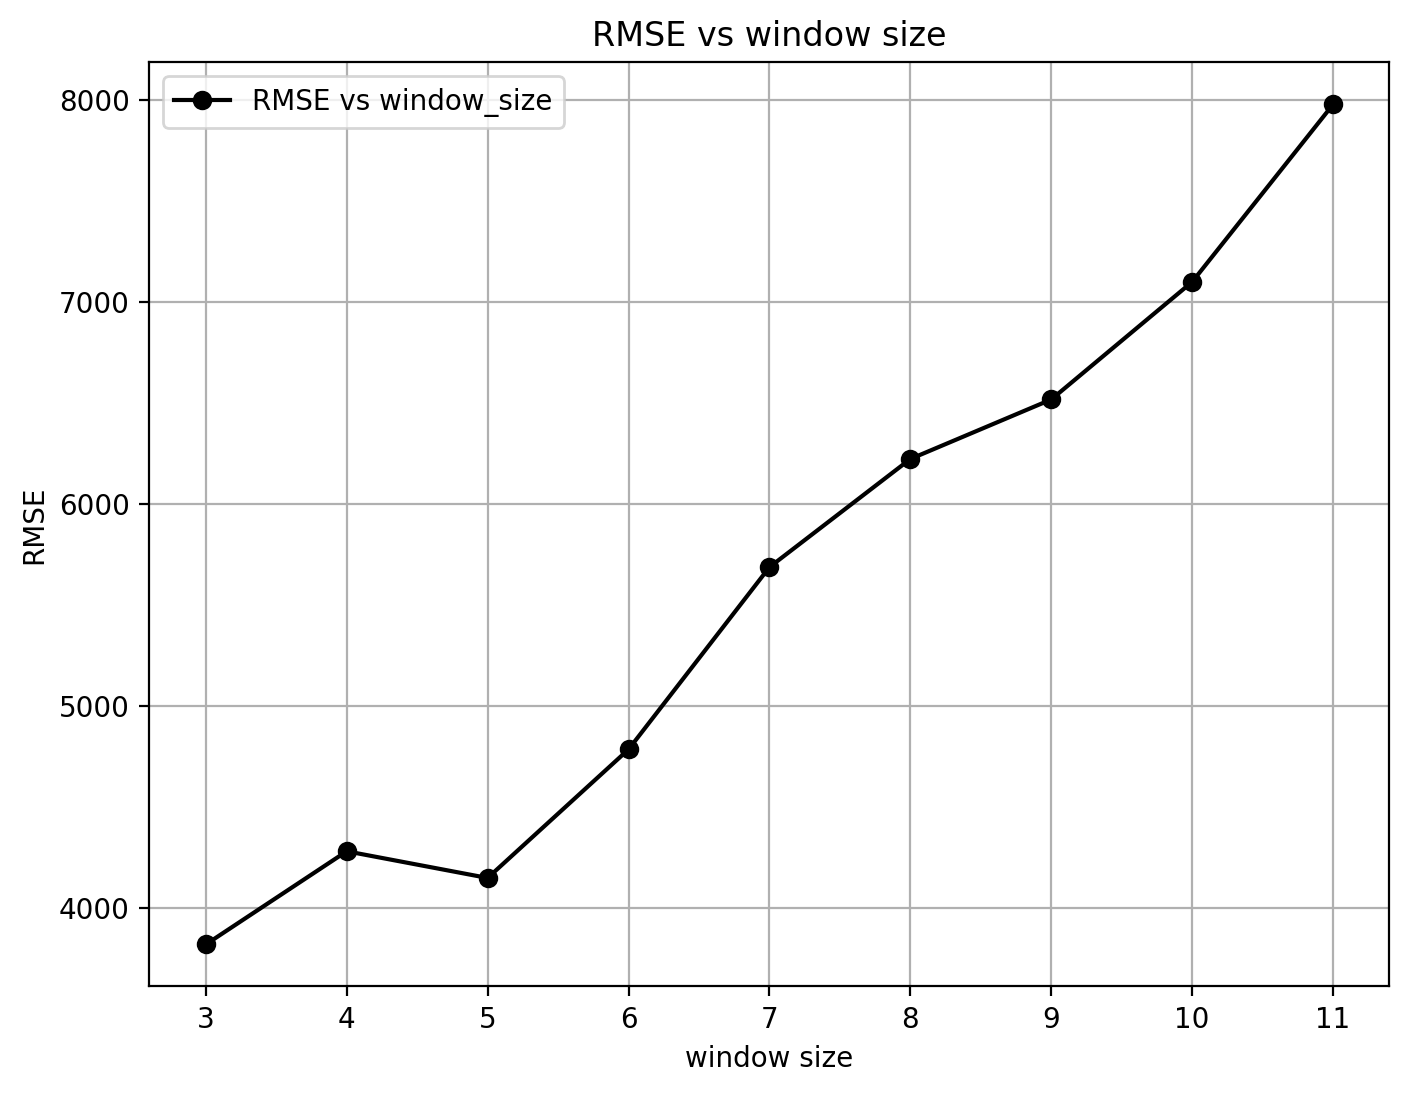

In [ ]:
q=[]
r=[]
for i in range(3,12):
  predicted_values = df_new_1['Value'].rolling(window=i).mean()
  rmse_score_i=((df_new_1.Value - predicted_values) ** 2).mean() ** .5
  r.append(rmse_score_i)
  q.append(i)
  print("The RMSE is :", rmse_score_i,", Value of window size : ",i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='black', label='RMSE vs window_size')
plt.xlabel('window size')
plt.ylabel('RMSE')
plt.title('RMSE vs window size')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_q_value = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding window_size-value:", optimal_q_value)

Minimum RMSE: 3817.144328287249
Corresponding window_size-value: 3


The RMSE is : 4783.102542030577 , Value of window size :  6
The RMSE is : 5685.602164201544 , Value of window size :  7
The RMSE is : 6221.336493219397 , Value of window size :  8
The RMSE is : 6516.178905003498 , Value of window size :  9
The RMSE is : 7098.483905926131 , Value of window size :  10
The RMSE is : 7977.292797654921 , Value of window size :  11


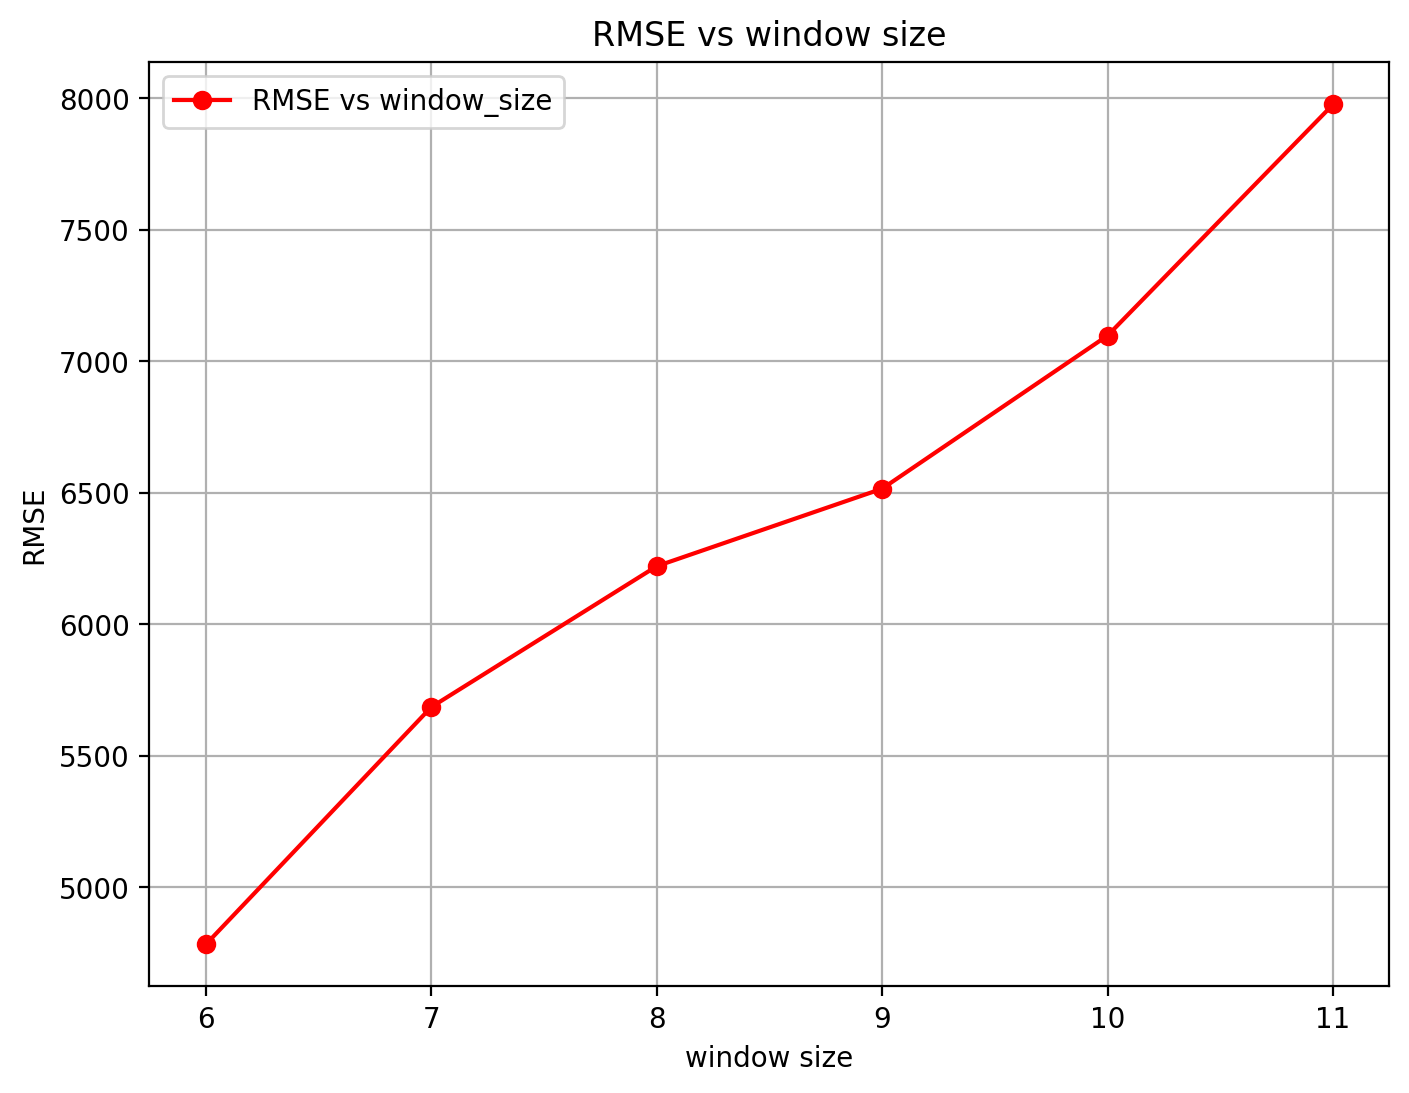

In [ ]:
q=[]
r=[]
for i in range(6,12):
  predicted_values = df_new_1['Value'].rolling(window=i).mean()
  rmse_score_i=((df_new_1.Value - predicted_values) ** 2).mean() ** .5
  r.append(rmse_score_i)
  q.append(i)
  print("The RMSE is :", rmse_score_i,", Value of window size : ",i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='red', label='RMSE vs window_size')
plt.xlabel('window size')
plt.ylabel('RMSE')
plt.title('RMSE vs window size')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_q_value_1 = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding window_size-value:", optimal_q_value_1)

Minimum RMSE: 4783.102542030577
Corresponding window_size-value: 6


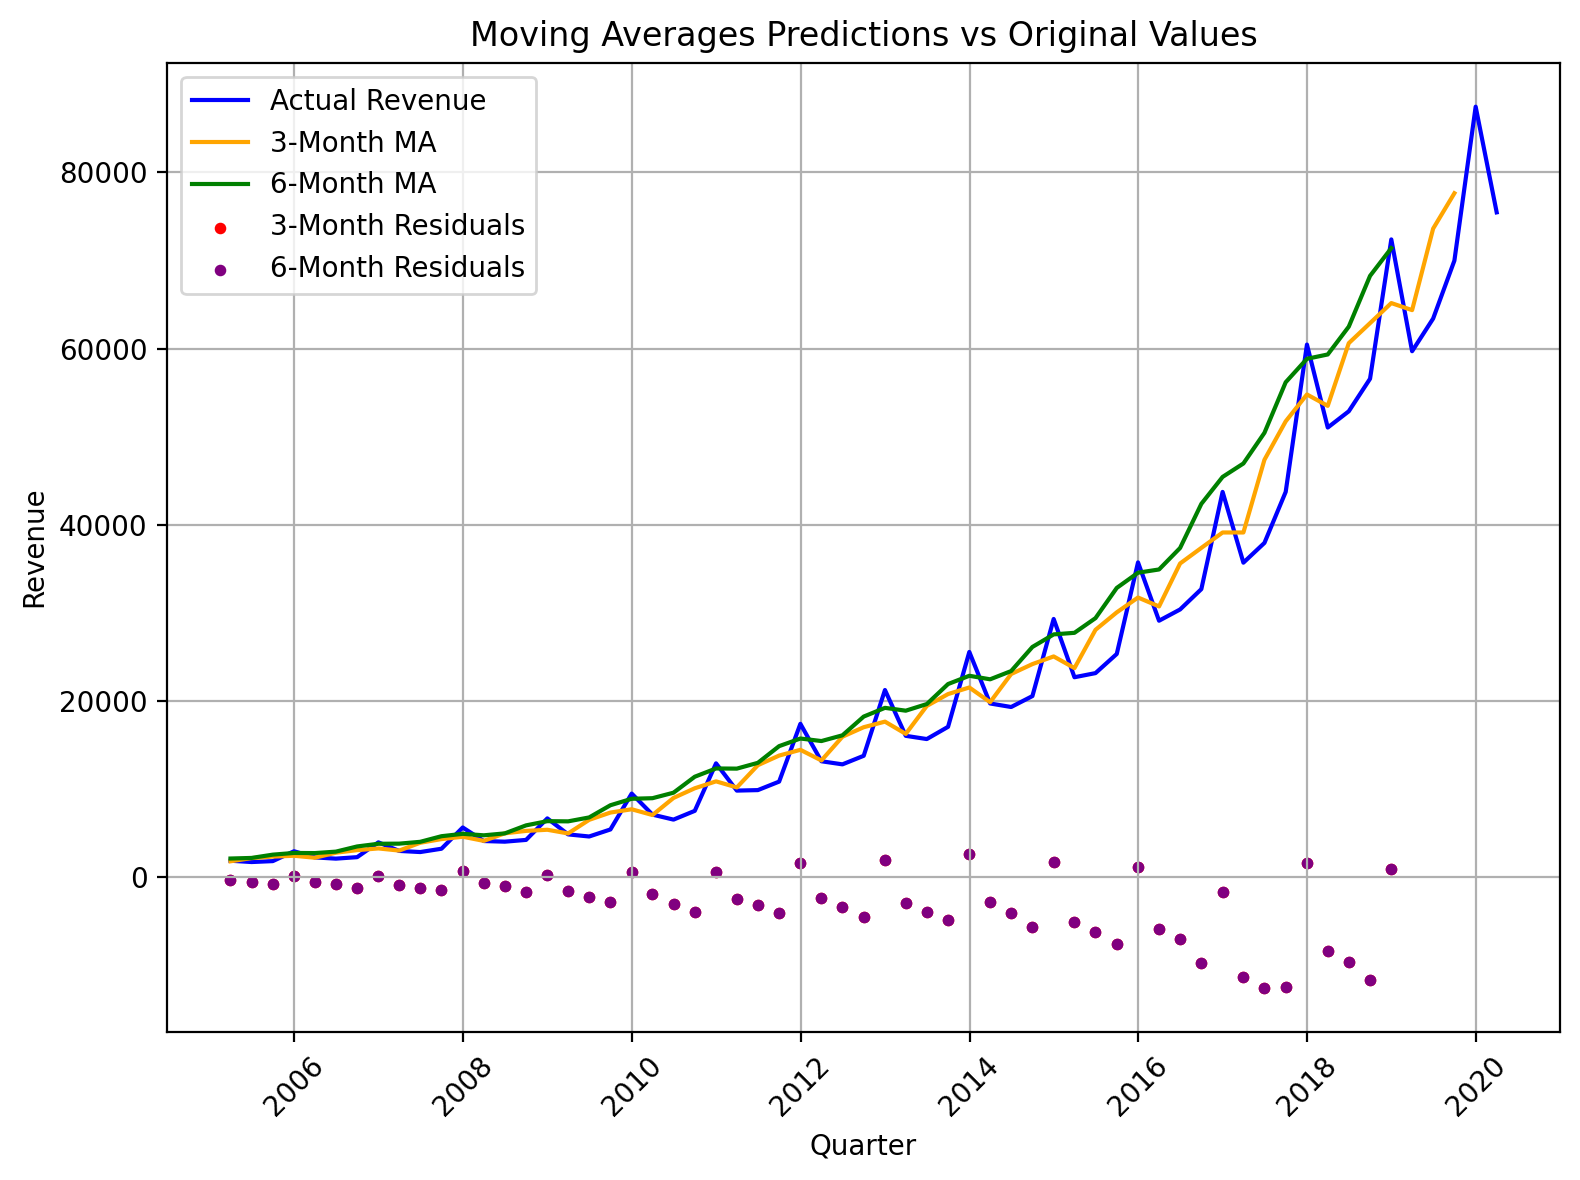

In [ ]:
import matplotlib.pyplot as plt
df_new_1['MA_3'] = df_new_1['Value'].rolling(window=optimal_q_value).mean()
df_new_1['MA_6'] = df_new_1['Value'].rolling(window=optimal_q_value_1).mean()


# Calculate residuals for both moving averages
df_new_1['Residuals_MA_3'] = df_new_1['Value'] - df_new_1['MA_3']
df_new_1['Residuals_MA_6'] = df_new_1['Value'] - df_new_1['MA_6']

# Plotting the actual, predicted, and residuals


# Actual Revenue
plt.plot(df_new_1.index, df_new_1['Value'], label='Actual Revenue', color='blue')

# Predicted Revenue (Moving Averages)
plt.plot(df_new_1.index, df_new_1['MA_3'], label='3-Month MA', color='orange')
plt.plot(df_new_1.index, df_new_1['MA_6'], label='6-Month MA', color='green')

# Residuals for the 3-month moving average
plt.scatter(df_new_1.index, df_new_1['Residuals_MA_6'], label='3-Month Residuals', color='red', s=10)

# Residuals for the 6-month moving average
plt.scatter(df_new_1.index, df_new_1['Residuals_MA_6'], label='6-Month Residuals', color='purple', s=10)

plt.title('Moving Averages Predictions vs Original Values')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the plot
plt.show()

In [ ]:
from scipy import stats

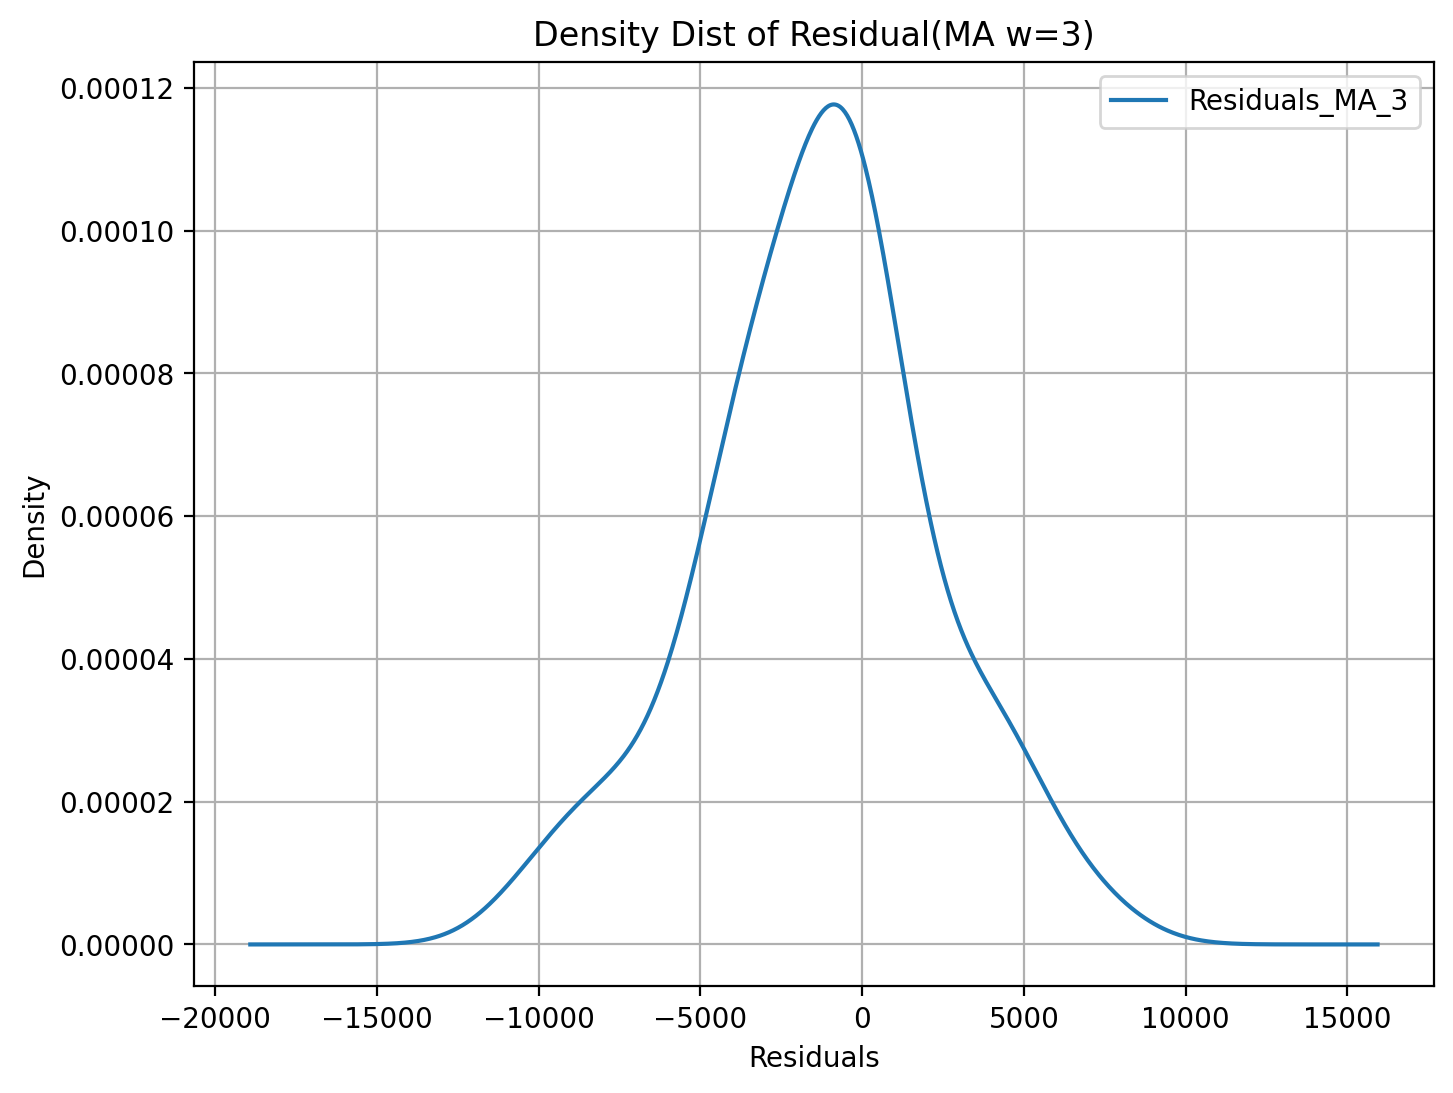

In [ ]:
df_new_1['Residuals_MA_3'].plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(MA w=3)")
plt.legend()
plt.grid(True)
plt.show()

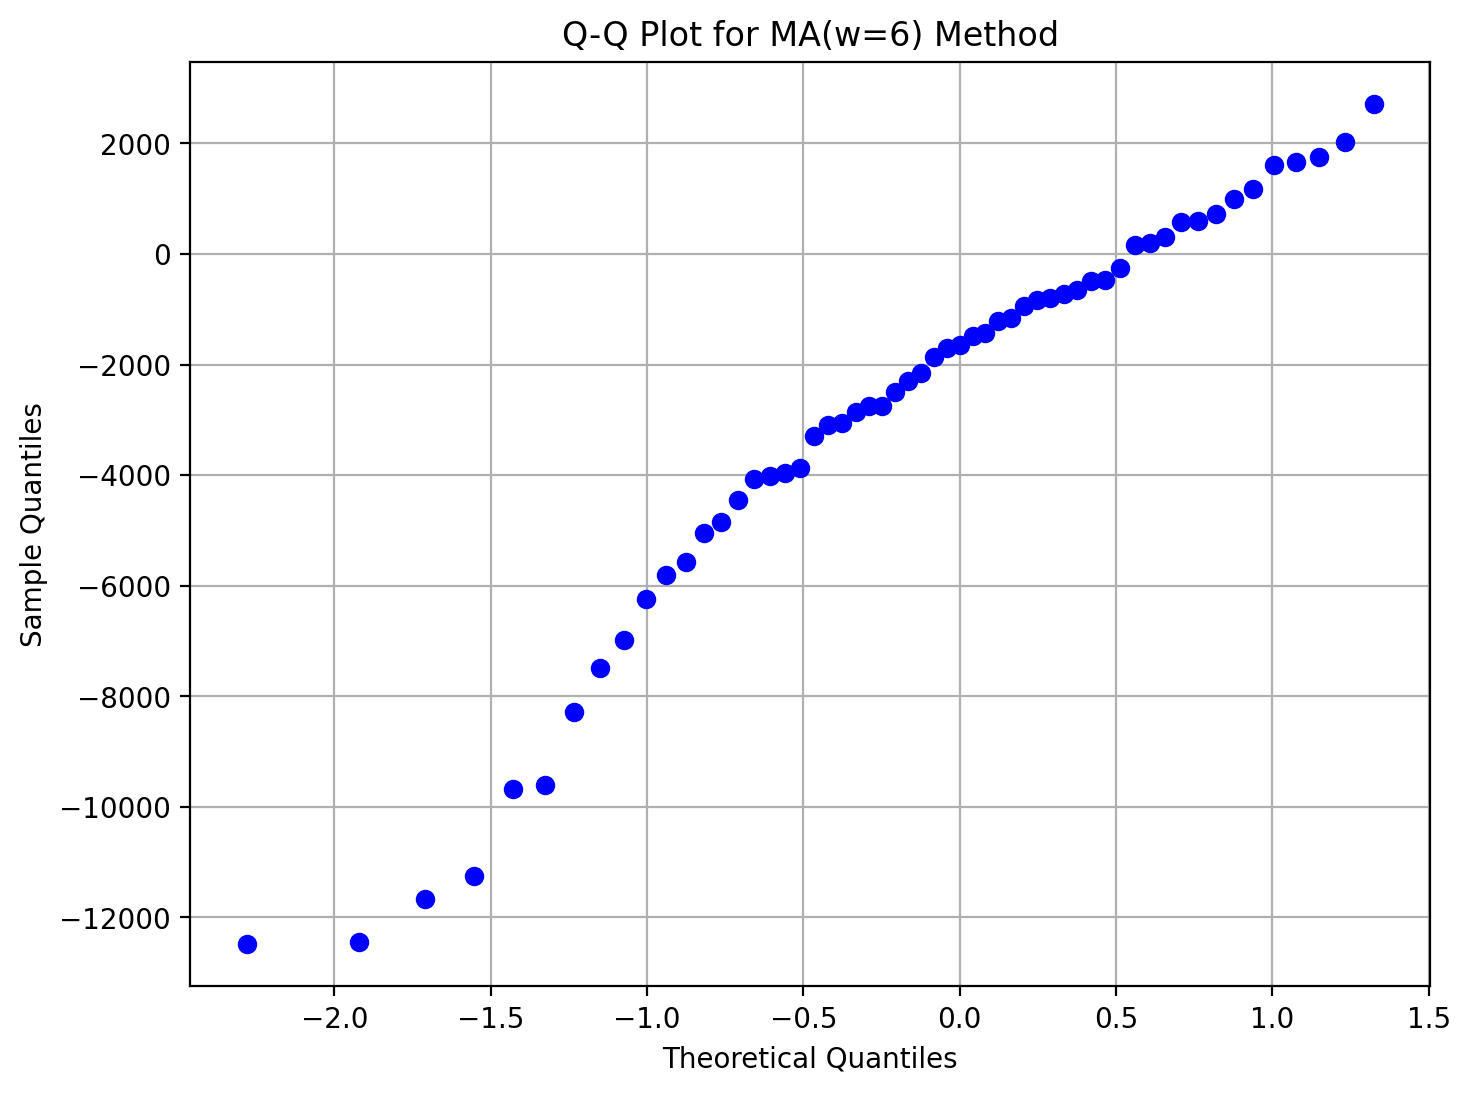

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(df_new_1['Residuals_MA_6'], dist="norm", plot=ax)
ax.get_lines()[1].set_linestyle('--')  # Add dashed line for perfect normal distribution
ax.set_title('Q-Q Plot for MA(w=6) Method')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

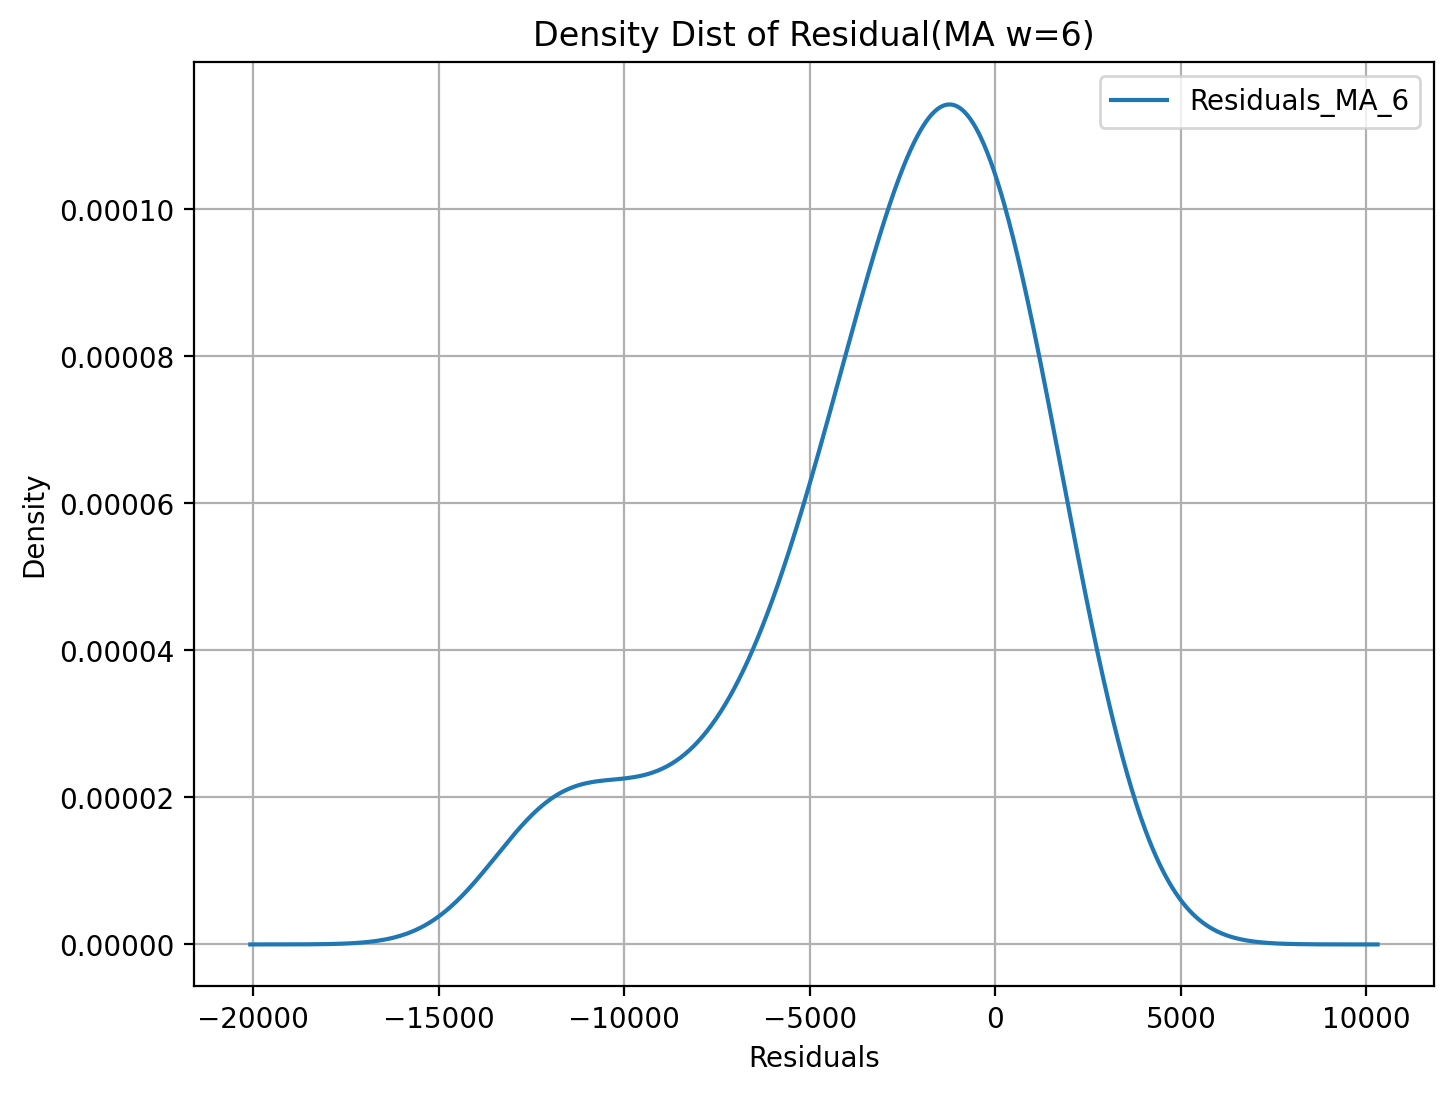

In [ ]:
df_new_1['Residuals_MA_6'].plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(MA w=6)")
plt.legend()
plt.grid(True)
plt.show()

EMWA Testing

The RMSE is : 2763.374941971198 , Value of window size :  3
The RMSE is : 3466.5260541829525 , Value of window size :  4
The RMSE is : 4082.590078361831 , Value of window size :  5
The RMSE is : 4652.106525522397 , Value of window size :  6
The RMSE is : 5188.274248884722 , Value of window size :  7


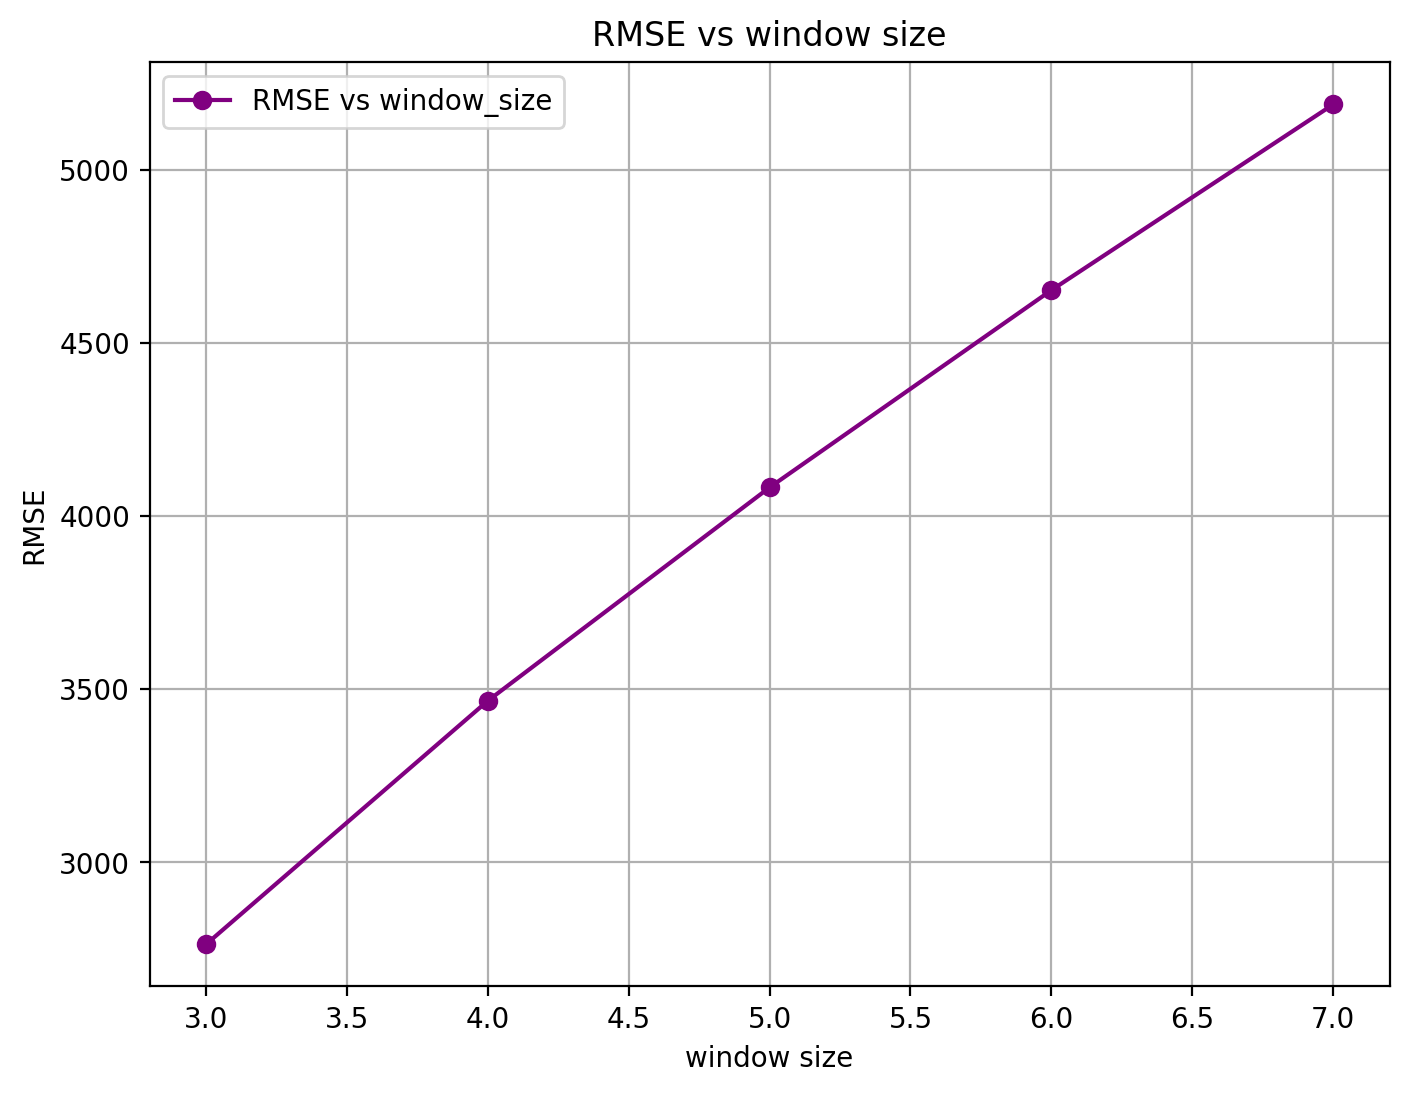

In [ ]:
q=[]
r=[]
for i in range(3,8):
  predicted_values = df_new_1['Value'].ewm(span=i, adjust=True).mean()
  rmse_score_i=((df_new_1.Value - predicted_values) ** 2).mean() ** .5
  r.append(rmse_score_i)
  q.append(i)
  print("The RMSE is :", rmse_score_i,", Value of window size : ",i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='purple', label='RMSE vs window_size')
plt.xlabel('window size')
plt.ylabel('RMSE')
plt.title('RMSE vs window size')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_q_value = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding window_size-value:", optimal_q_value)

Minimum RMSE: 2763.374941971198
Corresponding window_size-value: 3


The RMSE is : 4652.106525522397 , Value of window size :  6
The RMSE is : 5188.274248884722 , Value of window size :  7
The RMSE is : 5696.437720579536 , Value of window size :  8
The RMSE is : 6179.488694614215 , Value of window size :  9
The RMSE is : 6639.456154531671 , Value of window size :  10
The RMSE is : 7077.993239741652 , Value of window size :  11


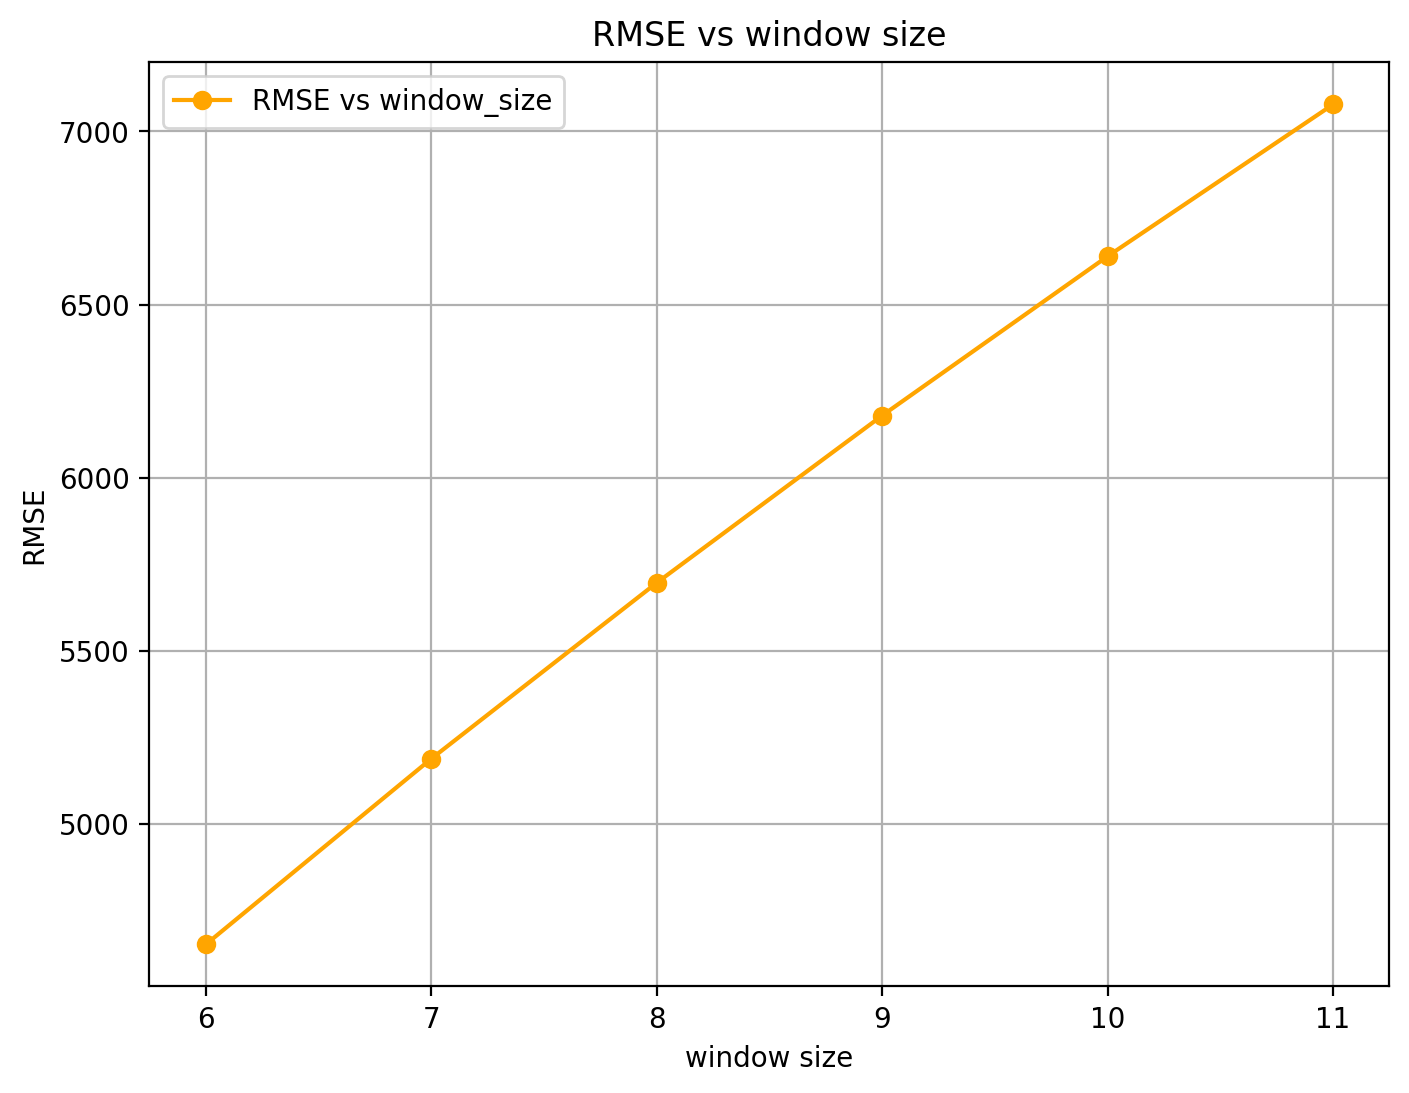

In [ ]:
q=[]
r=[]
for i in range(6,12):
  predicted_values = df_new_1['Value'].ewm(span=i, adjust=True).mean()
  rmse_score_i=((df_new_1.Value - predicted_values) ** 2).mean() ** .5
  r.append(rmse_score_i)
  q.append(i)
  print("The RMSE is :", rmse_score_i,", Value of window size : ",i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='orange', label='RMSE vs window_size')
plt.xlabel('window size')
plt.ylabel('RMSE')
plt.title('RMSE vs window size')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_q_value_1 = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding window_size-value:", optimal_q_value_1)

Minimum RMSE: 4652.106525522397
Corresponding window_size-value: 6


In [ ]:
alp_array=np.arange(0.1,1,0.05)

The RMSE is : 9959.116656174243 , Value of alpha :  0.1
The RMSE is : 7631.829303066286 , Value of alpha :  0.15000000000000002
The RMSE is : 6179.48869461421 , Value of alpha :  0.20000000000000004
The RMSE is : 5188.274248884722 , Value of alpha :  0.25000000000000006
The RMSE is : 4466.372984827815 , Value of alpha :  0.30000000000000004
The RMSE is : 3912.2871445620417 , Value of alpha :  0.3500000000000001
The RMSE is : 3466.5260541829493 , Value of alpha :  0.40000000000000013
The RMSE is : 3091.731386337455 , Value of alpha :  0.45000000000000007
The RMSE is : 2763.374941971197 , Value of alpha :  0.5000000000000001
The RMSE is : 2464.882279447126 , Value of alpha :  0.5500000000000002
The RMSE is : 2184.8386075023436 , Value of alpha :  0.6000000000000002
The RMSE is : 1915.2796030524855 , Value of alpha :  0.6500000000000001
The RMSE is : 1650.5936275824774 , Value of alpha :  0.7000000000000002
The RMSE is : 1386.7872515085007 , Value of alpha :  0.7500000000000002
The RMSE i

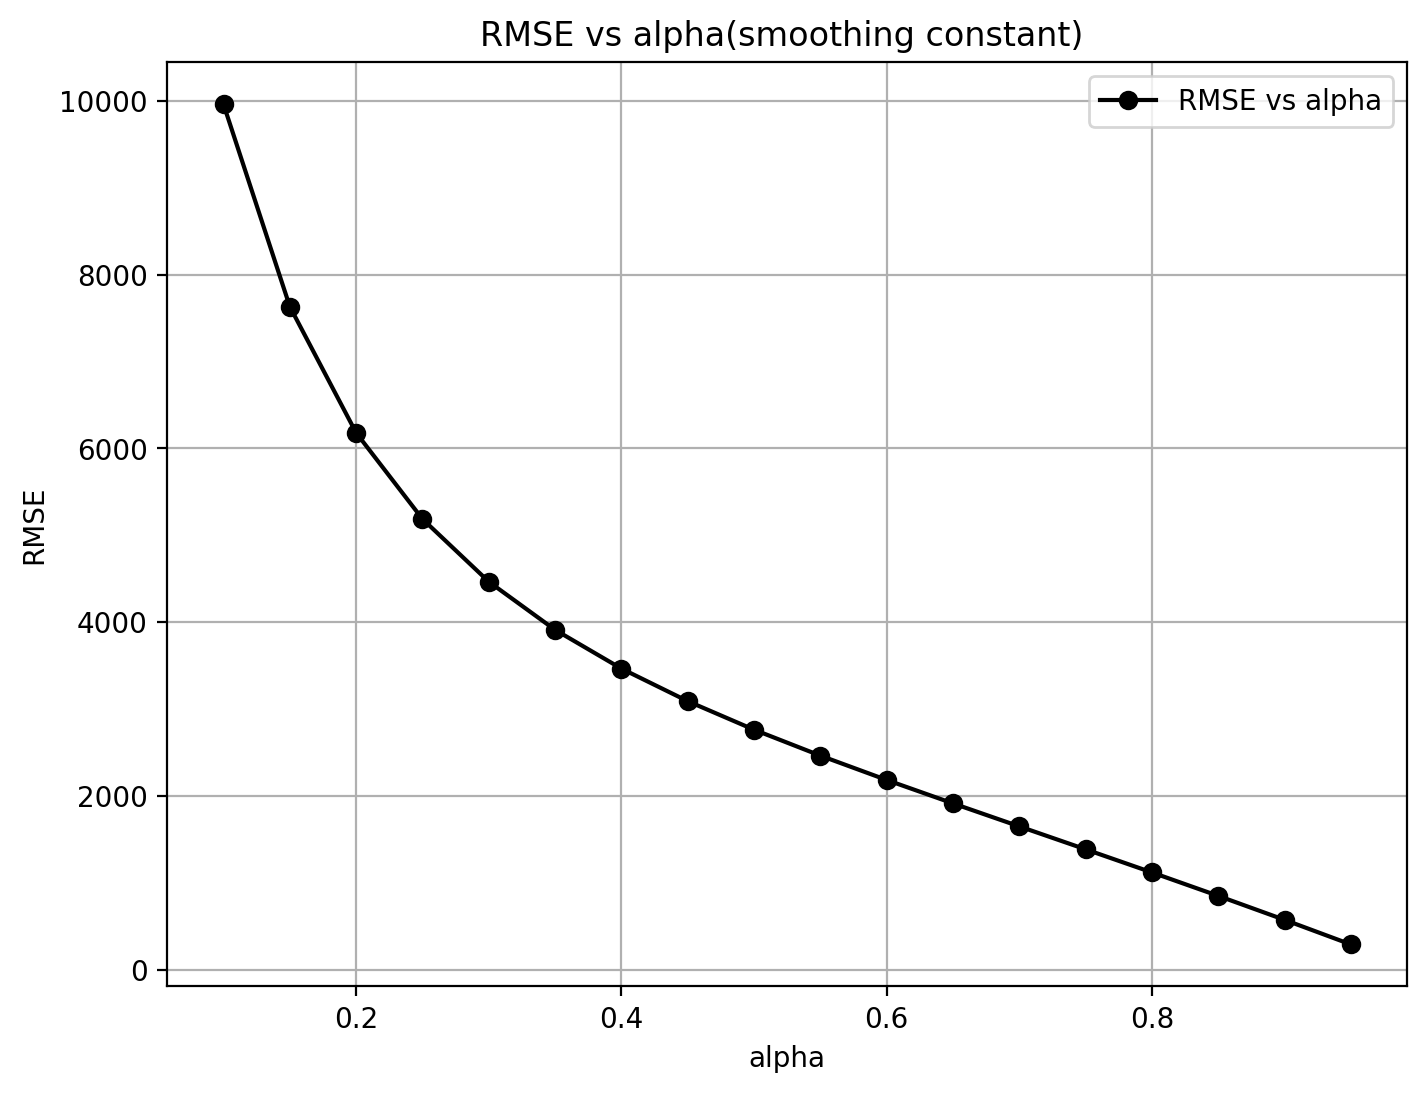

In [ ]:
q=[]
r=[]
for i in alp_array:
  predicted_values = df_new_1['Value'].ewm(adjust=True,alpha=i).mean()
  rmse_score_i=((df_new_1.Value - predicted_values) ** 2).mean() ** .5
  r.append(rmse_score_i)
  q.append(i)
  print("The RMSE is :", rmse_score_i,", Value of alpha : ",i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='black', label='RMSE vs alpha')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs alpha(smoothing constant) ')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_q_value_2 = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding alpha-value:", optimal_q_value_2)

Minimum RMSE: 291.98839627516685
Corresponding alpha-value: 0.9500000000000003


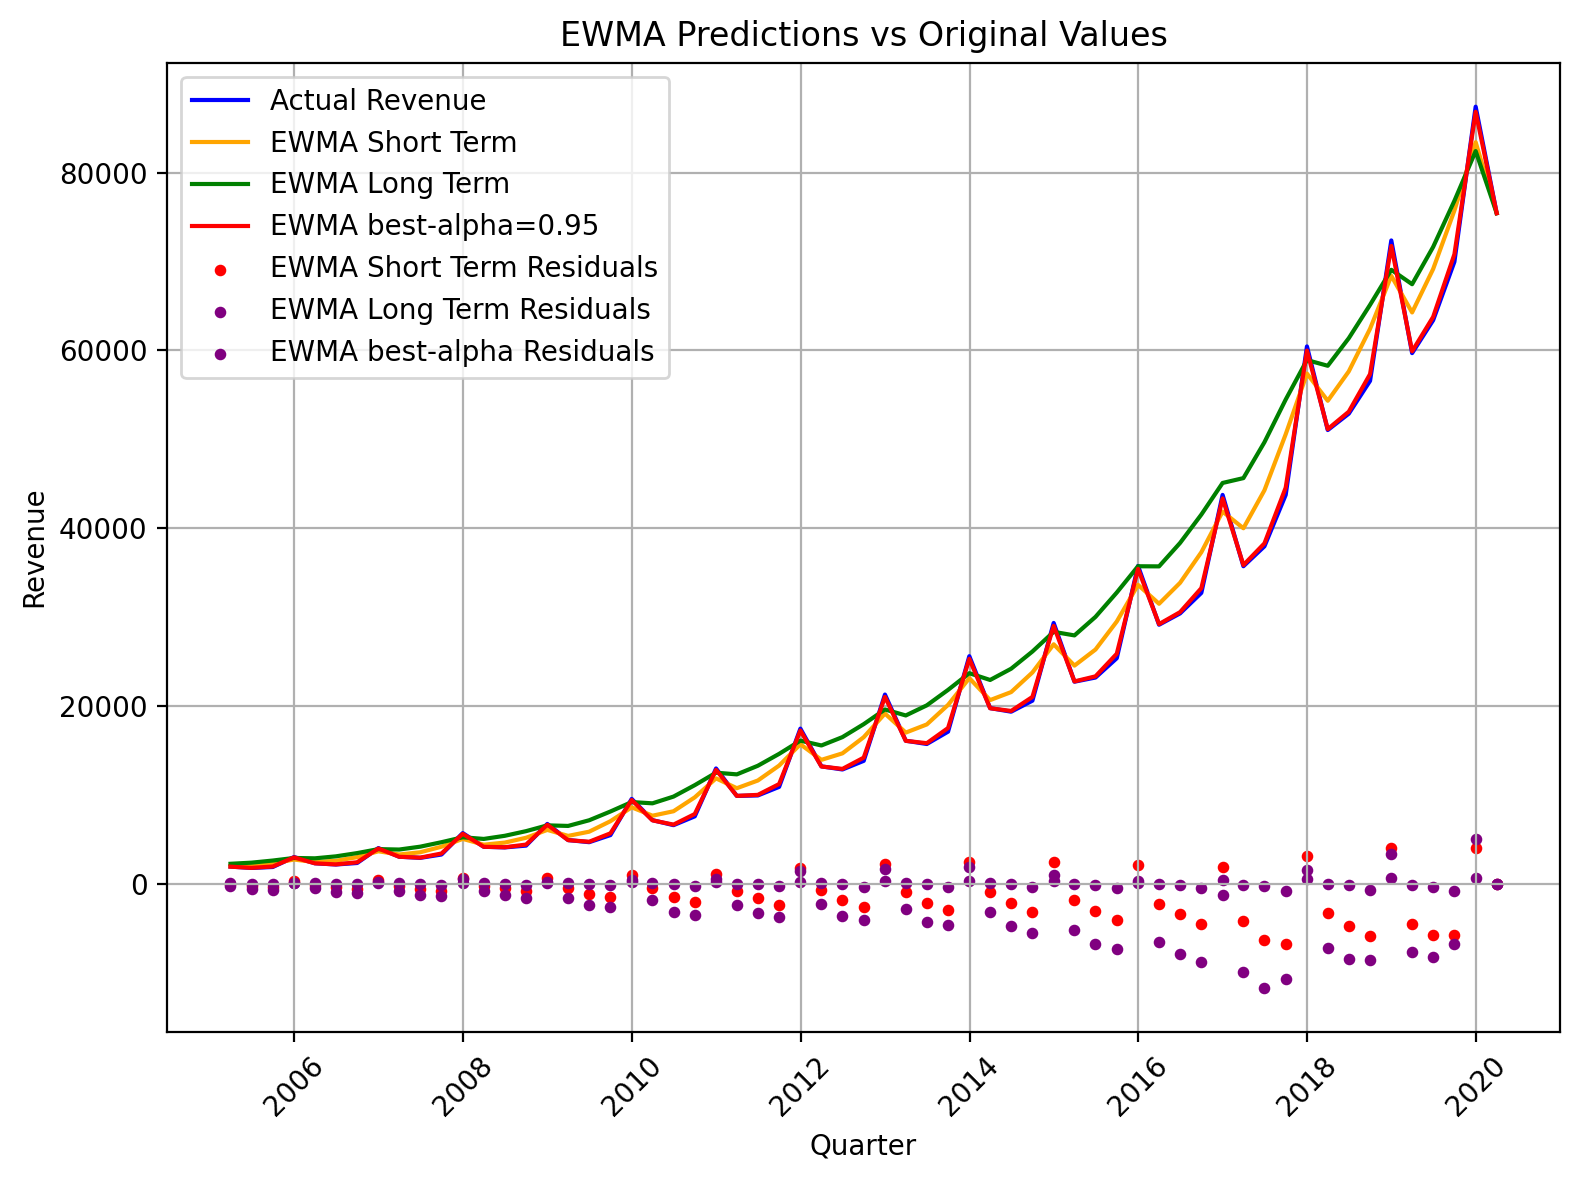

In [ ]:
# Exponentially Weighted Moving Average (EWMA) for different spans

# Here we'll choose two different spans (short and long-term trends)
span_short = optimal_q_value  # Short-term trend
span_long = optimal_q_value_1   # Long-term trend
best_alpha=optimal_q_value_2 #best-alpha

df_new_1['EWMA_3'] = df_new_1['Value'].ewm(span=span_short, adjust=True).mean()
df_new_1['EWMA_6'] = df_new_1['Value'].ewm(span=span_long, adjust=True).mean()
df_new_1['EWMA_best_alpha'] = df_new_1['Value'].ewm(adjust=True,alpha=best_alpha).mean()
# Calculate residuals for both EWMA
df_new_1['Residuals_EWMA_3'] = df_new_1['Value'] - df_new_1['EWMA_3']
df_new_1['Residuals_EWMA_6'] = df_new_1['Value'] - df_new_1['EWMA_6']
df_new_1['Residuals_EWMA_best_alpha'] = df_new_1['Value'] - df_new_1['EWMA_best_alpha']

# Actual Revenue
plt.plot(df_new_1.index, df_new_1['Value'], label='Actual Revenue', color='blue')

# Predicted Revenue (EWMA)
plt.plot(df_new_1.index, df_new_1['EWMA_3'], label='EWMA Short Term', color='orange')
plt.plot(df_new_1.index, df_new_1['EWMA_6'], label='EWMA Long Term', color='green')
plt.plot(df_new_1.index, df_new_1['EWMA_best_alpha'], label='EWMA best-alpha=0.95', color='red')
# Residuals for the EWMA short term
plt.scatter(df_new_1.index, df_new_1['Residuals_EWMA_3'], label='EWMA Short Term Residuals', color='red', s=10)

# Residuals for the EWMA long term
plt.scatter(df_new_1.index, df_new_1['Residuals_EWMA_6'], label='EWMA Long Term Residuals', color='purple', s=10)
#Residuals for the EWMA best alpha
plt.scatter(df_new_1.index, df_new_1['Residuals_EWMA_best_alpha'], label='EWMA best-alpha Residuals', color='purple', s=10)

plt.title('EWMA Predictions vs Original Values')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the plot
plt.show()

In [ ]:
RMSE_EWMA_short=((df_new_1.Value - df_new_1.EWMA_3) ** 2).mean() ** .5
RMSE_EWMA_long=((df_new_1.Value - df_new_1.EWMA_6) ** 2).mean() ** .5
RMSE_EWMA_bestalpha=((df_new_1.Value - df_new_1.EWMA_best_alpha) ** 2).mean() ** .5

In [ ]:
print("The Mean Root-Mean-Square Error in EWMA for short span(3):",RMSE_EWMA_short)
print()
print("The Mean Root-Mean-Square Error in EWMA for long span(6):",RMSE_EWMA_long)
print()
print("The Mean Root-Mean-Square Error in EWMA for best-alpha(0.95):",RMSE_EWMA_bestalpha)

The Mean Root-Mean-Square Error in EWMA for short span(3): 2763.374941971198

The Mean Root-Mean-Square Error in EWMA for long span(6): 4652.106525522397

The Mean Root-Mean-Square Error in EWMA for best-alpha(0.95): 291.98839627516685


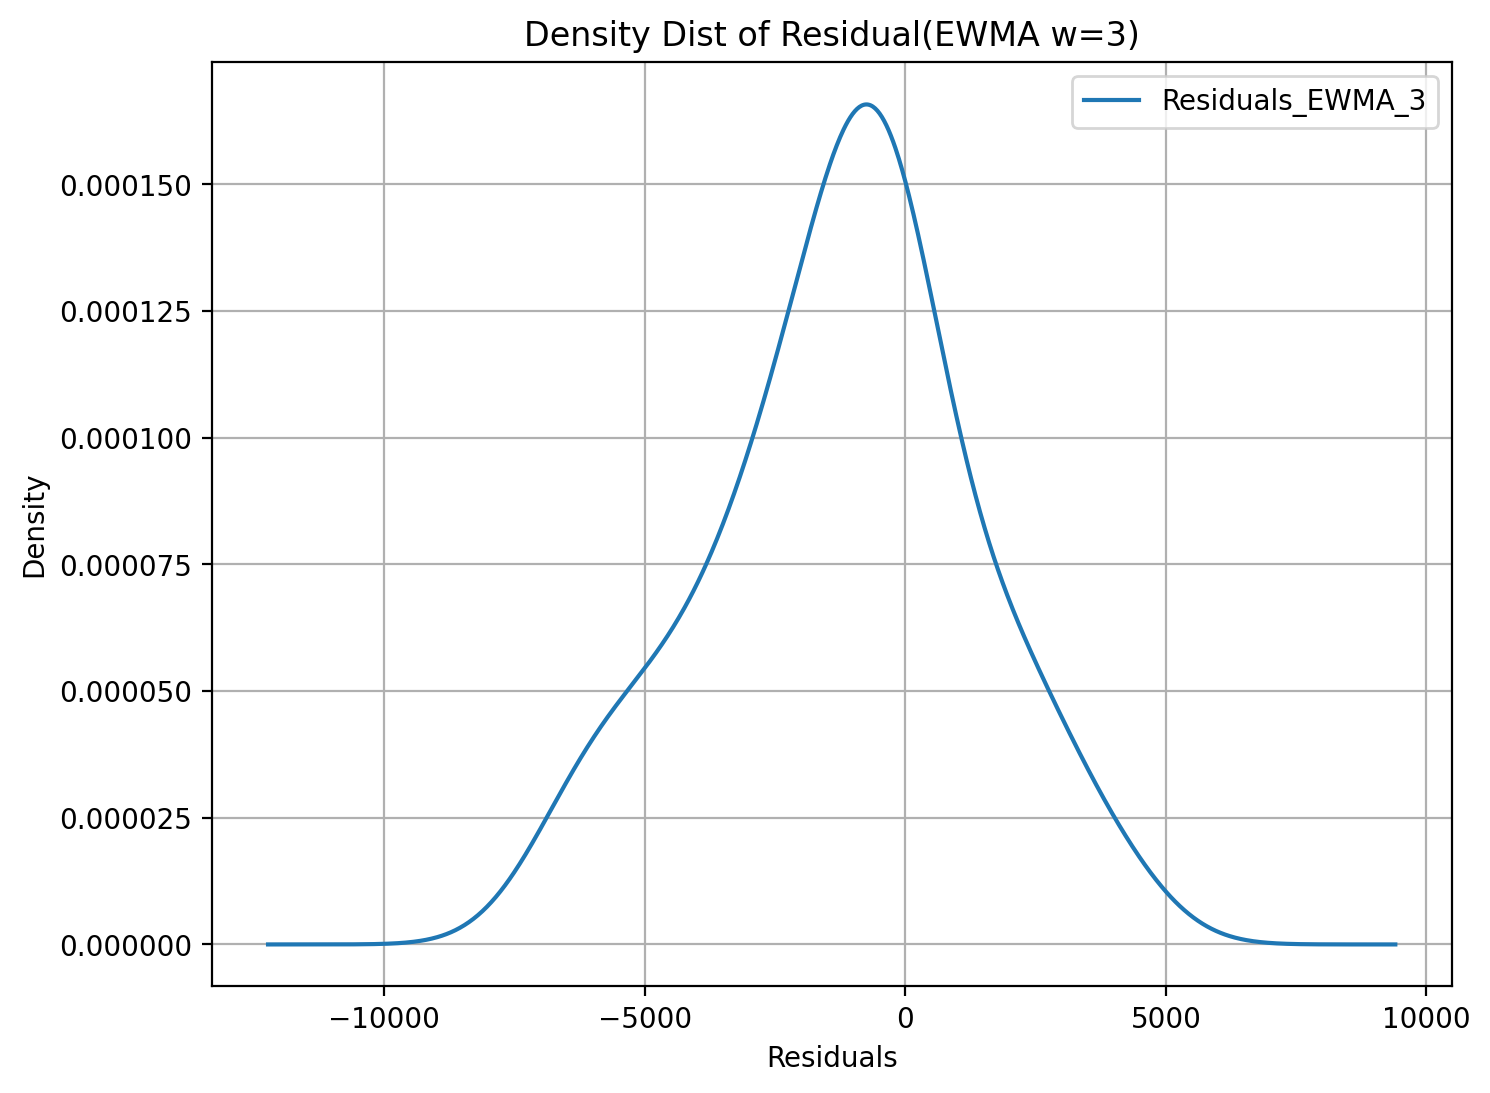

In [ ]:
df_new_1['Residuals_EWMA_3'].plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(EWMA w=3)")
plt.legend()
plt.grid(True)
plt.show()

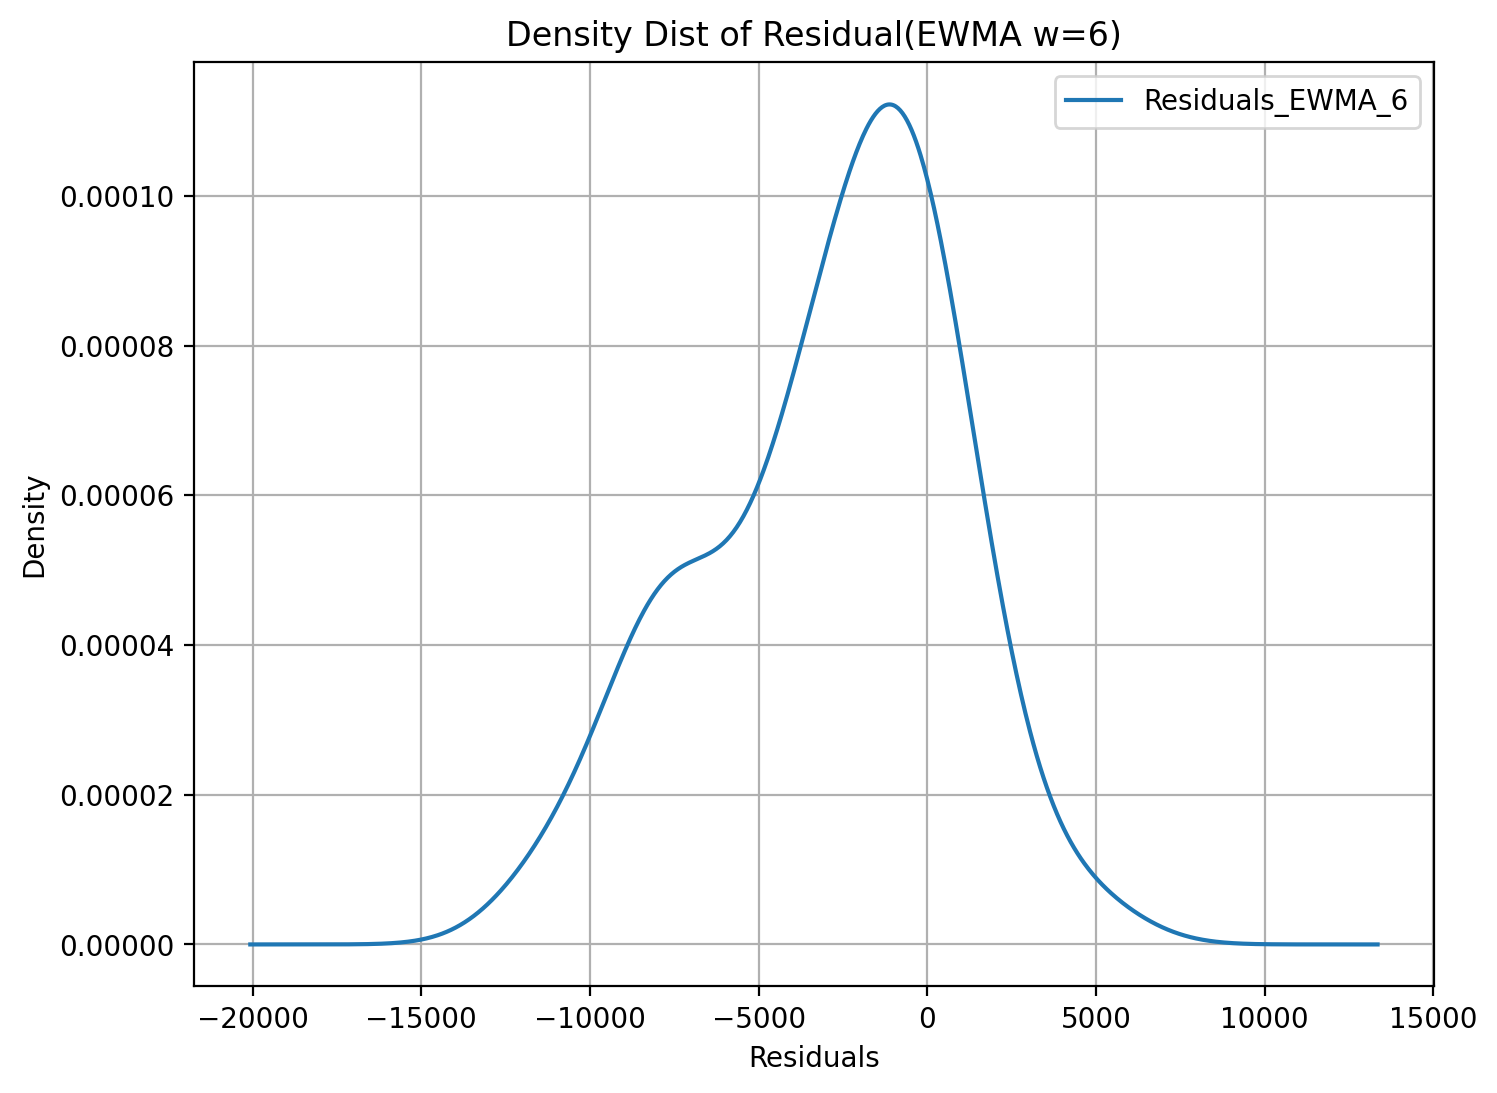

In [ ]:
df_new_1['Residuals_EWMA_6'].plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(EWMA w=6)")
plt.legend()
plt.grid(True)
plt.show()

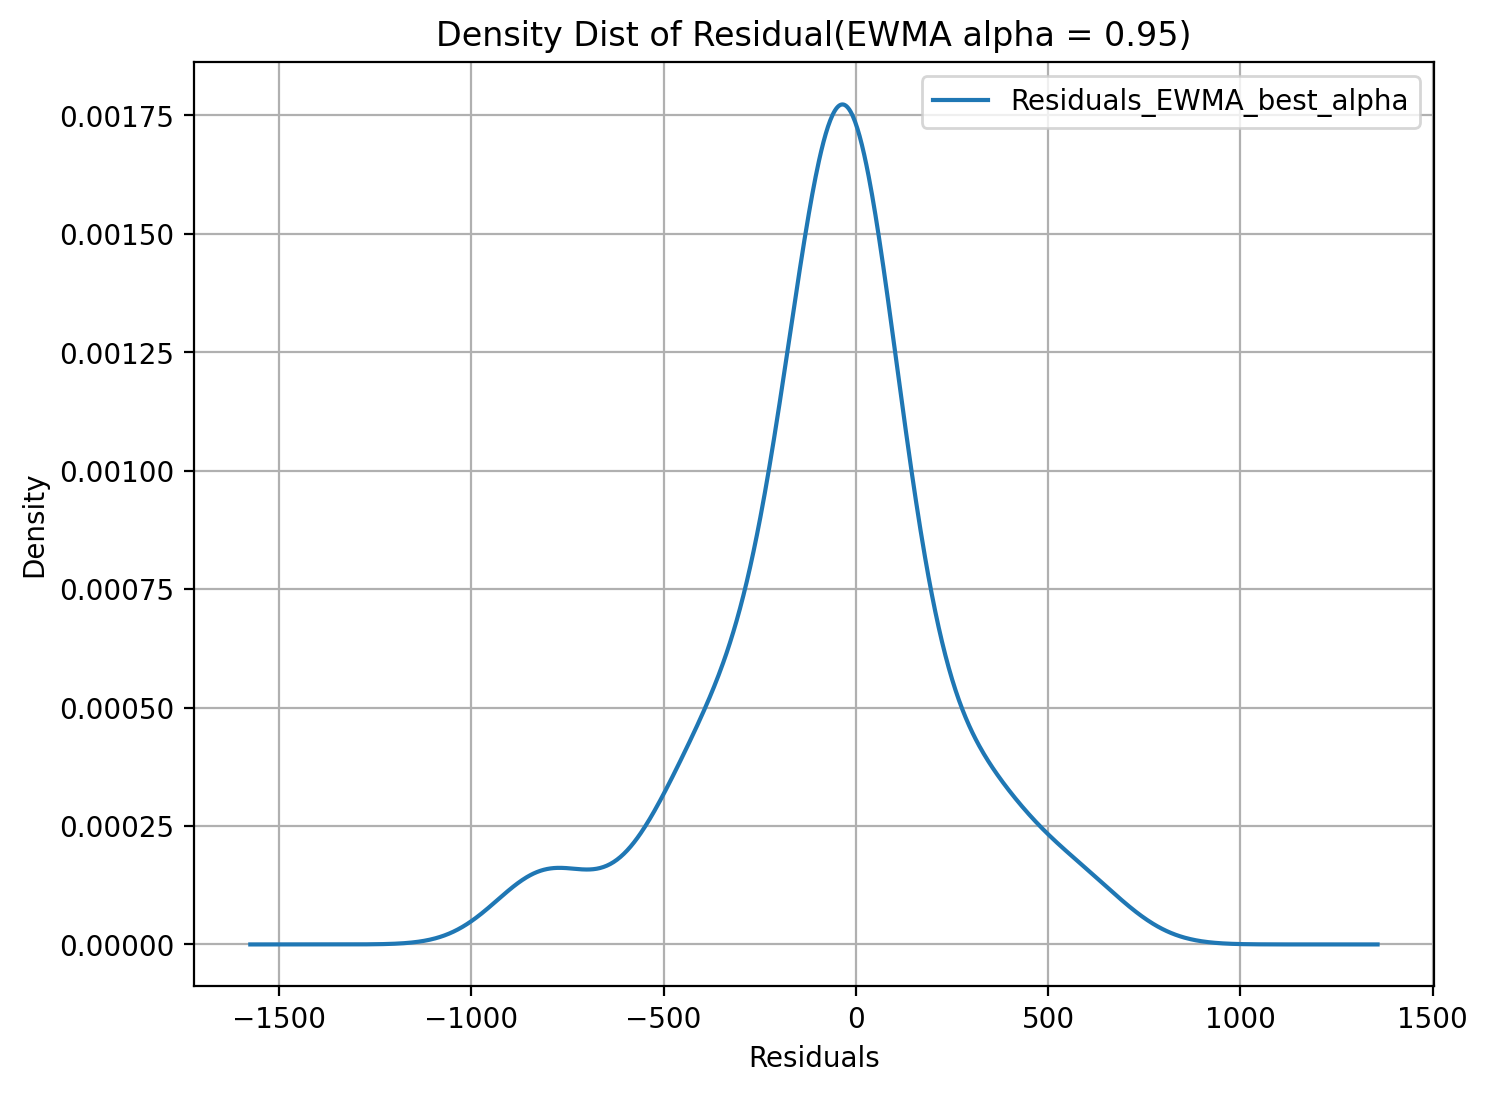

In [ ]:
df_new_1['Residuals_EWMA_best_alpha'].plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(EWMA alpha = 0.95)")
plt.legend()
plt.grid(True)
plt.show()


**Holt-Winters Method Testing**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


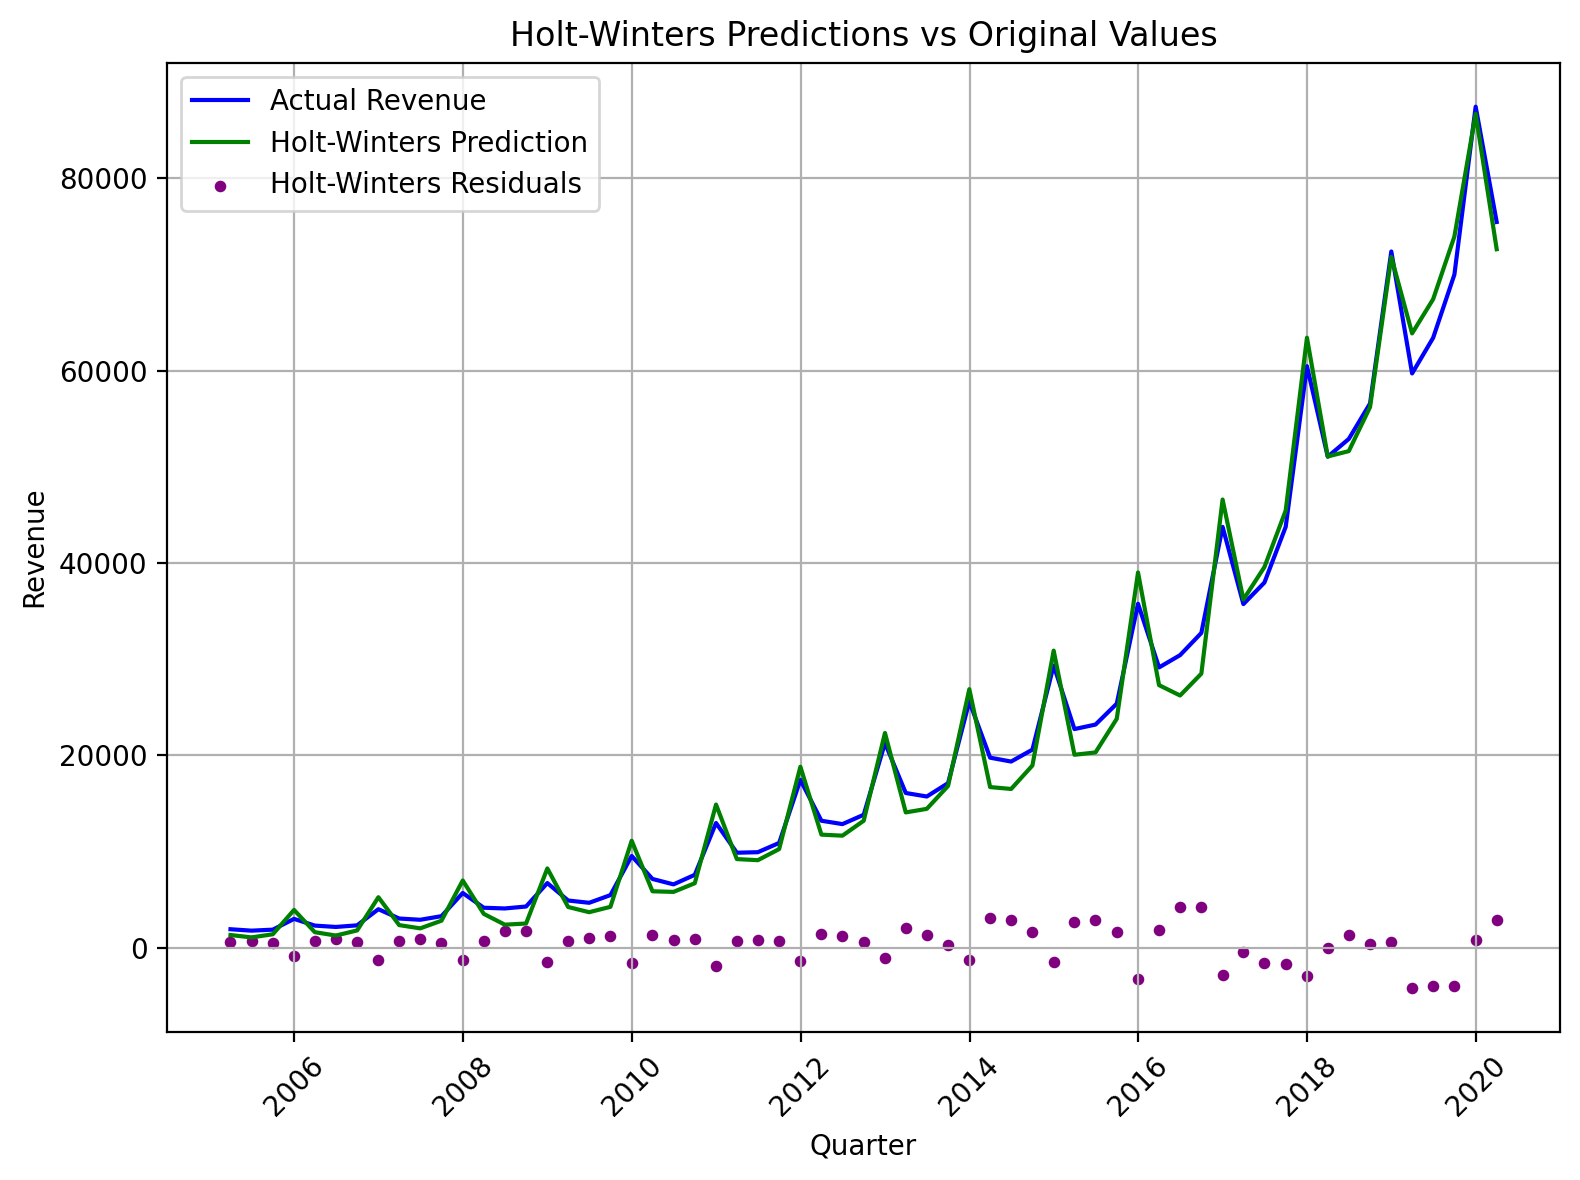

In [ ]:
seasonal_periods = 4

# Build the model
holt_winters_model = ExponentialSmoothing(
    df_new_1['Value'],
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_periods
).fit()

# Make predictions
df_new_1['Holt_Winters'] = holt_winters_model.fittedvalues

# Calculate residuals for Holt-Winters method
df_new_1['Residuals_Holt_Winters'] = df_new_1['Value'] - df_new_1['Holt_Winters']

# Plotting the actual, predicted (Holt-Winters), and residuals

# Actual Revenue
plt.plot(df_new_1.index, df_new_1['Value'], label='Actual Revenue', color='blue')

# Predicted Revenue (Holt-Winters)
plt.plot(df_new_1.index, df_new_1['Holt_Winters'], label='Holt-Winters Prediction', color='green')

# Residuals for Holt-Winters method
plt.scatter(df_new_1.index, df_new_1['Residuals_Holt_Winters'], label='Holt-Winters Residuals', color='purple', s=10)

plt.title('Holt-Winters Predictions vs Original Values')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the plot
plt.show()

In [ ]:
RMSE_Holt_winter=((df_new_1.Value - df_new_1.Holt_Winters) ** 2).mean() ** .5

In [ ]:
print("The Mean Root-Mean-Square Error in Holt-Winter's Method:",RMSE_Holt_winter)

The Mean Root-Mean-Square Error in Holt-Winter's Method: 1887.9204359283808


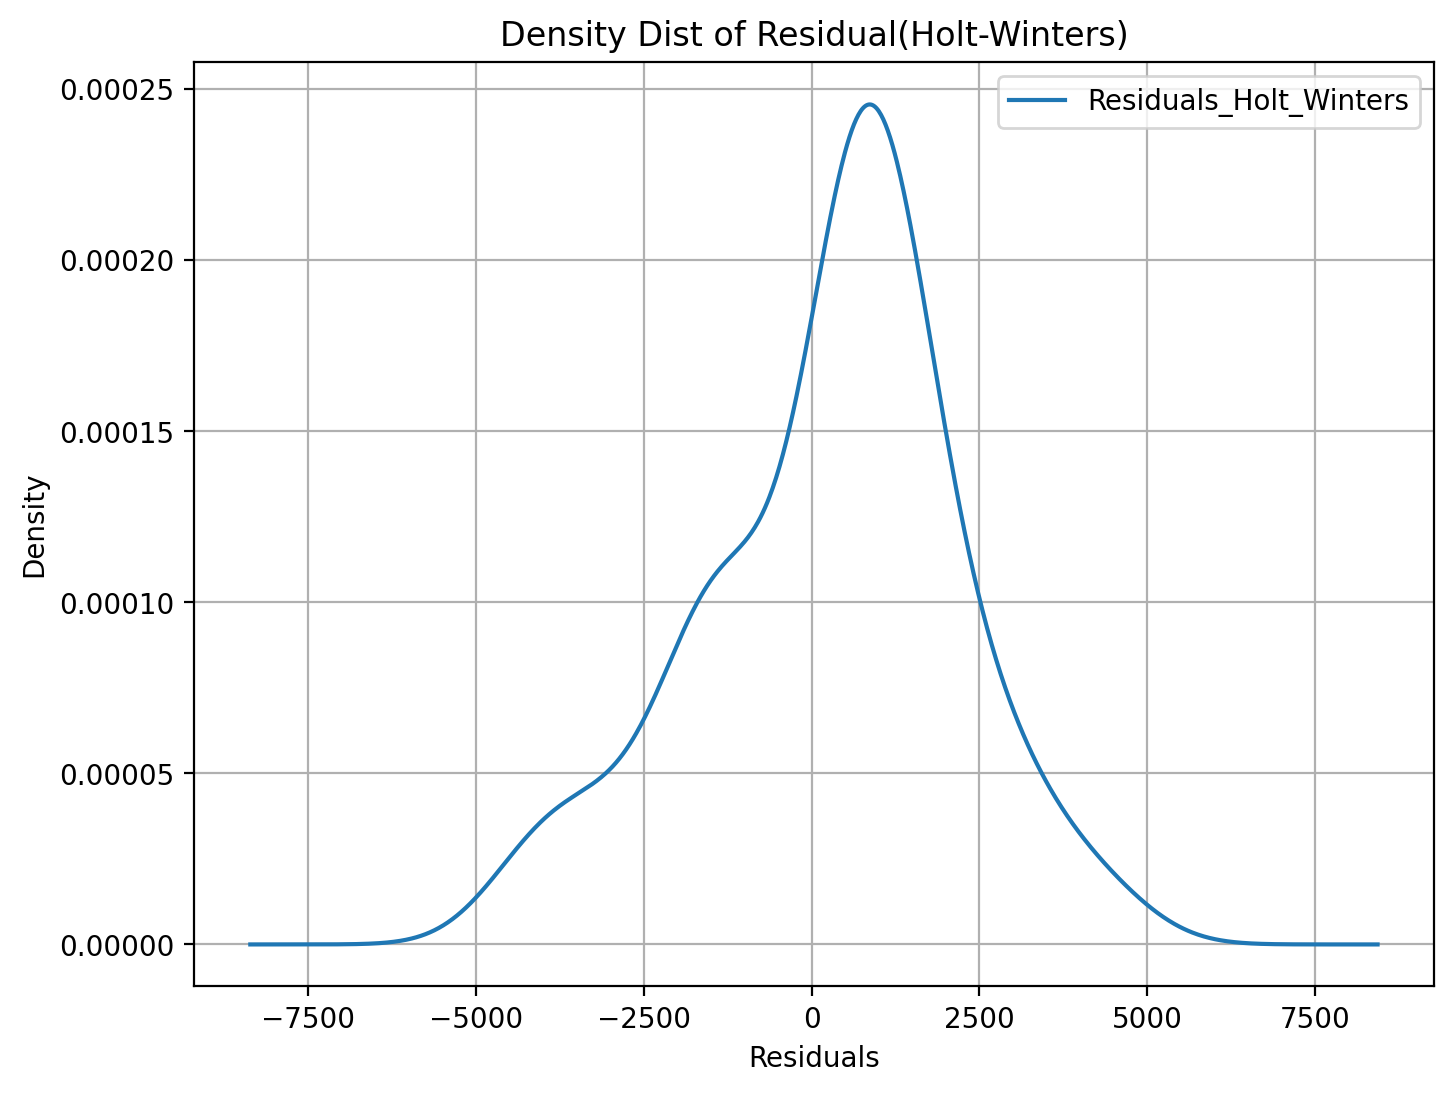

In [ ]:
df_new_1['Residuals_Holt_Winters'].plot(kind='kde')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title("Density Dist of Residual(Holt-Winters)")
plt.legend()
plt.grid(True)
plt.show()

The RMSE is : 1246.9652019769173 , Value of p :  1
The RMSE is : 1241.5276083399747 , Value of p :  2
The RMSE is : 918.52724105234 , Value of p :  3
The RMSE is : 354.01366070168115 , Value of p :  4
The RMSE is : 189.53256697632867 , Value of p :  5
The RMSE is : 247.08931611477024 , Value of p :  6
The RMSE is : 238.43936946616694 , Value of p :  7
The RMSE is : 290.0778545507206 , Value of p :  8
The RMSE is : 329.2896297780288 , Value of p :  9
The RMSE is : 324.14862578291473 , Value of p :  10
The RMSE is : 271.213641056923 , Value of p :  11
The RMSE is : 240.6289211294999 , Value of p :  12


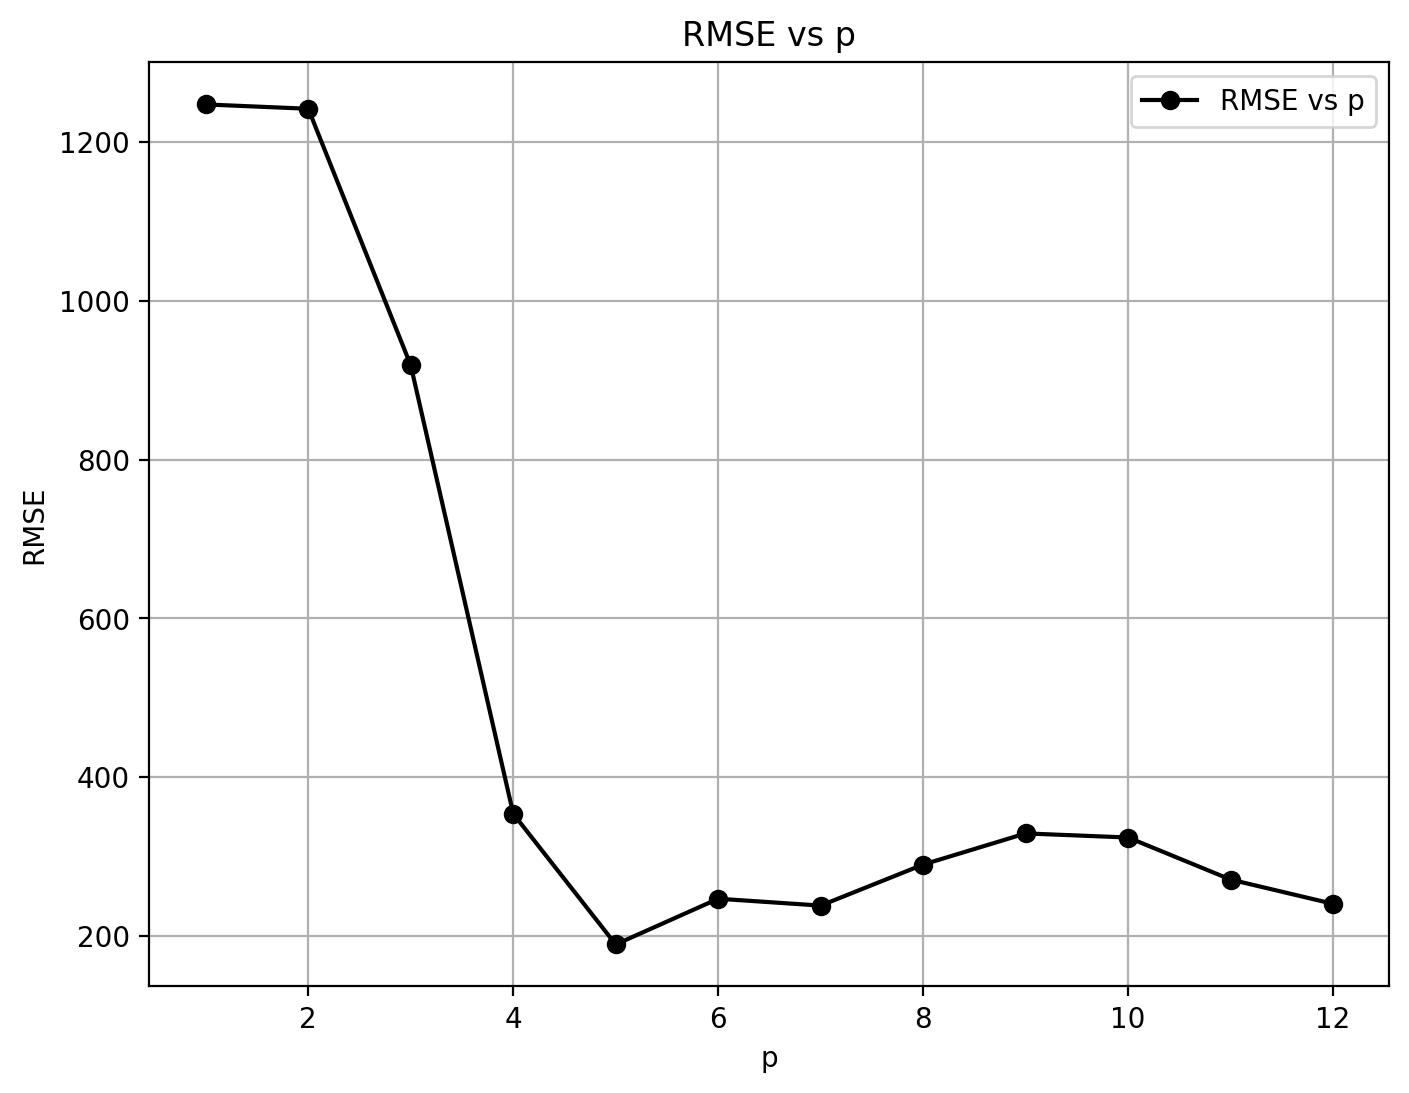

In [ ]:
r=[]
p=[]
for i in range(1,13):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_new_1.Value))
  r.append(RMSE)
  p.append(i)
plt.figure(dpi=200)
plt.plot(p, r, marker='o', linestyle='-', color='black', label='RMSE vs p')
plt.xlabel('p')
plt.ylabel('RMSE')
plt.title('RMSE vs p')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding p-value at the minimum RMSE
optimal_p_value = p[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding p-value:", optimal_p_value)

Minimum RMSE: 189.53256697632867
Corresponding p-value: 5


<Axes: xlabel='Quarter'>

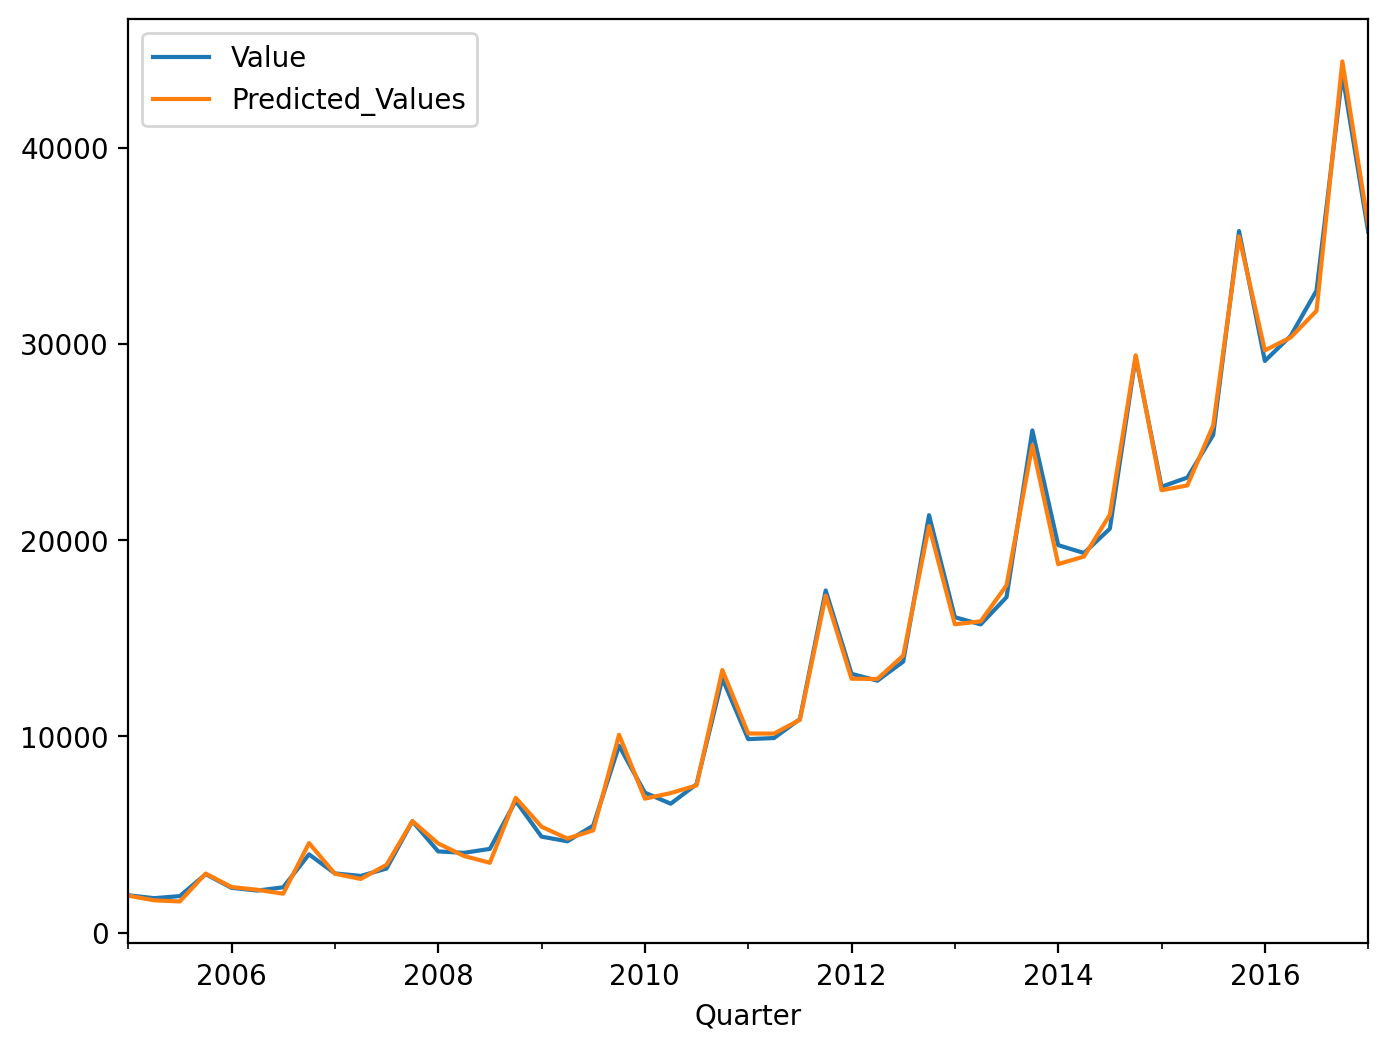

In [ ]:
df_new = pd.concat([df_train,df_test])
df_new[['Value','Predicted_Values']].plot()

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_new.Value - df_new.Predicted_Values
res

Residuals
Quarter                
2017-03-31  -330.445714
2016-12-31  -647.504802
2016-09-30  1031.983188
2016-06-30    78.066647
2016-03-31  -538.620000
2015-12-31   273.236078
2015-09-30  -487.717670
2015-06-30   401.161828
2015-03-31   177.648799
2014-12-31   -86.234311
2014-09-30  -714.229587
2014-06-30   180.278043
2014-03-31   966.470459
2013-12-31   754.032197
2013-09-30  -601.213325
2013-06-30  -156.161140
2013-03-31   361.005634
2012-12-31   555.500123
2012-09-30  -305.128373
2012-06-30   -88.526325
2012-03-31   249.860184
2011-12-31   263.936349
2011-09-30    35.529436
2011-06-30  -225.062047
2011-03-31  -288.132876
2010-12-31  -431.569857
2010-09-30    61.903576
2010-06-30  -541.259362
2010-03-31   307.001011
2009-12-31  -557.678627
2009-09-30   242.106269
2009-06-30  -138.784085
2009-03-31  -504.631148
2008-12-31  -164.843976
2008-09-30   707.399496
2008-06-30   160.623911
2008-03-31  -405.230903
2007-12-31    -8.577284
2007-09-30  -190.458135
2007-06-30   154.100394
2007-03-31    15.643237
2006-12-31  -575.166404
2006-09-30   326.445543
2006-06-30   -39.579036
2006-03-31   -42.296661
2005-12-31   -29.855881
2005-09-30   271.895900
2005-06-30   110.684859
2005-03-31    19.223089

The RMSE is : 229.4810117724736 , Value of q :  1
The RMSE is : 222.26137286842626 , Value of q :  2
The RMSE is : 230.13937582951368 , Value of q :  3
The RMSE is : 234.25242076026643 , Value of q :  4
The RMSE is : 220.4540034850413 , Value of q :  5
The RMSE is : 243.7068451788284 , Value of q :  6
The RMSE is : 255.72370876895252 , Value of q :  7
The RMSE is : 288.49761463383226 , Value of q :  8
The RMSE is : 287.80548249312045 , Value of q :  9
The RMSE is : 317.5336436577978 , Value of q :  10
The RMSE is : 285.0364230318813 , Value of q :  11
The RMSE is : 399.2736806842708 , Value of q :  12
The RMSE is : 370.0163092153907 , Value of q :  13


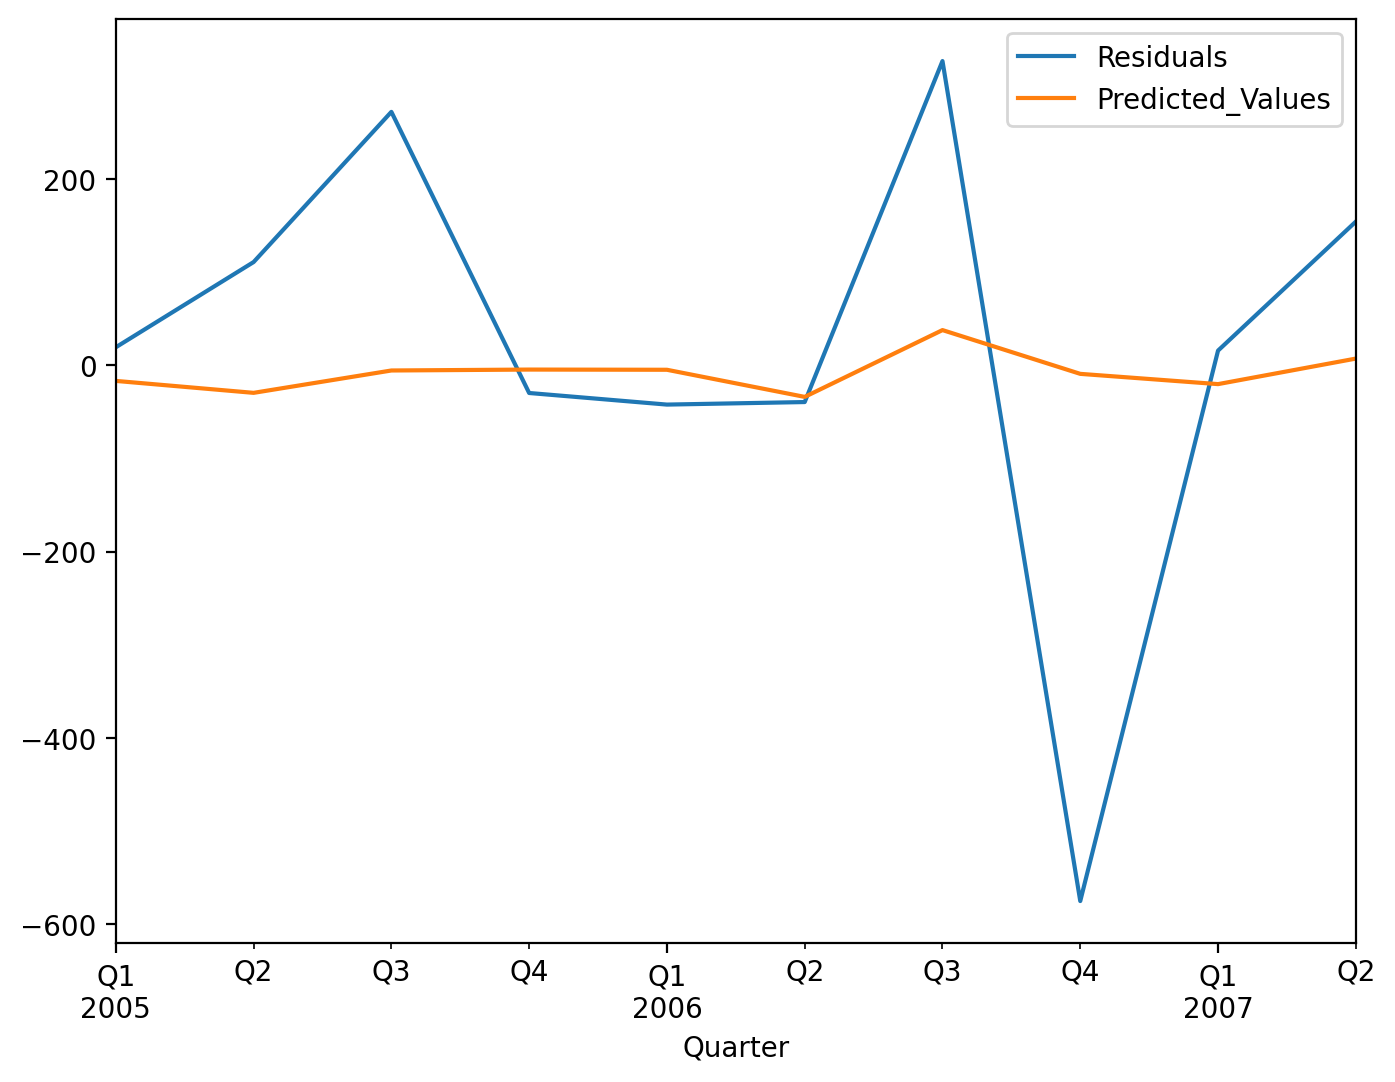

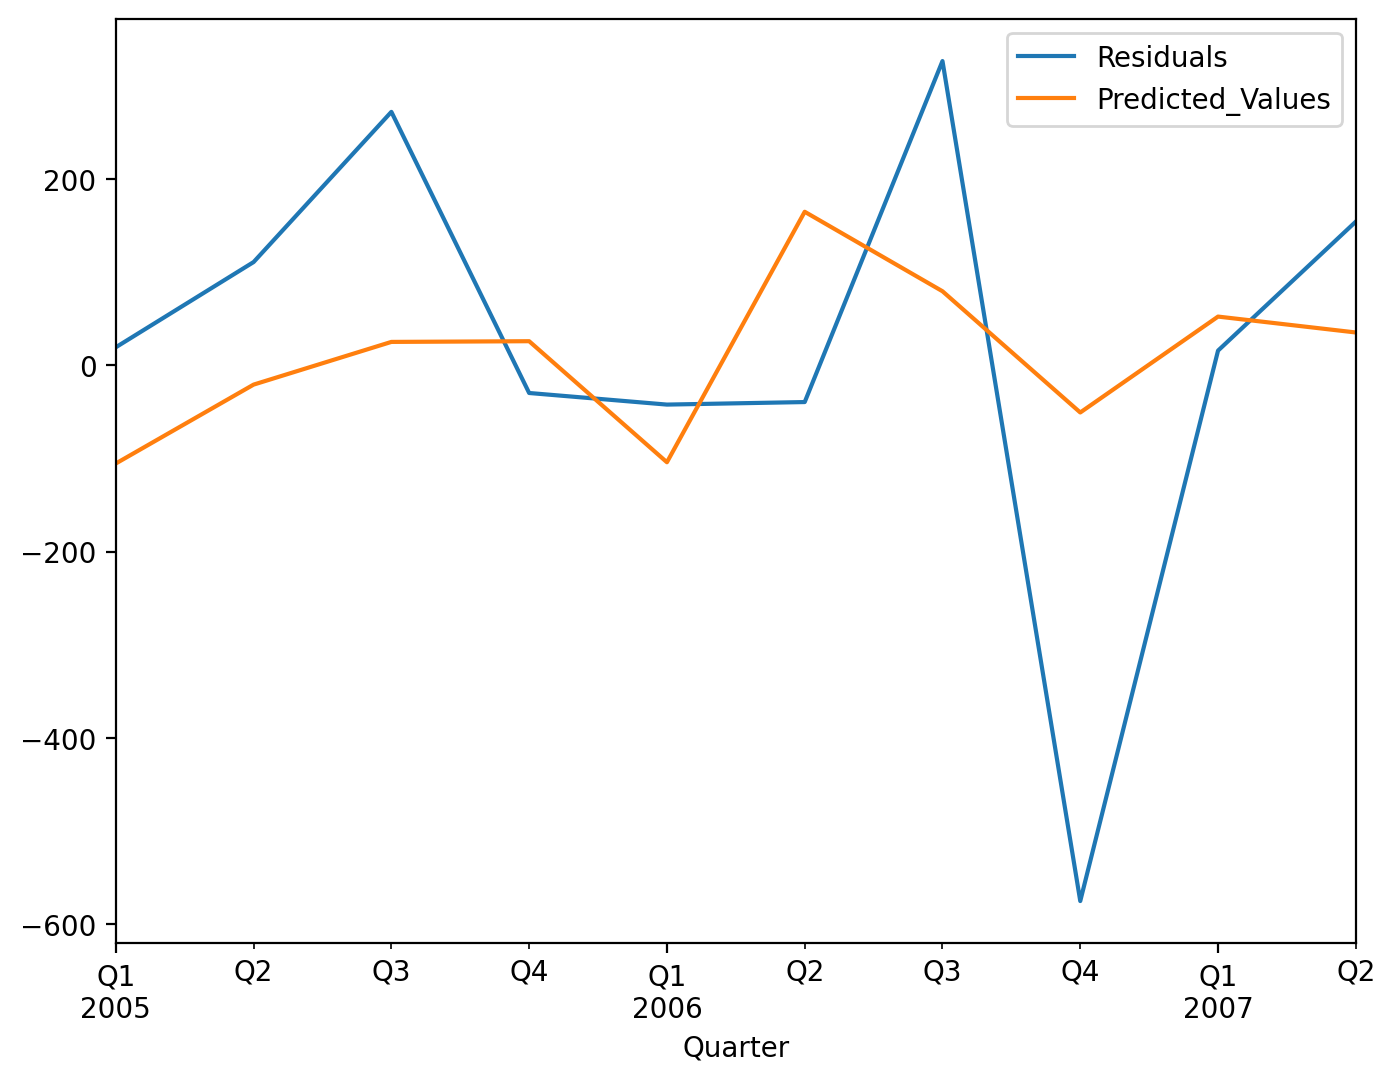

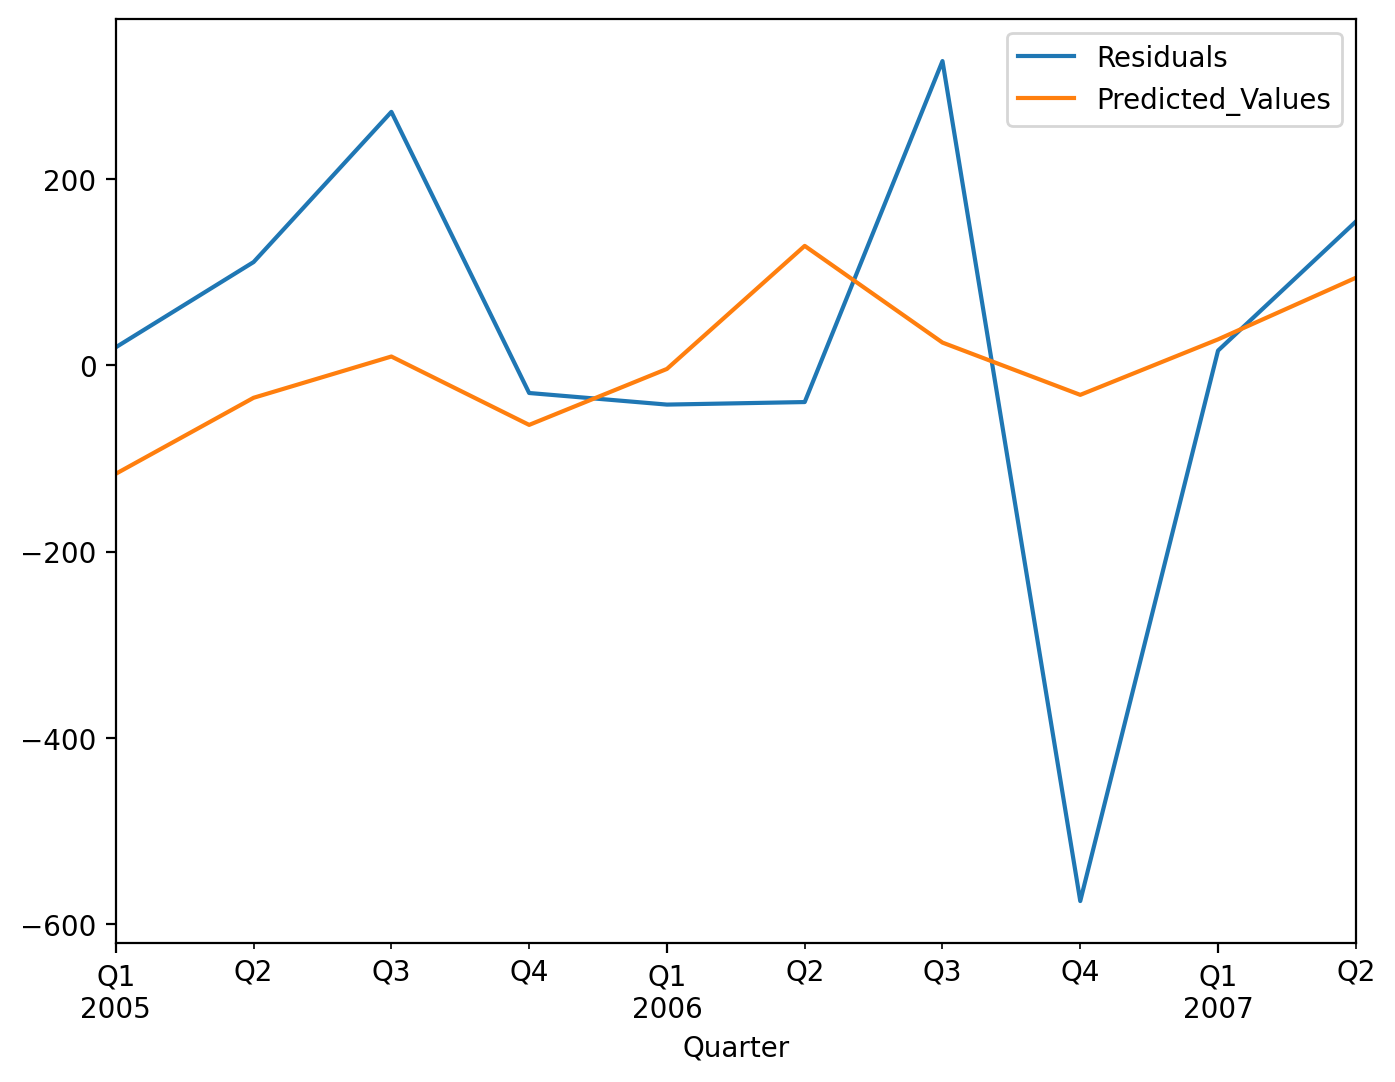

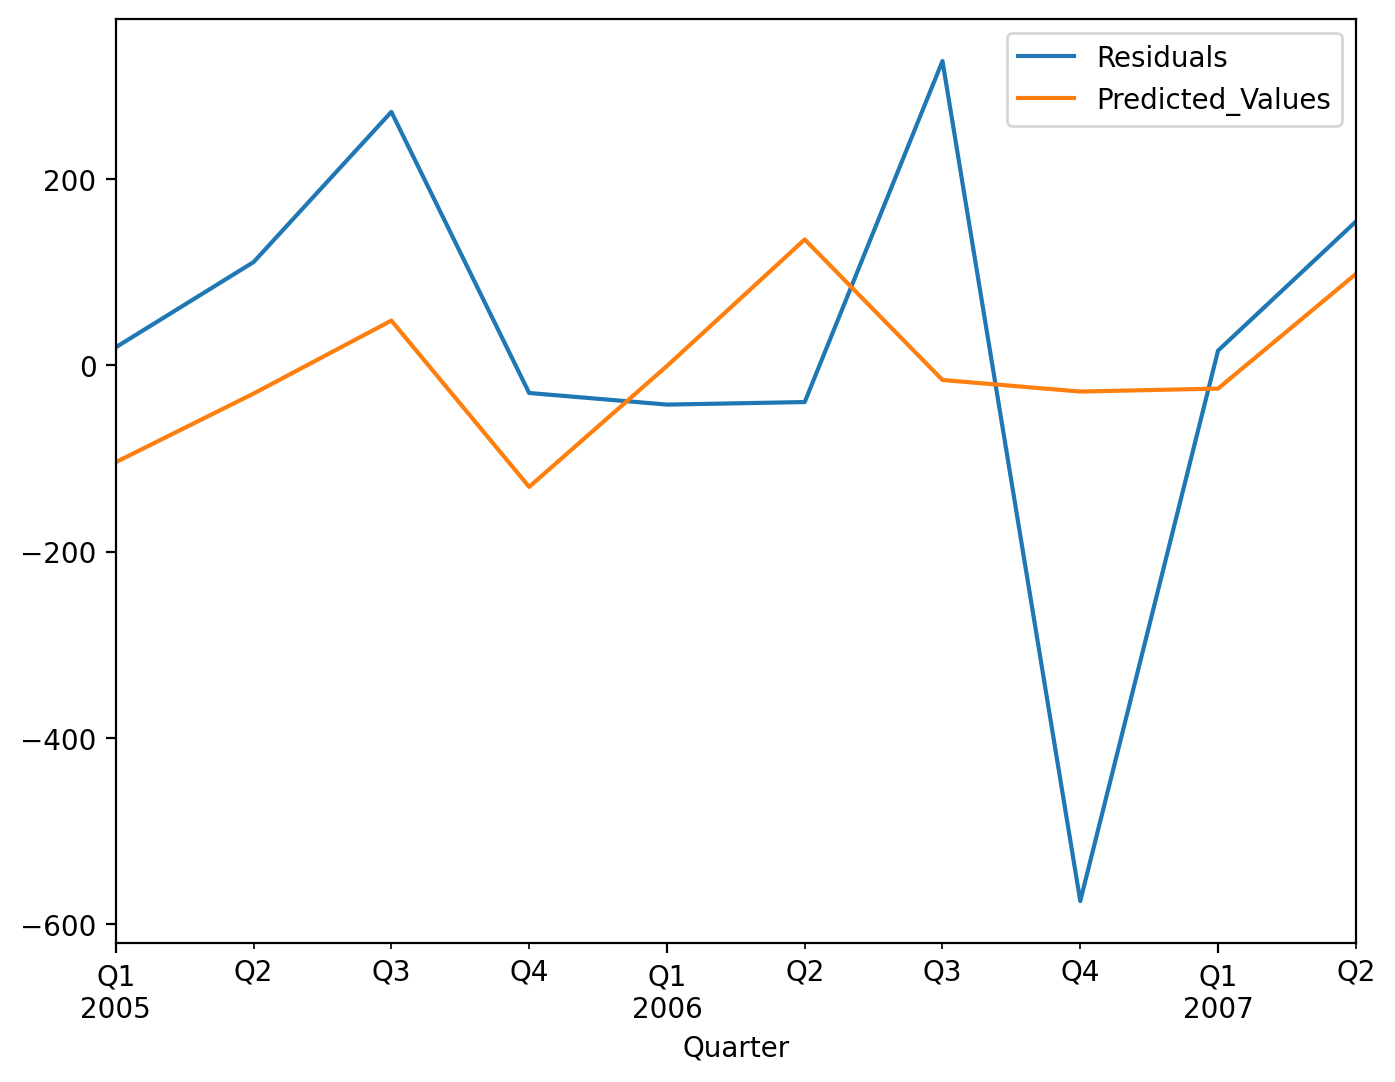

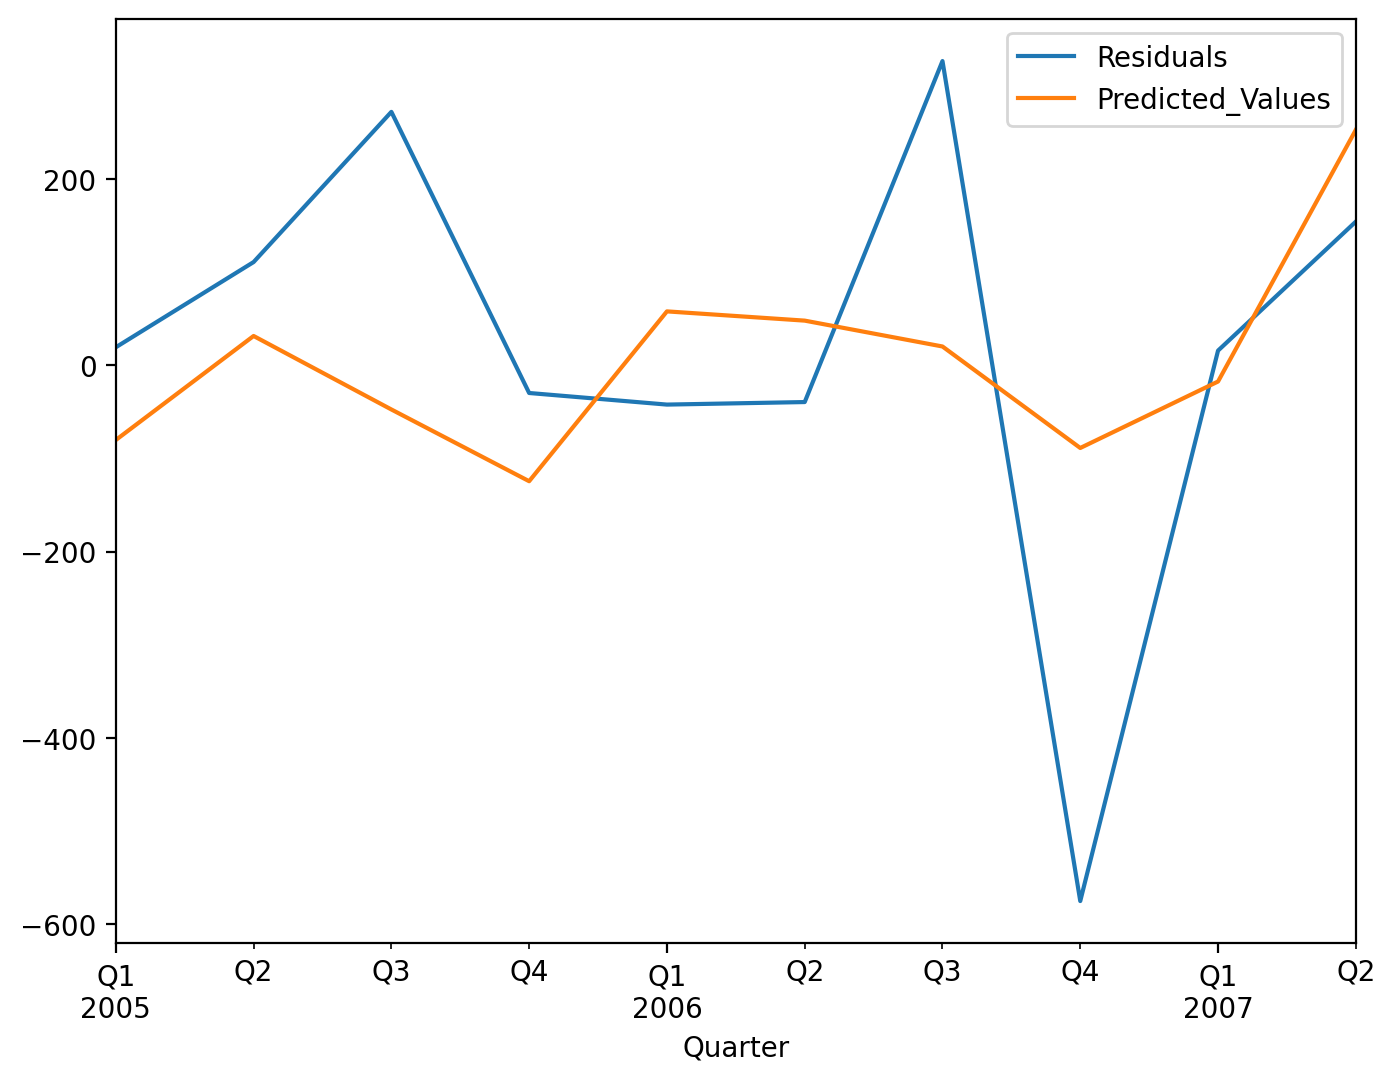

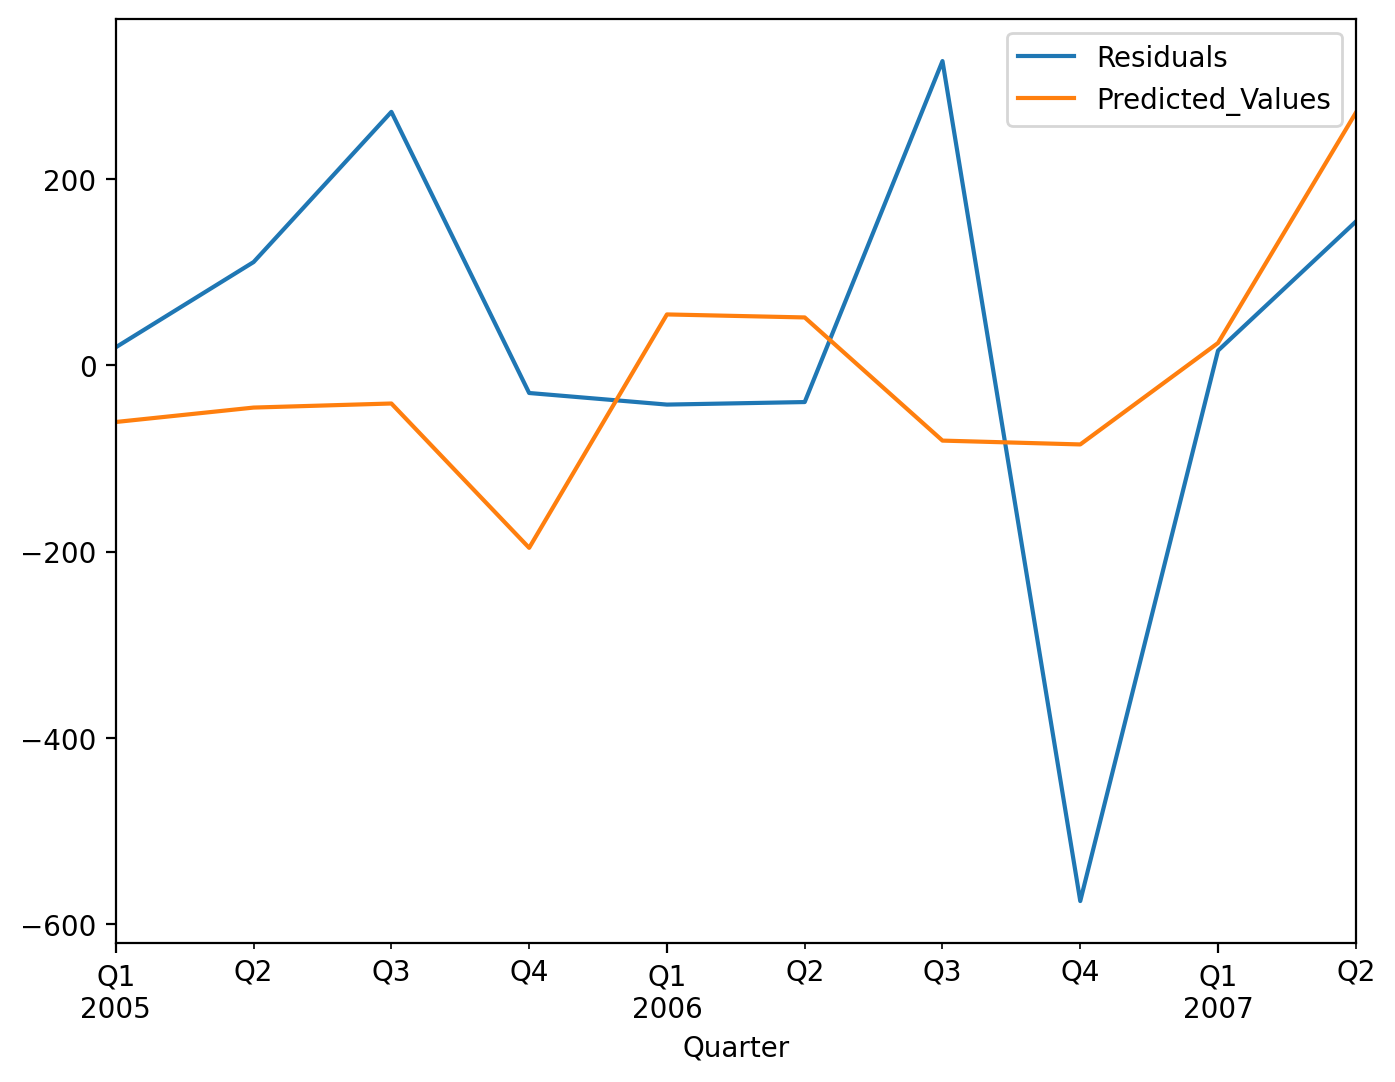

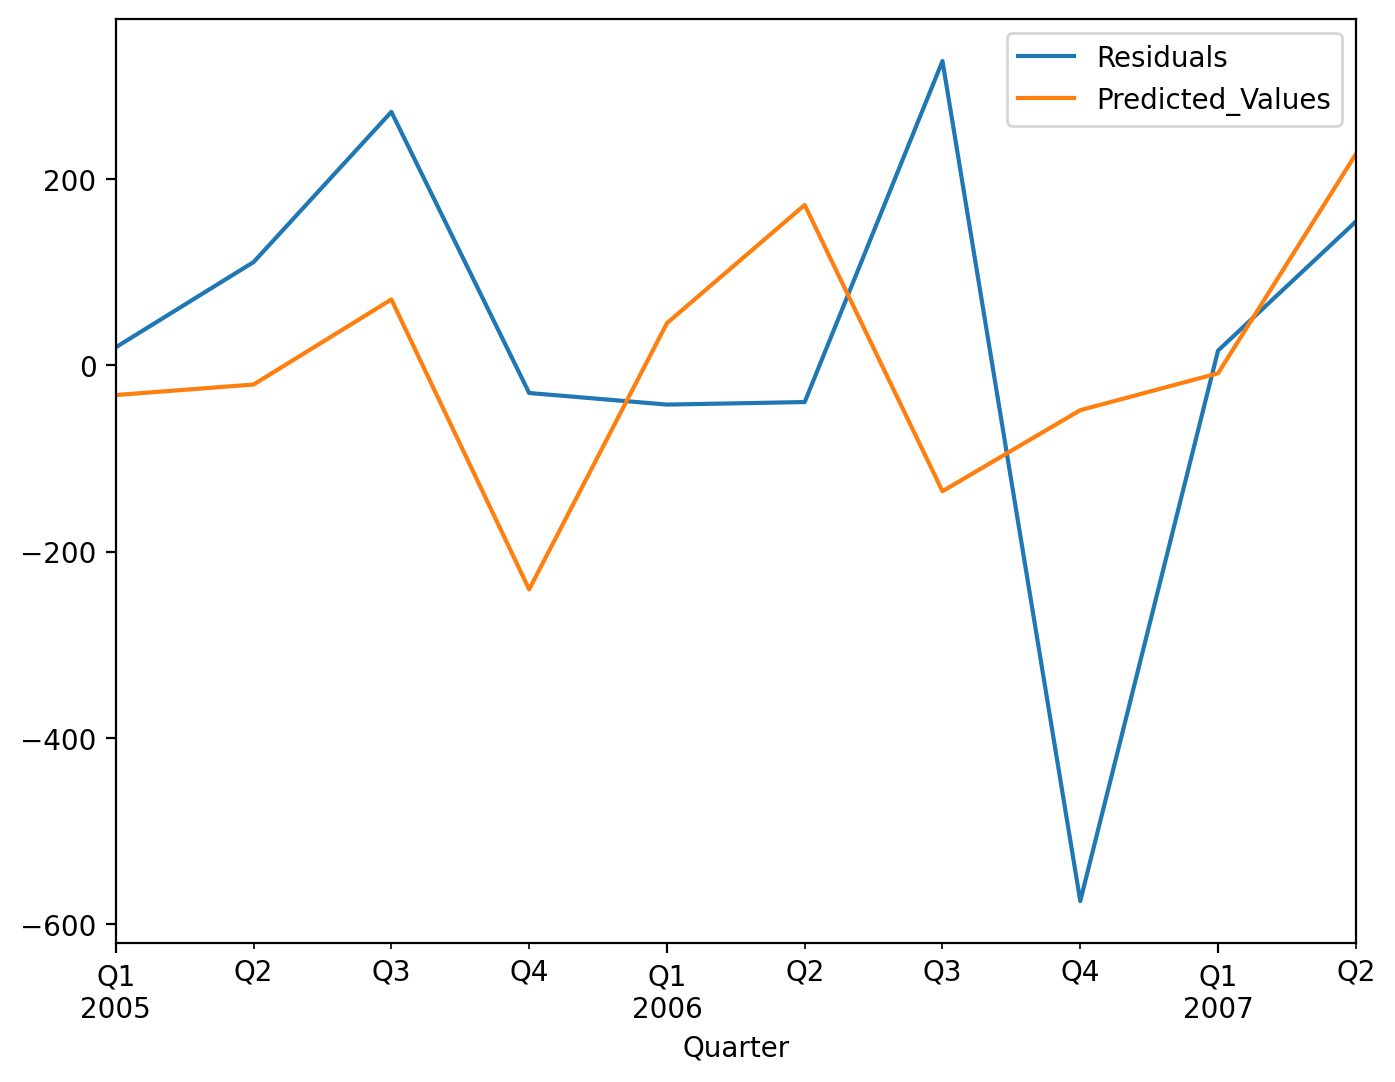

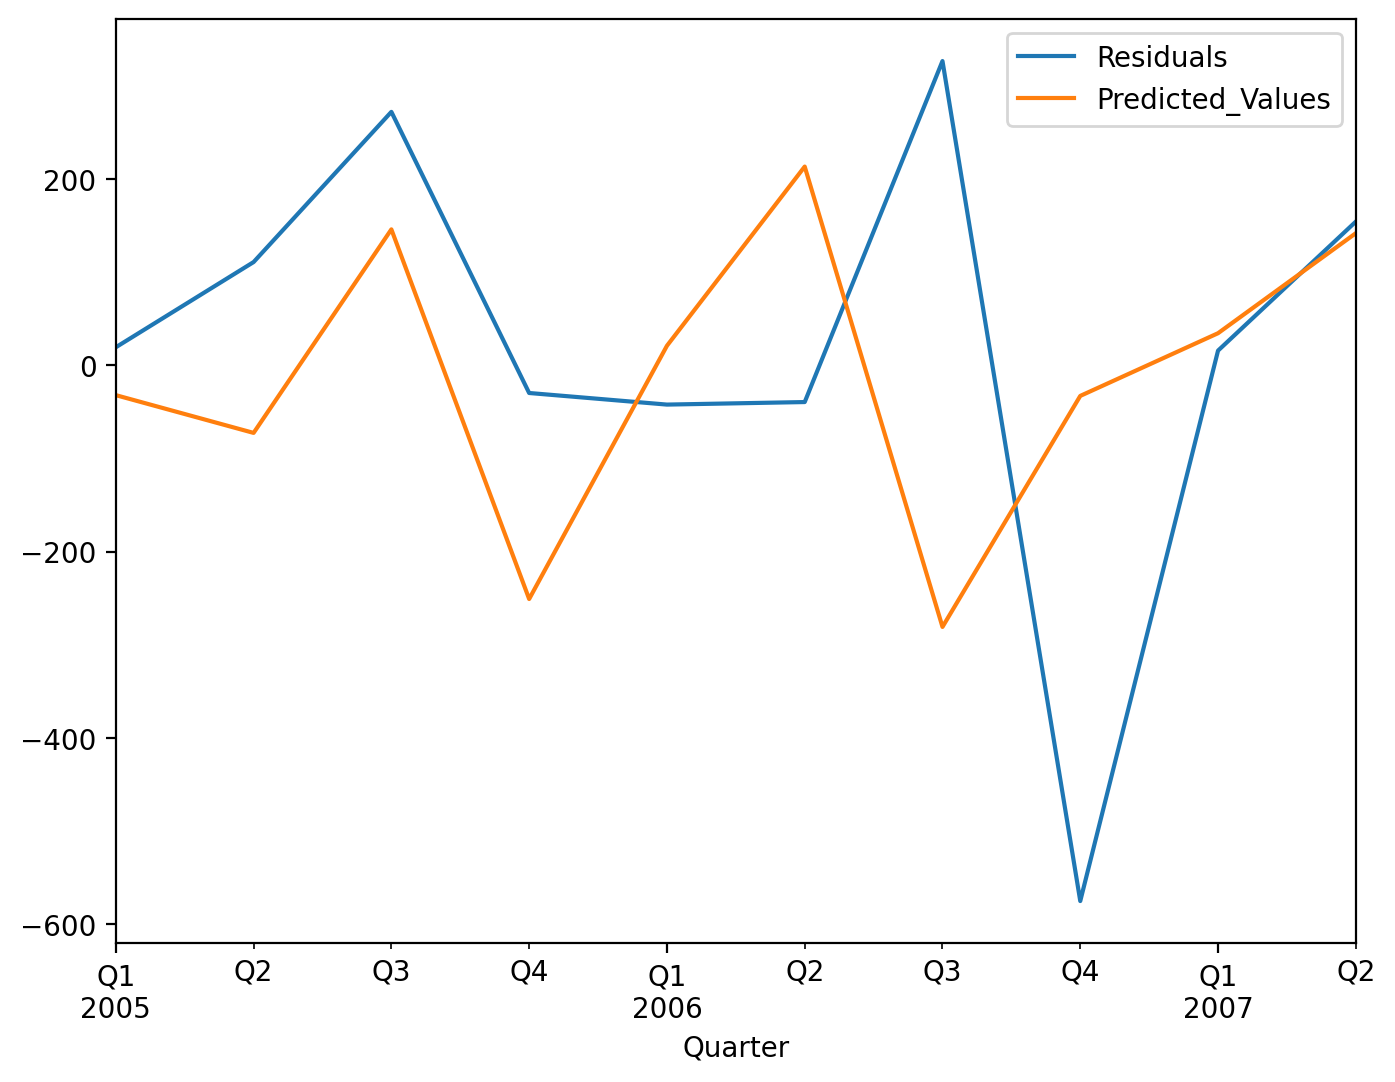

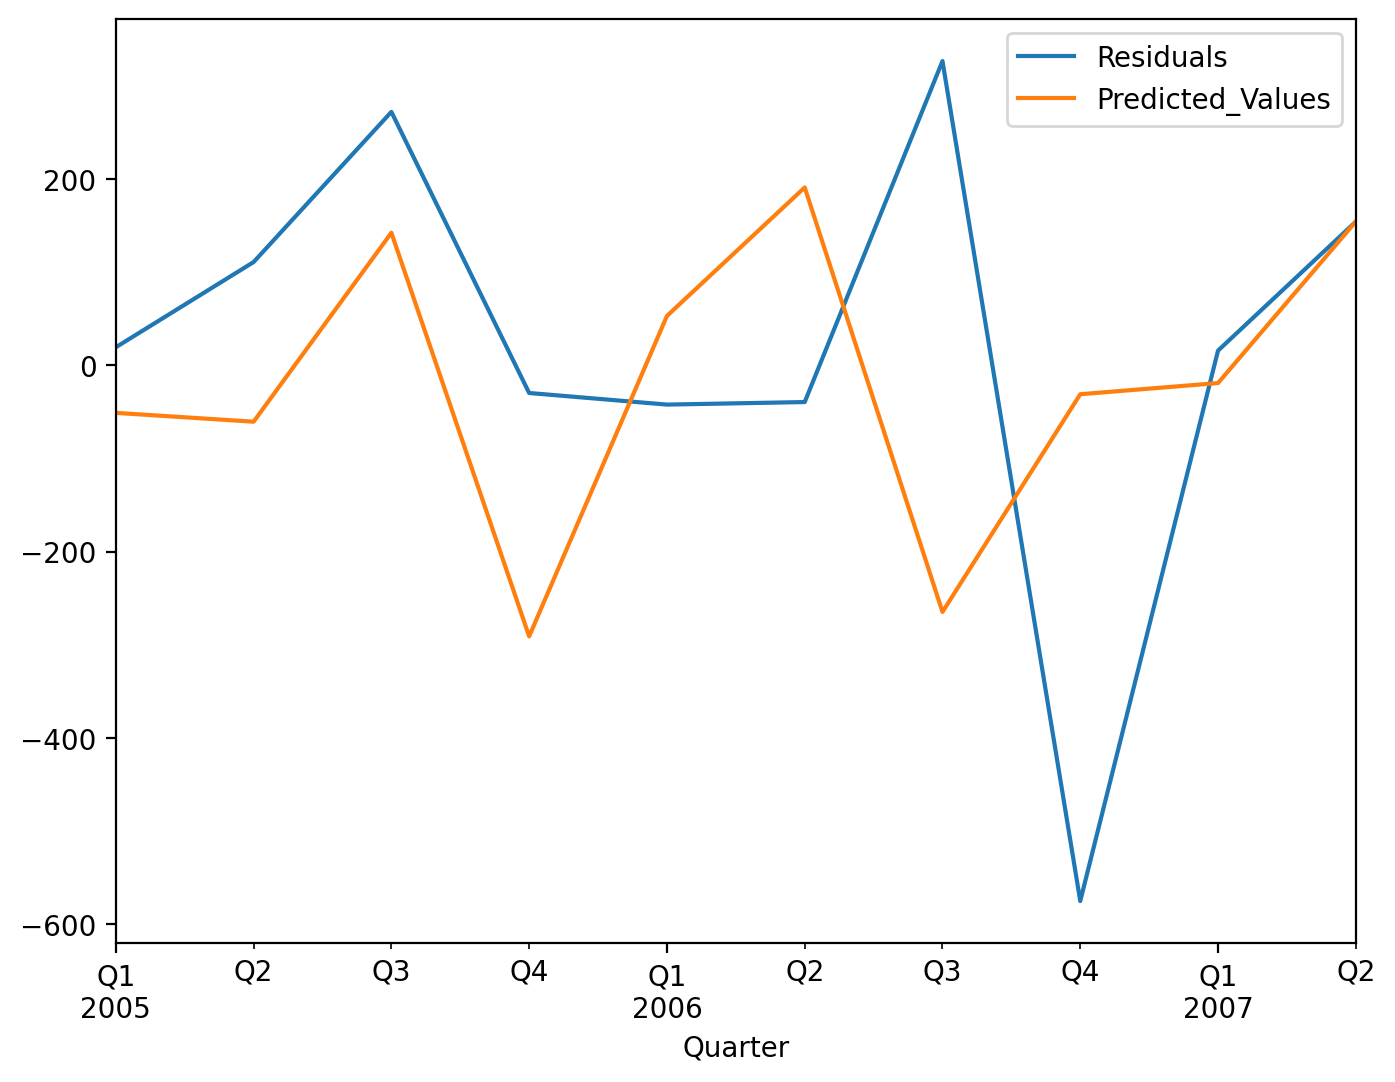

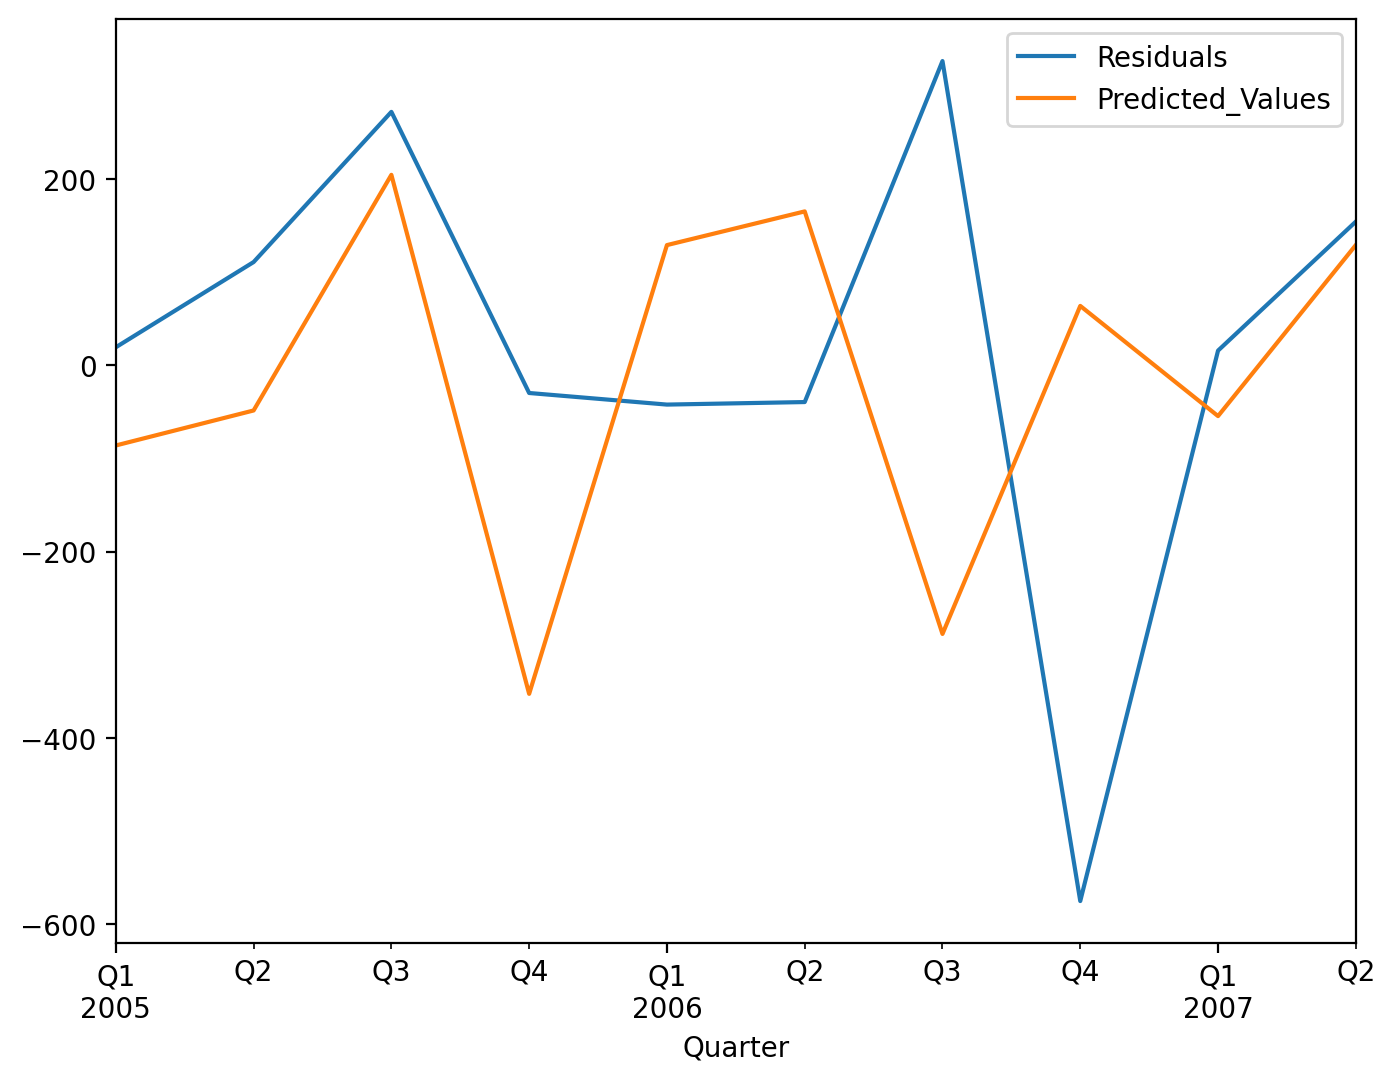

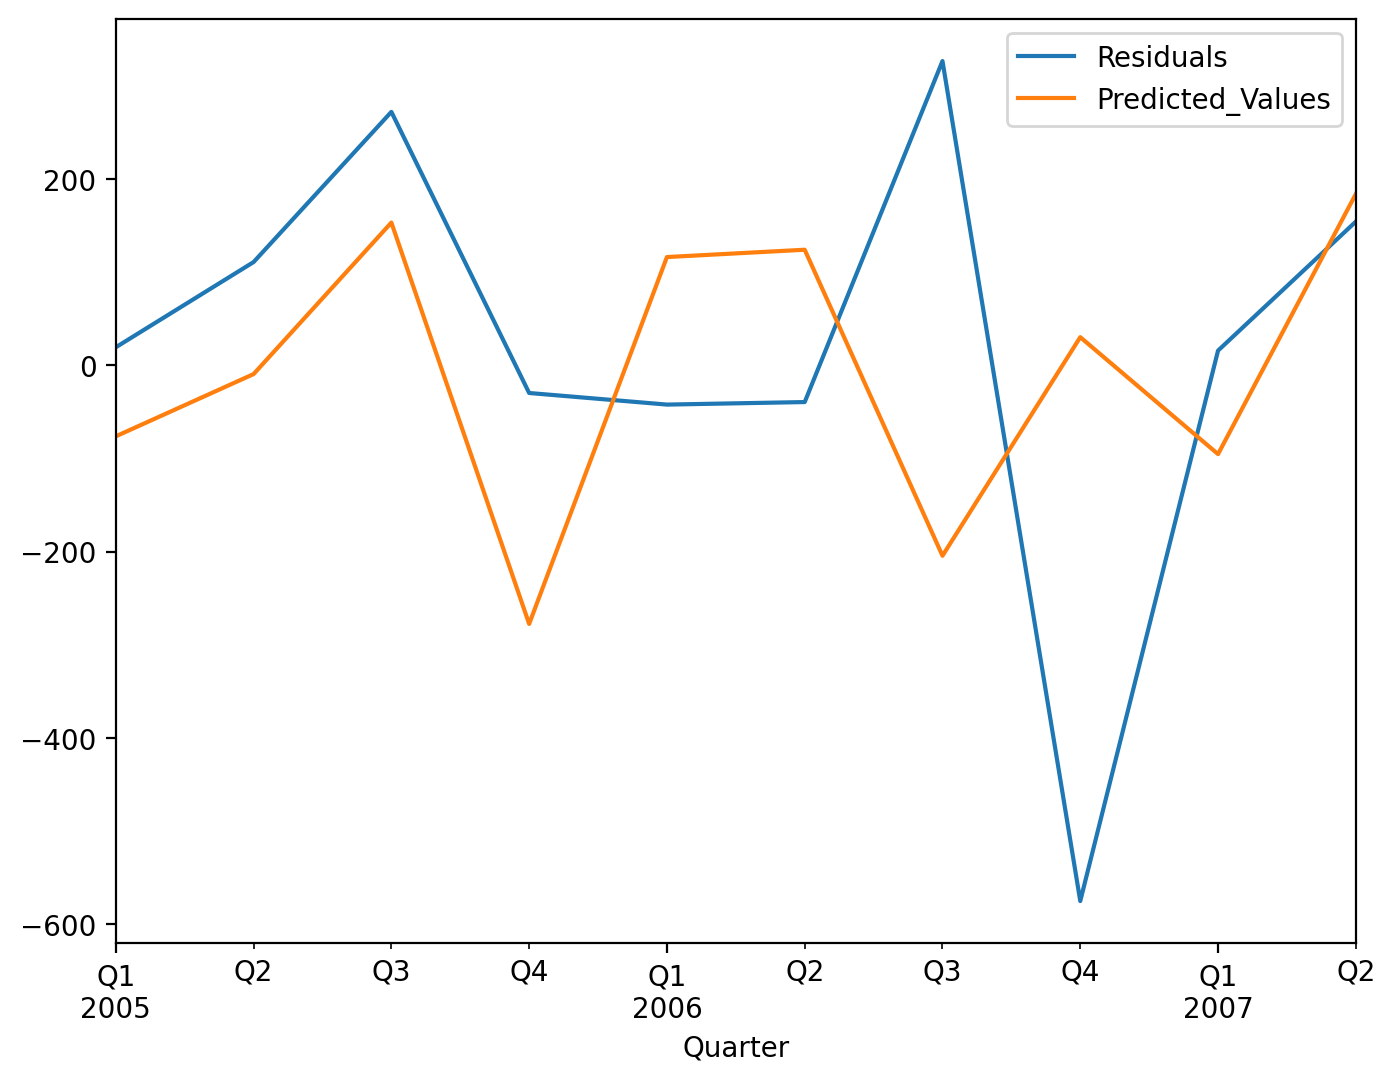

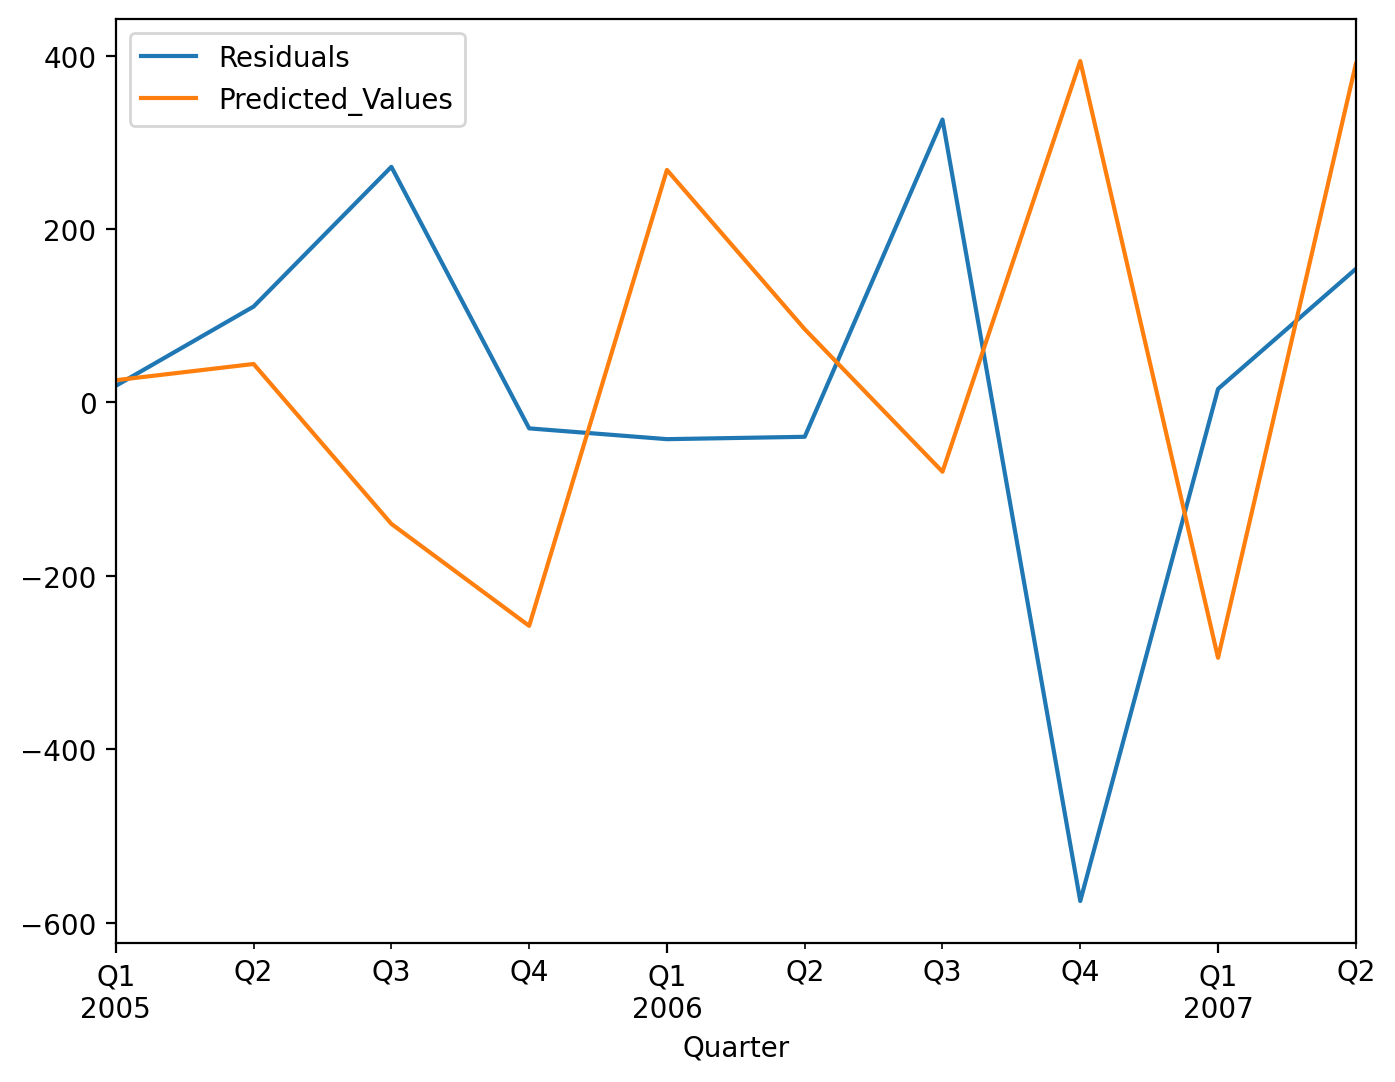

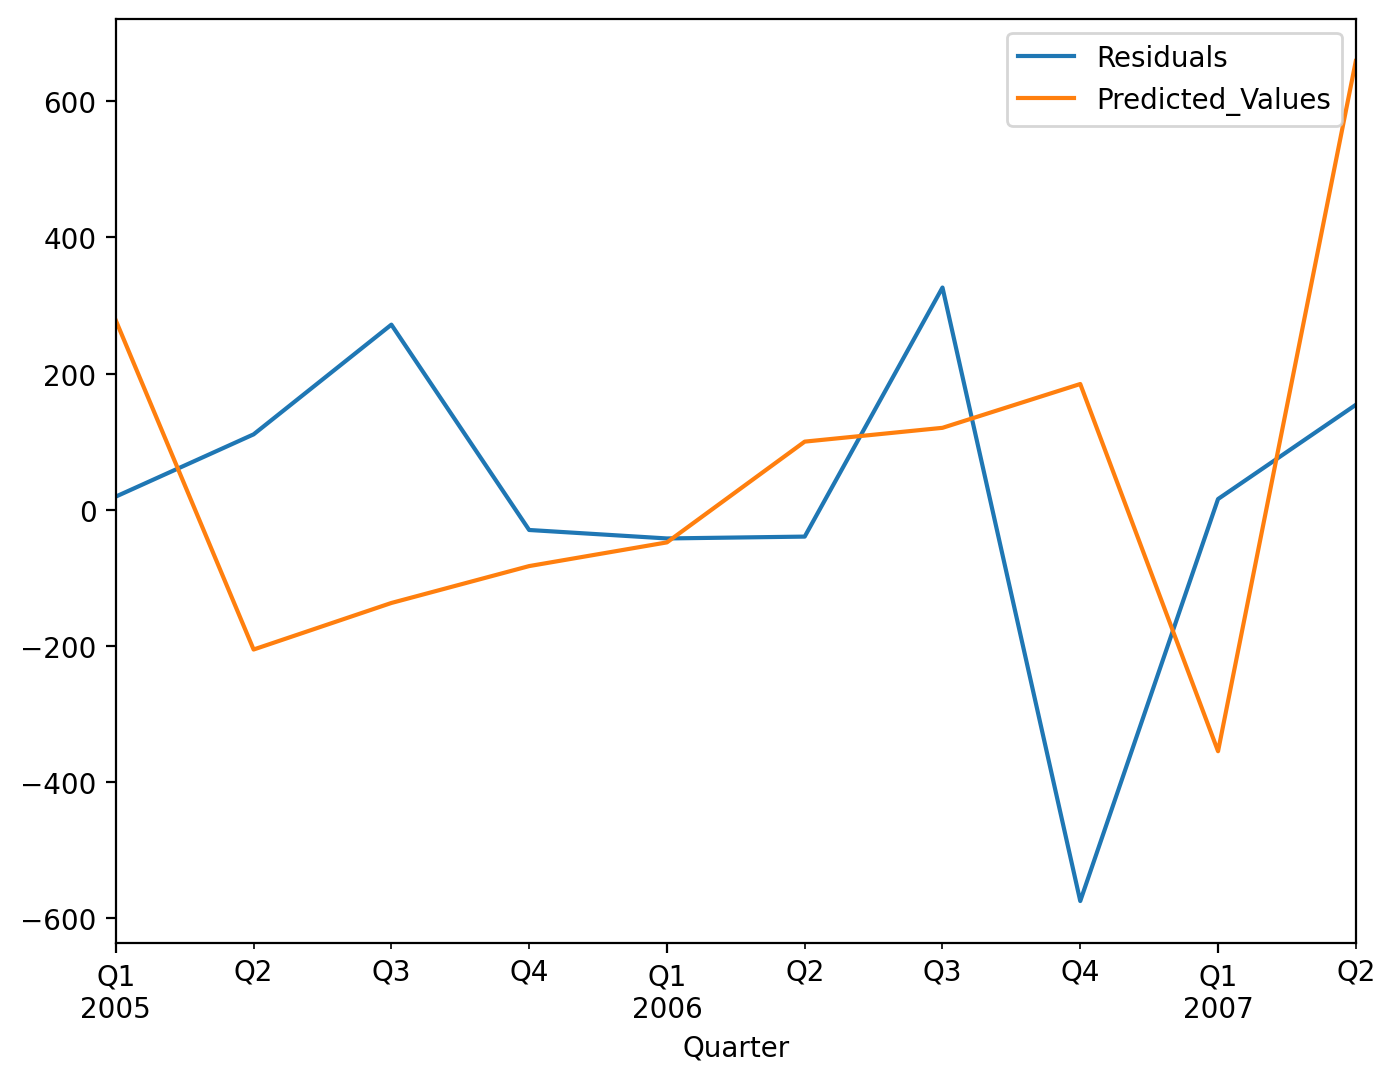

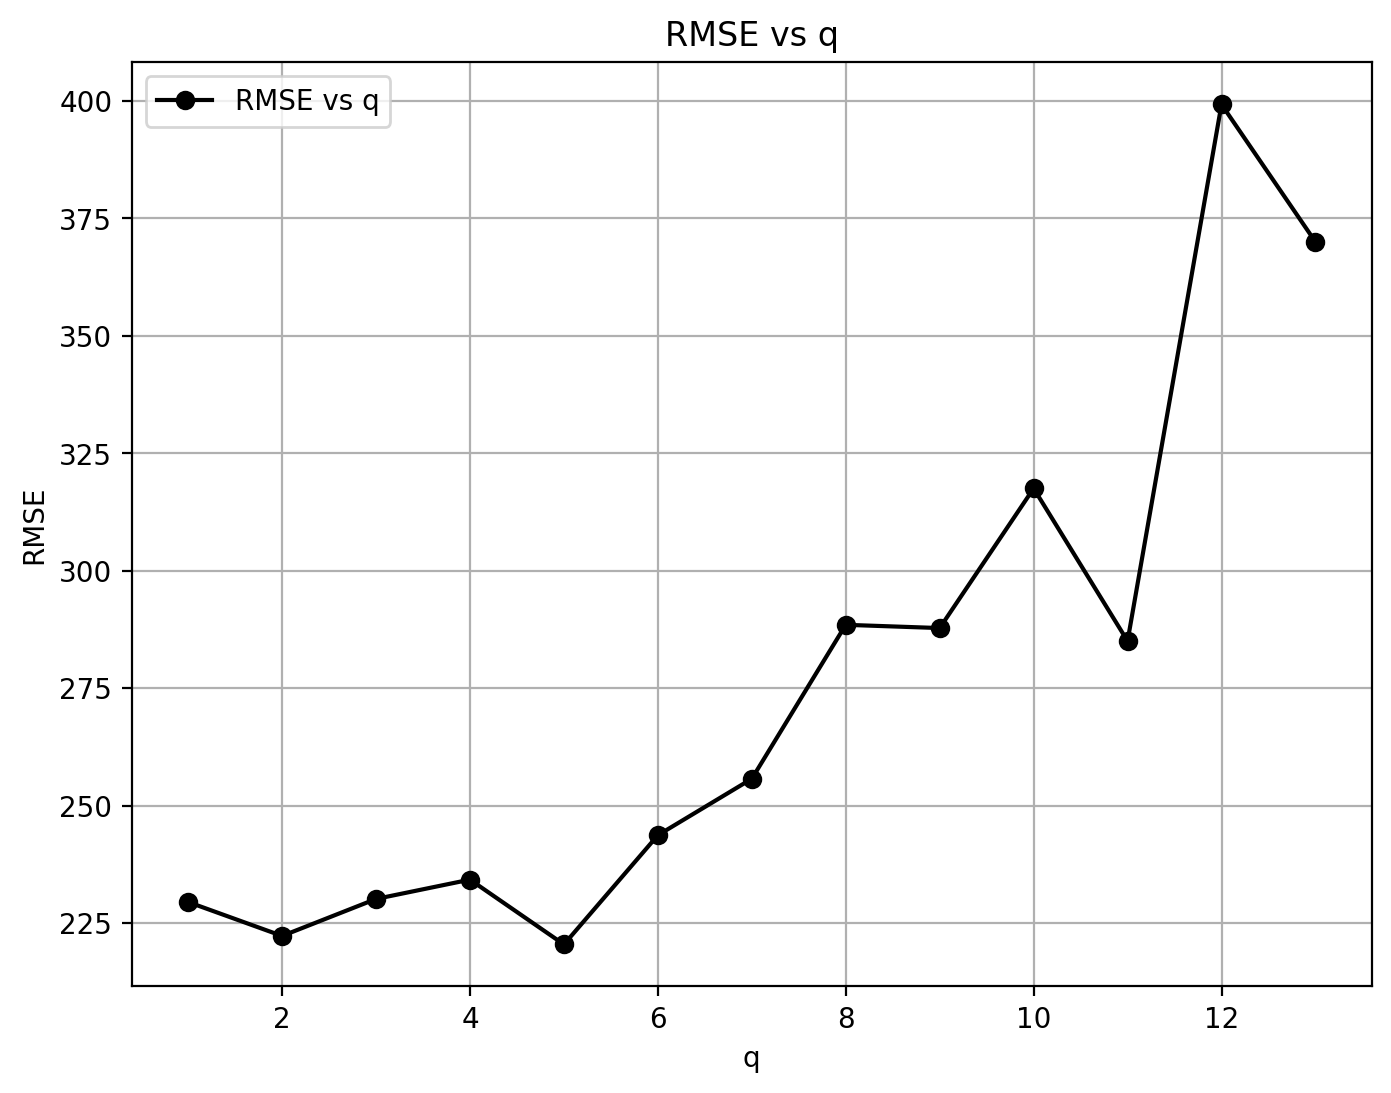

In [ ]:
r=[]
q=[]
for i in range(1,14):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  r.append(RMSE)
  q.append(i)
plt.figure(dpi=200)
plt.plot(q, r, marker='o', linestyle='-', color='black', label='RMSE vs q')
plt.xlabel('q')
plt.ylabel('RMSE')
plt.title('RMSE vs q')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
min_rmse = min(r)
min_rmse_index = r.index(min_rmse)

# Corresponding q-value at the minimum RMSE
optimal_q_value_fin = q[min_rmse_index]

print("Minimum RMSE:", min_rmse)
print("Corresponding q-value:", optimal_q_value_fin)

Minimum RMSE: 220.4540034850413
Corresponding q-value: 5
